# Trabalho Final

## Utilizando agrupamento nebuloso para analisar relação das vulnerabilidades demográficas e socioeconômicas dos municípios brasileiros com os efeitos da Covid-19

### Preparação dos dados 

In [296]:
import datetime
import pandas as pd
from scipy.stats import stats
from sklearn import preprocessing
import skfuzzy as fuzz
import skfuzzy.cluster as cluster
import skfuzzy.control as ctrl
import numpy as np
import matplotlib.pyplot as plt
import os
import unidecode


#### Dados epidemiológicos - consolidado

In [297]:
directory_covid = os.fsencode('dados/covid')
df_covid = None
for file in os.listdir(directory_covid):
    filename = 'dados/covid/' + os.fsdecode(file)
    df_temp = pd.read_csv(filename, decimal=',', sep=';')
    if df_covid is None:
        df_covid = df_temp
    else:
        df_covid = pd.concat([df_covid, df_temp])

df_covid = df_covid[df_covid.municipio.isnull() == False]
df_covid.data = pd.to_datetime(df_covid.data, infer_datetime_format=True)

df_covid = df_covid.rename(
    columns={'regiao': 'REGIAO', 'estado': 'SIGLA_ESTADO', 'municipio': 'MUNICIPIO', 'coduf': 'CODIGO_ESTADO',
             'codmun': 'CODIGO_MUNICIPIO_6', 'codRegiaoSaude': 'CODIGO_REGIAO_SAUDE', 'nomeRegiaoSaude': 'REGIAO_SAUDE',
             'casosAcumulado': 'CASOS', 'obitosAcumulado': 'OBITOS', 'interior/metropolitana': 'REGIAO_METROPOLITANA',
             'casosNovos': 'CASOS_NOVOS', 'obitosNovos': 'OBITOS_NOVOS', 'data': 'DATA', 'semanaEpi': 'SEMANA_EPIDEMIOLOGICA'})
df_covid.CODIGO_MUNICIPIO_6 = df_covid.CODIGO_MUNICIPIO_6.astype('Int64').astype(str)

data_maxima = df_covid.DATA.max()
df_covid_data_filtrada = df_covid[df_covid.DATA == data_maxima]

df_base = df_covid_data_filtrada[['MUNICIPIO', 'CODIGO_MUNICIPIO_6', 'SIGLA_ESTADO', 'CODIGO_ESTADO', 'REGIAO', 'REGIAO_SAUDE',
                    'CODIGO_REGIAO_SAUDE', 'REGIAO_METROPOLITANA', 'CASOS', 'OBITOS']]

#### Dados epidemiológicos - por semana epidemiológica

In [298]:
df_covid['ANO'] = df_covid.DATA.dt.year
df_covid_semana_epidemiologica = \
    df_covid.groupby(['MUNICIPIO','CODIGO_MUNICIPIO_6', 'ANO', 'SEMANA_EPIDEMIOLOGICA']).sum()['CASOS_NOVOS']
df_covid_semana_epidemiologica = df_covid_semana_epidemiologica.reset_index()

df_covid_2020_53 = df_covid_semana_epidemiologica[(df_covid_semana_epidemiologica.ANO == 2020) &
                                                  (df_covid_semana_epidemiologica.SEMANA_EPIDEMIOLOGICA == 53)]
df_covid_2021_53 = df_covid_semana_epidemiologica[(df_covid_semana_epidemiologica.ANO == 2021) &
                                                  (df_covid_semana_epidemiologica.SEMANA_EPIDEMIOLOGICA == 53)]
df_covid_2021_53 = df_covid_2021_53.drop(columns=['MUNICIPIO', 'ANO', 'SEMANA_EPIDEMIOLOGICA'])
df_covid_2021_53 = df_covid_2021_53.rename(columns={'CASOS_NOVOS': 'CASOS_NOVOS_2021'})

df_covid_2020_53 = pd.merge(df_covid_2020_53, df_covid_2021_53, how='left', on='CODIGO_MUNICIPIO_6')

df_covid_2020_53.CASOS_NOVOS = df_covid_2020_53.CASOS_NOVOS + df_covid_2020_53.CASOS_NOVOS_2021
df_covid_2020_53 = df_covid_2020_53.drop(columns=['CASOS_NOVOS_2021'])

df_covid_semana_epidemiologica = df_covid_semana_epidemiologica[df_covid_semana_epidemiologica.SEMANA_EPIDEMIOLOGICA != 53]
df_covid_semana_epidemiologica = pd.concat([df_covid_semana_epidemiologica, df_covid_2020_53])

#### Nome dos estados

In [299]:
df_estados = pd.read_csv('dados/estados.csv', usecols=[1, 2])
df_estados.columns = ['ESTADO', 'SIGLA_ESTADO']
df_estados.SIGLA_ESTADO = df_estados.SIGLA_ESTADO.str.strip()
df_base = pd.merge(df_base, df_estados, how='left', on='SIGLA_ESTADO')

#### Aglomerados subnormais - Estimativa 2019

In [300]:
df_aglomerados_subnormais_estimativa = pd.read_excel('dados/IBGE/aglomerados_subnormais_estiamativa_2019.xls',
                                                     usecols=[1, 3, 4, 5, 8])
df_aglomerados_subnormais_estimativa.columns = \
    ['CODIGO_MUNICIPIO_7', 'POPULACAO_ESTIMADA', 'DOMICILIOS_PARTICULARES_OCUPADOS_ESTIMADO',
     'DOMICILIOS_PARTICULARES_OCUPADOS_AGLOMERADOS_ESTIMADO',
     'PERCENTUAL_DOMICILIOS_PARTICULARES_OCUPADOS_AGLOMERADOS_ESTIMADO']
df_aglomerados_subnormais_estimativa.CODIGO_MUNICIPIO_7 = df_aglomerados_subnormais_estimativa.CODIGO_MUNICIPIO_7.astype('Int64').astype(str)
df_aglomerados_subnormais_estimativa['CODIGO_MUNICIPIO_6'] = df_aglomerados_subnormais_estimativa.CODIGO_MUNICIPIO_7.str[0:6]
df_aglomerados_subnormais_estimativa = df_aglomerados_subnormais_estimativa.fillna(0)

df_base = pd.merge(df_base, df_aglomerados_subnormais_estimativa, how='left', on=['CODIGO_MUNICIPIO_6'])

#### Regiões imediatas e regiões intermediárias

In [301]:
df_regioes = pd.read_excel('dados/IBGE/regioes_geograficas_composicao_por_municipios_2017_20180911.ods',
                           usecols=[1, 2, 3, 4, 5])
df_regioes.columns = ['CODIGO_MUNICIPIO_7', 'CODIGO_REGIAO_IMEDIATA', 'REGIAO_IMEDIATA', 'CODIGO_REGIAO_INTERMEDIARIA', 'REGIAO_INTERMEDIARIA']
df_regioes.CODIGO_MUNICIPIO_7 = df_regioes.CODIGO_MUNICIPIO_7.astype('Int64').astype(str)
df_base = pd.merge(df_base, df_regioes, how='left', on=['CODIGO_MUNICIPIO_7'])

#### Censo 2010 - Dados IBGE

##### Faixa etária

In [302]:
df_percentual_faixa_etaria = pd.read_csv('dados/IBGE/tab2_percentual_faixa_etaria.csv', sep=';', decimal=',')
df_percentual_faixa_etaria = df_percentual_faixa_etaria.dropna()
df_percentual_faixa_etaria.columns = df_percentual_faixa_etaria.columns.str.replace(" ", "_")
df_percentual_faixa_etaria.columns = df_percentual_faixa_etaria.columns.str.upper()
df_percentual_faixa_etaria.CODMUN7 = df_percentual_faixa_etaria.CODMUN7.astype('Int64').astype(str)
df_percentual_faixa_etaria = df_percentual_faixa_etaria[
    ['CODMUN7', '0_A_5_ANOS', '6_A_14_ANOS', '15_A_24_ANOS', '25_A_39_ANOS', '40_A_59_ANOS',
     '60_ANOS_OU_MAIS']]
df_percentual_faixa_etaria.columns = \
    ['CODIGO_MUNICIPIO_7', 'PERCENTUAL_POPULACAO_0_A_5_ANOS', 'PERCENTUAL_POPULACAO_6_A_14_ANOS',
     'PERCENTUAL_POPULACAO_15_A_24_ANOS', 'PERCENTUAL_POPULACAO_25_A_39_ANOS', 'PERCENTUAL_POPULACAO_40_A_59_ANOS',
     'PERCENTUAL_POPULACAO_60_ANOS_OU_MAIS']
df_base = pd.merge(df_base, df_percentual_faixa_etaria, how="left", on=['CODIGO_MUNICIPIO_7'])

##### População sede municipal, área, densidade e domicílios

In [303]:
PATH_SINOPSE = 'dados/IBGE/SinopseEstados/'
directory_sinopse = os.fsencode(PATH_SINOPSE)
df_1_densidade = None
df_2_domicilios = None
for directory_state in os.listdir(directory_sinopse):
    directory_path = PATH_SINOPSE + '/' + os.fsdecode(directory_state)
    for file in os.listdir(directory_path):
        filename = os.fsdecode(file)

        if filename.startswith('tab2_1_'):
            relative_filename = directory_path + '/' + filename
            df_temp = pd.read_excel(relative_filename, header=None, usecols=[3, 7, 8, 9],
                                 skiprows=10, skipfooter=1)
            df_temp.columns = ['POPULACAO_SEDE_MUNICIPAL', 'AREA', 'DENSIDADE', 'CODIGO_MUNICIPIO_7']
            if df_1_densidade is None:
                df_1_densidade = df_temp
            else:
                df_1_densidade = pd.concat([df_1_densidade, df_temp])

        if filename.startswith('tab2_2_'):
            relative_filename = directory_path + '/' + filename
            df_temp = pd.read_excel(relative_filename, header=None, usecols=[2, 11],
                                 skiprows=10, skipfooter=2)
            df_temp.columns = ['DOMICILIOS_PARTICULARES_OCUPADOS', 'CODIGO_MUNICIPIO_7']
            if df_2_domicilios is None:
                df_2_domicilios = df_temp
            else:
                df_2_domicilios = pd.concat([df_2_domicilios, df_temp])
df_1_densidade.CODIGO_MUNICIPIO_7 = df_1_densidade.CODIGO_MUNICIPIO_7.astype('Int64').astype(str)
df_2_domicilios.CODIGO_MUNICIPIO_7 = df_2_domicilios.CODIGO_MUNICIPIO_7.astype('Int64').astype(str)

df_base = pd.merge(df_base, df_1_densidade, how = 'left', on=['CODIGO_MUNICIPIO_7'])
df_base = pd.merge(df_base, df_2_domicilios, how = 'left', on=['CODIGO_MUNICIPIO_7'])

##### Aglomerados subnormais - Censo 2010

In [304]:
df_aglomerados_subnormais = pd.read_excel('dados/IBGE/aglomerados_subnormais.xls', header=None,
                                          usecols=[1, 2, 3, 4, 5, 6, 7], skiprows=8, skipfooter=3)
df_aglomerados_subnormais.columns = \
    ['AGLOMERADOS', 'DOMICILIOS_PARTICULARES_OCUPADOS_AGLOMERADOS',
     'POPULACAO_AGLOMERADOS', 'AREA_AGLOMERADOS', 'DENSIDADE_DEMOGRAFICA_AGLOMERADOS',
     'DENSIDADE_DOMICILIOS_AGLOMERADOS','CODIGO_MUNICIPIO_7']
df_aglomerados_subnormais.CODIGO_MUNICIPIO_7 = df_aglomerados_subnormais.CODIGO_MUNICIPIO_7.astype('Int64').astype(str)
df_aglomerados_subnormais = df_aglomerados_subnormais[df_aglomerados_subnormais.CODIGO_MUNICIPIO_7.str.len() == 7]

df_base = pd.merge(df_base, df_aglomerados_subnormais, how='left', on=['CODIGO_MUNICIPIO_7'])

df_base.AGLOMERADOS = df_base.AGLOMERADOS.fillna(0)
df_base.DOMICILIOS_PARTICULARES_OCUPADOS_AGLOMERADOS = df_base.DOMICILIOS_PARTICULARES_OCUPADOS_AGLOMERADOS.fillna(0)
df_base.POPULACAO_AGLOMERADOS = df_base.POPULACAO_AGLOMERADOS.fillna(0)
df_base.AREA_AGLOMERADOS = df_base.AREA_AGLOMERADOS.fillna(0)
df_base.DENSIDADE_DEMOGRAFICA_AGLOMERADOS = df_base.DENSIDADE_DEMOGRAFICA_AGLOMERADOS.fillna(0)
df_base.DENSIDADE_DOMICILIOS_AGLOMERADOS = df_base.DENSIDADE_DOMICILIOS_AGLOMERADOS.fillna(0)

##### Atributos sistematizados pelo Atlas BR

In [305]:
df_censo = pd.read_csv('dados/AtlasBrasil/censo.csv', sep=';', decimal=',')
df_censo = df_censo[df_censo.ANO ==  2010]
df_censo.columns = df_censo.columns.str.upper()
df_censo = df_censo[['CODMUN7', 'IDHM','IDHM_E','IDHM_L','IDHM_R', 'FECTOT','CORTE1','CORTE2',
                    'CORTE3','CORTE4','CORTE9','GINI', 'PIND', 'PMPOB', 'PPOB', 'PREN10RICOS', 'PREN20','PREN20RICOS',
                    'PREN40','PREN60','PREN80', 'PRENTRAB','R1040','R2040', 'RDPC1','RDPC10','RDPC2','RDPC3','RDPC4',
                    'RDPC5','RIND','RMPOB','RPOB','THEIL', 'CPR','P_AGRO','P_COM','P_CONSTR','P_EXTR',
                    'P_FORMAL', 'P_SERV', 'P_SIUP', 'P_TRANSF', 'REN0','REN1','REN2','REN3','REN5', 'T_ATIV', 'T_DES',
                    'THEILTRAB', 'TRABPUB','T_BANAGUA', 'T_DENS', 'T_OCUPDESLOC_1', 'HOMEMTOT',
                     'MULHERTOT', 'PESO1', 'PESO13', 'PESO4', 'PESO5', 'PESO610',
                    'PESO1114', 'PESO1517', 'PESO18', 'PESO65', 'PESORUR','PESOTOT','PESOURB', 'RAZDEP', 'POP']]
df_censo = df_censo.rename(
    columns={'CODMUN7': 'CODIGO_MUNICIPIO_7', 'IDHM_E': 'IDHM_EDUCACAO','IDHM_L': 'IDHM_LONGEVIDADE','IDHM_R': 'IDHM_RENDA',
             'FECTOT': 'TAXA_FECUNDIDADE','CORTE1': 'RENDA_PER_CAPTA_MAXIMA_1_QUINTO_MAIS_POBRE',
             'CORTE2': 'RENDA_PER_CAPTA_MAXIMA_2_QUINTO_MAIS_POBRE', 'CORTE3': 'RENDA_PER_CAPTA_MAXIMA_3_QUINTO_MAIS_POBRE',
             'CORTE4': 'RENDA_PER_CAPTA_MAXIMA_4_QUINTO_MAIS_POBRE','CORTE9': 'RENDA_PER_CAPTA_MINIMA_10_PORCENTO_MAIS_RICOS',
             'PIND': 'PERCENTUAL_EXTREMAMENTE_POBRES', 'PMPOB': 'PERCENTUAL_POBRES', 'PPOB': 'PERCENTUAL_VULNERAVEIS_POBREZA',
             'PREN10RICOS': 'PERCENTUAL_RENDA_APROPRIADA_10_PORCENTO_MAIS_RICOS',
             'PREN20RICOS': 'PERCENTUAL_RENDA_APROPRIADA_20_PORCENTO_MAIS_RICOS',
             'PREN20': 'PERCENTUAL_RENDA_APROPRIADA_20_PORCENTO_MAIS_POBRES',
             'PREN40': 'PERCENTUAL_RENDA_APROPRIADA_40_PORCENTO_MAIS_POBRES',
             'PREN60': 'PERCENTUAL_RENDA_APROPRIADA_60_PORCENTO_MAIS_POBRES',
             'PREN80': 'PERCENTUAL_RENDA_APROPRIADA_80_PORCENTO_MAIS_POBRES',
             'PRENTRAB': 'PERCENTUAL_RENDA_PROVENIENTE_TRABALHO','R1040': 'RAZAO_10_PORCENTO_MAIS_RICOS_POR_40_PORCENTO_MAIS_POBRES',
             'R2040': 'RAZAO_20_PORCENTO_MAIS_RICOS_POR_40_PORCENTO_MAIS_POBRES',
             'RDPC1': 'RENDA_PER_CAPTA_MEDIA_1_QUINTO_MAIS_POBRE', 'RDPC2': 'RENDA_PER_CAPTA_MEDIA_2_QUINTO_MAIS_POBRE',
             'RDPC3': 'RENDA_PER_CAPTA_MEDIA_3_QUINTO_MAIS_POBRE','RDPC4': 'RENDA_PER_CAPTA_MEDIA_4_QUINTO_MAIS_POBRE',
             'RDPC5': 'RENDA_PER_CAPTA_MEDIA_20_PORCENTO_MAIS_RICOS', 'RDPC10': 'RENDA_PER_CAPTA_MEDIA_10_PORCENTO_MAIS_RICOS',
             'RIND': 'RENDA_PER_CAPTA_MEDIA_EXTREMAMENTE_POBRES','RMPOB': 'RENDA_PER_CAPTA_MEDIA_POBRES',
             'RPOB': 'RENDA_PER_CAPTA_MEDIA_VULNERAVEIS_POBREZA','CPR': 'PERCENTUAL_TRABALHADORES_CONTA_PROPRIA',
             'P_AGRO': 'PERCENTUAL_OCUPADOS_AGROPECUARIA','P_COM': 'PERCENTUAL_OCUPADOS_COMERCIO','P_CONSTR': 'PERCENTUAL_OCUPADOS_CONSTRUCAO',
             'P_EXTR': 'PERCENTUAL_OCUPADOS_MINERACAO', 'P_FORMAL': 'PERCENTUAL_TRABALHADORES_FORMALIZADOS',
             'P_SERV': 'PERCENTUAL_OCUPADOS_SERVICO', 'P_SIUP': 'PERCENTUAL_OCUPADOS_SERVICOS_INDUSTRIAIS_UTILIDADE_PUBLICA',
             'P_TRANSF': 'PERCENTUAL_OCUPADOS_INDUSTRIA', 'REN0': 'PERCENTUAL_OCUPADOS_SEM_RENDA',
             'REN1': 'PERCENTUAL_OCUPADOS_ATE_1_SALARIO_MINIMO','REN2': 'PERCENTUAL_OCUPADOS_ATE_2_SALARIOS_MINIMOS',
             'REN3': 'PERCENTUAL_OCUPADOS_ATE_3_SALARIOS_MINIMOS','REN5': 'PERCENTUAL_OCUPADOS_ATE_5_SALARIOS_MINIMOS',
             'T_ATIV': 'TAXA_ATIVIDADE', 'T_DES': 'TAXA_DESOCUPACAO', 'THEILTRAB': 'THEIL_TRABALHO', 'TRABPUB': 'PERCENTUAL_TRABALHADORES_PUBLICOS',
             'T_BANAGUA': 'PERCENTUAL_POPULACAO_VIVE_DOMICILIOS_BANHEIRO_AGUA',
             'T_DENS': 'PERCENTUAL_POPULACAO_VIVE_DOMICILIOS_DENSIDADE_MAIOR_2_POR_DORMITORIO',
             'T_OCUPDESLOC_1': 'PERCENTUAL_POPULACAO_VULNERAVEL_POBREZA_GASTAM_MAIS_UMA_HORA_ATE_TRABALHO',
             'HOMEMTOT': 'POPULACAO_MASCULINA', 'MULHERTOT': 'POPULACAO_FEMININA', 'PESO1': 'POPULACAO_ATE_1_ANO',
             'PESO13': 'POPULACAO_1_A_3_ANOS', 'PESO4': 'POPULACAO_4_ANOS', 'PESO5': 'POPULACAO_5_ANOS',
             'PESO610': 'POPULACAO_6_A_10_ANOS', 'PESO1114': 'POPULACAO_11_A_14_ANOS', 'PESO1517': 'POPULACAO_15_A_17_ANOS',
             'PESO18': 'POPULACAO_18_ANOS_OU_MAIS', 'PESO65': 'POPULACAO_65_ANOS_OU_MAIS', 'PESORUR': 'POPULACAO_RURAL',
             'PESOTOT': 'POPULACAO_TOTAL','PESOURB': 'POPULACAO_URBANA', 'RAZDEP': 'RAZAO_DEPENDENCIA', 'POP': 'POPULACAO_DOMICILIOS_PARTICULARES'})
df_censo = df_censo.astype({'CODIGO_MUNICIPIO_7': str})

df_base = pd.merge(df_base, df_censo, how='left', on='CODIGO_MUNICIPIO_7')

#### Registros administrativos sistematizados pelo Atlas BR

In [306]:
df_registros_administrativos =  pd.read_csv('dados/AtlasBrasil/registros_administrativos.csv', decimal=',', sep=';')
df_registros_administrativos = df_registros_administrativos.astype({'IBGE7': str})

df_registros_administrativos_2017 = df_registros_administrativos[df_registros_administrativos.ANO == 2017]
df_registros_administrativos_2017 = df_registros_administrativos_2017[
    ['IBGE7','PINTERDRSAI', 'REN_TRPCBF_D', 'TXCOBPLP']]
df_registros_administrativos_2017 = df_registros_administrativos_2017.rename(
    columns={'IBGE7': 'CODIGO_MUNICIPIO_7', 'PINTERDRSAI': 'PERCENTUAL_INTERNACAOES_DOENCAS_SANEAMENTO_INADEQUADO',
             'REN_TRPCBF_D': 'TRANSFERENCIA_PERCAPTA_BOLSA_FAMILIA', 'TXCOBPLP': 'PERCENTUAL_POPULACAO_COBERTA_PLANO_SAUDE'})
df_base = pd.merge(df_base, df_registros_administrativos_2017, how="left", on=['CODIGO_MUNICIPIO_7'])

df_registros_administrativos_2016 = df_registros_administrativos[df_registros_administrativos.ANO == 2016]
df_registros_administrativos_2016 = df_registros_administrativos_2016[
    ['IBGE7', 'REN_PVAADM', 'REN_PVAAGR', 'REN_PVAIND', 'REN_PVASERV']]
df_registros_administrativos_2016 = df_registros_administrativos_2016.rename(
    columns={'IBGE7': 'CODIGO_MUNICIPIO_7', 'REN_PVAADM': 'PERCENTUAL_VALOR_ADICIONADO_ADMINISTRACAO_PUBLICA',
             'REN_PVAAGR': 'PERCENTUAL_VALOR_ADICIONADO_AGRICULTURA', 'REN_PVAIND': 'PERCENTUAL_VALOR_ADICIONADO_INDUSTRIA',
             'REN_PVASERV': 'PERCENTUAL_VALOR_ADICIONADO_SERVICO'})
df_base = pd.merge(df_base, df_registros_administrativos_2016, how="left", on=['CODIGO_MUNICIPIO_7'])


##### Tratamento de dados ausentes em PERCENTUAL_POPULACAO_COBERTA_PLANO_SAUDE

In [307]:
df_group_regiao_imediata = df_base.groupby('CODIGO_REGIAO_IMEDIATA').mean()[['PERCENTUAL_POPULACAO_COBERTA_PLANO_SAUDE']]
df_group_regiao_imediata.columns = ['PERCENTUAL_POPULACAO_COBERTA_PLANO_SAUDE_MEDIA_REGIAO_IMEDIATA']
df_group_regiao_imediata = df_group_regiao_imediata.reset_index()
df_base = pd.merge(df_base, df_group_regiao_imediata, how='left', on='CODIGO_REGIAO_IMEDIATA')
df_base.loc[df_base.PERCENTUAL_POPULACAO_COBERTA_PLANO_SAUDE.isnull(), 'PERCENTUAL_POPULACAO_COBERTA_PLANO_SAUDE'] = \
    df_base[df_base.PERCENTUAL_POPULACAO_COBERTA_PLANO_SAUDE.isnull()].PERCENTUAL_POPULACAO_COBERTA_PLANO_SAUDE_MEDIA_REGIAO_IMEDIATA
df_base = df_base.drop(columns=['PERCENTUAL_POPULACAO_COBERTA_PLANO_SAUDE_MEDIA_REGIAO_IMEDIATA'])

#### Eleições 2018

In [308]:
PATH_ELEICOES = 'dados/Eleicao2018/'
directory_eleicoes = os.fsencode(PATH_ELEICOES)
df_eleicoes = None
for directory_state in os.listdir(directory_eleicoes):
    directory_path = PATH_ELEICOES + '/' + os.fsdecode(directory_state)
    for file in os.listdir(directory_path):
        filename = os.fsdecode(file)

        if filename.endswith('.csv'):
            relative_filename = directory_path + '/' + filename
            df_eleicoes_temp = pd.read_csv(relative_filename, encoding='Latin 1', sep=';')
            df_eleicoes_temp = df_eleicoes_temp[df_eleicoes_temp.DS_CARGO_PERGUNTA == 'Presidente']
            df_eleicoes_temp = df_eleicoes_temp.groupby(['CD_MUNICIPIO', 'NM_MUNICIPIO', 'NM_VOTAVEL']).sum()
            df_eleicoes_temp = df_eleicoes_temp[['QT_VOTOS']]
            df_eleicoes_branco = df_eleicoes_temp.loc[(slice(None), slice(None), 'Branco')]
            df_eleicoes_branco.columns = ['VOTOS_BRANCO']
            df_eleicoes_nulo = df_eleicoes_temp.loc[(slice(None), slice(None), 'Nulo')]
            df_eleicoes_nulo.columns = ['VOTOS_NULO']
            df_eleicoes_bolsonaro = df_eleicoes_temp.loc[(slice(None), slice(None), 'JAIR BOLSONARO')]
            df_eleicoes_bolsonaro.columns = ['VOTOS_BOLSONARO']
            df_eleicoes_haddad = df_eleicoes_temp.loc[(slice(None), slice(None), 'FERNANDO HADDAD')]
            df_eleicoes_haddad.columns = ['VOTOS_HADDAD']
            df_eleicoes_temp = pd.merge(df_eleicoes_bolsonaro, df_eleicoes_haddad, left_index=True, right_index=True)
            df_eleicoes_temp = pd.merge(df_eleicoes_temp, df_eleicoes_branco, left_index=True, right_index=True)
            df_eleicoes_temp = pd.merge(df_eleicoes_temp, df_eleicoes_nulo, left_index=True, right_index=True)
            df_eleicoes_temp = df_eleicoes_temp.reset_index(level=['CD_MUNICIPIO', 'NM_MUNICIPIO'])
            if df_eleicoes is None:
                df_eleicoes = df_eleicoes_temp
            else:
                df_eleicoes = pd.concat([df_eleicoes, df_eleicoes_temp])

df_eleicoes = df_eleicoes.drop(columns=['NM_MUNICIPIO'])
df_eleicoes = df_eleicoes.rename(columns={'CD_MUNICIPIO': 'CODIGO_MUNICIPIO_TSE'})
df_codigos_tse_ibge = pd.read_csv('dados/municipios_brasileiros_tse.csv', usecols=[0, 3, 4])
df_codigos_tse_ibge.columns = ['CODIGO_MUNICIPIO_TSE', 'CAPITAL', 'CODIGO_MUNICIPIO_7']
df_eleicoes = pd.merge(df_eleicoes, df_codigos_tse_ibge, how="left", on=['CODIGO_MUNICIPIO_TSE'])
df_eleicoes.CODIGO_MUNICIPIO_7 = df_eleicoes.CODIGO_MUNICIPIO_7.astype('Int64').astype(str)

df_base = pd.merge(df_base, df_eleicoes, how='left', on=['CODIGO_MUNICIPIO_7'])

/home/helder/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (25,27) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
/home/helder/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (25,27,30,32,39) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
/home/helder/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (30,32,39) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


#### Dados da saúde

##### Cobertura da Estratégia de Saúde da Família

In [309]:
df_cobertura_estrategia_saude_familia = pd.read_excel('dados/saude/Cobertura-AB-TODOS OS MUNICÍPIOS-Dezembro de 2019.xls',
                                                      header=None, usecols=[3, 12], skiprows=9, skipfooter=6)
df_cobertura_estrategia_saude_familia.columns = \
    ['CODIGO_MUNICIPIO_6', 'PERCENTUAL_COBERTURA_ESTRATEGIA_SAUDE_FAMILIA']
df_cobertura_estrategia_saude_familia.CODIGO_MUNICIPIO_6 = df_cobertura_estrategia_saude_familia.CODIGO_MUNICIPIO_6.astype('Int64').astype(str)
df_cobertura_estrategia_saude_familia.PERCENTUAL_COBERTURA_ESTRATEGIA_SAUDE_FAMILIA = \
    df_cobertura_estrategia_saude_familia.PERCENTUAL_COBERTURA_ESTRATEGIA_SAUDE_FAMILIA.str.replace("%","")
df_cobertura_estrategia_saude_familia.PERCENTUAL_COBERTURA_ESTRATEGIA_SAUDE_FAMILIA = \
    df_cobertura_estrategia_saude_familia.PERCENTUAL_COBERTURA_ESTRATEGIA_SAUDE_FAMILIA.str.replace(",",".")
df_cobertura_estrategia_saude_familia = df_cobertura_estrategia_saude_familia.astype({'PERCENTUAL_COBERTURA_ESTRATEGIA_SAUDE_FAMILIA': float})

df_base = pd.merge(df_base, df_cobertura_estrategia_saude_familia, how='left', on=['CODIGO_MUNICIPIO_6'])

##### Cobertura dos Agentes Comunitários de Saúde

In [310]:
df_cobertura_agentes_saude = pd.read_excel('dados/saude/Cobertura-ACS-TODOS OS MUNICÍPIOS-Dezembro de 2019.xls',
                                                      header=None, usecols=[3, 8], skiprows=9, skipfooter=6)
df_cobertura_agentes_saude.columns = \
    ['CODIGO_MUNICIPIO_6', 'PERCENTUAL_COBERTURA_AGENTES_COMUNITARIOS_SAUDE']
df_cobertura_agentes_saude.CODIGO_MUNICIPIO_6 = df_cobertura_agentes_saude.CODIGO_MUNICIPIO_6.astype('Int64').astype(str)
df_cobertura_agentes_saude.PERCENTUAL_COBERTURA_AGENTES_COMUNITARIOS_SAUDE = \
    df_cobertura_agentes_saude.PERCENTUAL_COBERTURA_AGENTES_COMUNITARIOS_SAUDE.str.replace("%","")
df_cobertura_agentes_saude.PERCENTUAL_COBERTURA_AGENTES_COMUNITARIOS_SAUDE = \
    df_cobertura_agentes_saude.PERCENTUAL_COBERTURA_AGENTES_COMUNITARIOS_SAUDE.str.replace(",",".")
df_cobertura_agentes_saude = df_cobertura_agentes_saude.astype({'PERCENTUAL_COBERTURA_AGENTES_COMUNITARIOS_SAUDE': float})

df_base = pd.merge(df_base, df_cobertura_agentes_saude, how='left', on=['CODIGO_MUNICIPIO_6'])

##### Enfermeiros

In [311]:
df_enfermeiros = pd.read_csv('dados/saude/enfermeiros_2019_12.csv', sep=';', decimal=',')
df_enfermeiros.columns = ['MUNICIPIO', 'ENFERMEIROS_SUS_2019_12', 'ENFERMEIROS_NAO_SUS_2019_12', 'ENFERMEIROS_TOTAL_2019_12']
df_enfermeiros =  df_enfermeiros.replace("-", 0)
df_enfermeiros['CODIGO_MUNICIPIO_6'] = df_enfermeiros.MUNICIPIO.str[:6]
df_enfermeiros = df_enfermeiros.astype({'ENFERMEIROS_SUS_2019_12': int, 'ENFERMEIROS_NAO_SUS_2019_12': int, 'ENFERMEIROS_TOTAL_2019_12': int})
df_enfermeiros = df_enfermeiros.drop(columns=['MUNICIPIO'])

df_base = pd.merge(df_base, df_enfermeiros, how='left', on=['CODIGO_MUNICIPIO_6'])

##### Médicos

In [312]:
df_medicos = pd.read_csv('dados/saude/medicos_2019_12.csv', sep=';', decimal=',')
df_medicos.columns = ['MUNICIPIO', 'MEDICOS_SUS_2019_12', 'MEDICOS_NAO_SUS_2019_12', 'MEDICOS_TOTAL_2019_12']
df_medicos =  df_medicos.replace("-", 0)
df_medicos['CODIGO_MUNICIPIO_6'] = df_medicos.MUNICIPIO.str[:6]
df_medicos = df_medicos.astype({'MEDICOS_SUS_2019_12': int, 'MEDICOS_NAO_SUS_2019_12': int, 'MEDICOS_TOTAL_2019_12': int})
df_medicos = df_medicos.drop(columns=['MUNICIPIO'])

df_base = pd.merge(df_base, df_medicos, how='left', on=['CODIGO_MUNICIPIO_6'])

##### LEITOS INTERNAÇÃO

In [313]:
df_leitos_internacao = pd.read_csv('dados/saude/leitos_internacao_2019_12.csv', sep=';', decimal=',')
df_leitos_internacao.columns = ['MUNICIPIO', 'LEITOS_INTERNACAO_SUS_2019_12', 'LEITOS_INTERNACAO_NAO_SUS_2019_12', 'LEITOS_INTERNACAO_TOTAL_2019_12']
df_leitos_internacao =  df_leitos_internacao.replace("-", 0)
df_leitos_internacao['CODIGO_MUNICIPIO_6'] = df_leitos_internacao.MUNICIPIO.str[:6]
df_leitos_internacao = df_leitos_internacao.astype({'LEITOS_INTERNACAO_SUS_2019_12': int, 'LEITOS_INTERNACAO_NAO_SUS_2019_12': int, 'LEITOS_INTERNACAO_TOTAL_2019_12': int})
df_leitos_internacao = df_leitos_internacao.drop(columns=['MUNICIPIO'])

df_base = pd.merge(df_base, df_leitos_internacao, how='left', on=['CODIGO_MUNICIPIO_6'])

##### LEITOS UTI

In [314]:
df_leitos_uti = pd.read_csv('dados/saude/leitos_uti_2019_12.csv', sep=';', decimal=',')
df_leitos_uti.columns = ['MUNICIPIO', 'LEITOS_UTI_SUS_2019_12', 'LEITOS_UTI_NAO_SUS_2019_12', 'LEITOS_UTI_TOTAL_2019_12']
df_leitos_uti =  df_leitos_uti.replace("-", 0)
df_leitos_uti['CODIGO_MUNICIPIO_6'] = df_leitos_uti.MUNICIPIO.str[:6]
df_leitos_uti = df_leitos_uti.astype({'LEITOS_UTI_SUS_2019_12': int, 'LEITOS_UTI_NAO_SUS_2019_12': int, 'LEITOS_UTI_TOTAL_2019_12': int})
df_leitos_uti = df_leitos_uti.drop(columns=['MUNICIPIO'])

df_base = pd.merge(df_base, df_leitos_uti, how='left', on=['CODIGO_MUNICIPIO_6'])

##### Ventiladores/Respiradores

In [315]:
df_ventiladores_respiradores = pd.read_csv('dados/saude/ventiladores_respiradores_2019_12.csv',
                                           sep=';', decimal=',', usecols=[0, 1, 2])
df_ventiladores_respiradores.columns = ['MUNICIPIO', 'VENTILADORES_RESPIRADORES_EXISTENTES_2019_12', 'VENTILADORES_RESPIRADORES_EM_USO_2019_12']
df_ventiladores_respiradores =  df_ventiladores_respiradores.replace("-", 0)
df_ventiladores_respiradores['CODIGO_MUNICIPIO_6'] = df_ventiladores_respiradores.MUNICIPIO.str[:6]
df_ventiladores_respiradores = df_ventiladores_respiradores.astype({'VENTILADORES_RESPIRADORES_EXISTENTES_2019_12': int,
                                                                    'VENTILADORES_RESPIRADORES_EM_USO_2019_12': int})
df_ventiladores_respiradores = df_ventiladores_respiradores.drop(columns=['MUNICIPIO'])

df_base = pd.merge(df_base, df_ventiladores_respiradores, how='left', on=['CODIGO_MUNICIPIO_6'])

##### Merge df_base and df_group_regiao_imediata

In [316]:
df_group_regiao_imediata = df_base.groupby('CODIGO_REGIAO_IMEDIATA').sum()[
    ['POPULACAO_ESTIMADA', 'LEITOS_INTERNACAO_TOTAL_2019_12', 'LEITOS_UTI_TOTAL_2019_12', 'MEDICOS_TOTAL_2019_12',
     'ENFERMEIROS_TOTAL_2019_12', 'VENTILADORES_RESPIRADORES_EM_USO_2019_12']]
df_group_regiao_imediata.columns = ['POPULACAO_ESTIMADA_REGIAO_IMEDIATA', 'LEITOS_INTERNACAO_TOTAL_2019_12_REGIAO_IMEDIATA',
                                    'LEITOS_UTI_TOTAL_2019_12_REGIAO_IMEDIATA', 'MEDICOS_TOTAL_2019_12_REGIAO_IMEDIATA',
     'ENFERMEIROS_TOTAL_2019_12_REGIAO_IMEDIATA', 'VENTILADORES_RESPIRADORES_EM_USO_2019_12_REGIAO_IMEDIATA']
df_group_regiao_imediata = df_group_regiao_imediata.reset_index()
df_base = pd.merge(df_base, df_group_regiao_imediata, how='left', on='CODIGO_REGIAO_IMEDIATA')

##### Merge df_base and df_group_regiao_intermediaria

In [317]:
df_group_regiao_intermediaria = df_base.groupby('CODIGO_REGIAO_INTERMEDIARIA').sum()[
    ['POPULACAO_ESTIMADA', 'LEITOS_INTERNACAO_TOTAL_2019_12', 'LEITOS_UTI_TOTAL_2019_12', 'MEDICOS_TOTAL_2019_12',
     'ENFERMEIROS_TOTAL_2019_12', 'VENTILADORES_RESPIRADORES_EM_USO_2019_12']]
df_group_regiao_intermediaria.columns = ['POPULACAO_ESTIMADA_REGIAO_INTERMEDIARIA', 'LEITOS_INTERNACAO_TOTAL_2019_12_REGIAO_INTERMEDIARIA',
                                    'LEITOS_UTI_TOTAL_2019_12_REGIAO_INTERMEDIARIA', 'MEDICOS_TOTAL_2019_12_REGIAO_INTERMEDIARIA',
     'ENFERMEIROS_TOTAL_2019_12_REGIAO_INTERMEDIARIA', 'VENTILADORES_RESPIRADORES_EM_USO_2019_12_REGIAO_INTERMEDIARIA']
df_group_regiao_intermediaria = df_group_regiao_intermediaria.reset_index()
df_base = pd.merge(df_base, df_group_regiao_intermediaria, how='left', on='CODIGO_REGIAO_INTERMEDIARIA')

##### Enfermeiros, médicos, leitos de internação, leitos UTI, leitos UTI Covid e ventiladores pulmonares durante os anos 2020 e 2021

In [318]:
PATH_SAUDE = 'dados/saude/'
directory_saude = os.fsencode(PATH_SAUDE)
for file in os.listdir(directory_saude):
    filename = os.fsdecode(file)

    if filename.endswith('_2020_2021.csv'):
        relative_filename = PATH_SAUDE + filename
        item = filename.replace('_2020_2021.csv', '').upper()
        df_saude = pd.read_csv(relative_filename, sep=';', decimal=',')
        column1 = item+'_2020_06'
        column2 = item+'_2020_12'
        column3 = item+'_2021_06'
        df_saude.columns = ['CODIGO_MUNICIPIO_6', column1, column2, column3]
        df_saude =  df_saude.replace("-", 0)
        df_saude['CODIGO_MUNICIPIO_6'] = df_saude.CODIGO_MUNICIPIO_6.str[:6]
        df_saude = df_saude.astype({column1: int, column2: int, column3: int})
        df_base = pd.merge(df_base, df_saude, how='left', on=['CODIGO_MUNICIPIO_6'])

        df_group_regiao_intermediaria = df_base.groupby('CODIGO_REGIAO_INTERMEDIARIA').sum()[[column1, column2, column3]]
        column1_regiao_intermediaria = column1 + '_REGIAO_INTERMEDIARIA'
        column2_regiao_intermediaria = column2 + '_REGIAO_INTERMEDIARIA'
        column3_regiao_intermediaria = column3 + '_REGIAO_INTERMEDIARIA'
        df_group_regiao_intermediaria.columns = [column1_regiao_intermediaria, column2_regiao_intermediaria,
                                                 column3_regiao_intermediaria]
        df_group_regiao_intermediaria = df_group_regiao_intermediaria.reset_index()
        df_base = pd.merge(df_base, df_group_regiao_intermediaria, how='left', on='CODIGO_REGIAO_INTERMEDIARIA')

        column1_regiao_intermediaria_taxa = 'TAXA_' + column1 + '_REGIAO_INTERMEDIARIA'
        column2_regiao_intermediaria_taxa = 'TAXA_' + column2 + '_REGIAO_INTERMEDIARIA'
        column3_regiao_intermediaria_taxa = 'TAXA_' + column3 + '_REGIAO_INTERMEDIARIA'
        df_base[column1_regiao_intermediaria_taxa] = df_base[column1_regiao_intermediaria] / df_base.POPULACAO_ESTIMADA_REGIAO_IMEDIATA * 100000
        df_base[column2_regiao_intermediaria_taxa] = df_base[column2_regiao_intermediaria] / df_base.POPULACAO_ESTIMADA_REGIAO_IMEDIATA * 100000
        df_base[column3_regiao_intermediaria_taxa] = df_base[column3_regiao_intermediaria] / df_base.POPULACAO_ESTIMADA_REGIAO_IMEDIATA * 100000

#### Doenças de risco à Covid-19

In [319]:
directory_disease_path = 'dados/pesquisa_nacional_saude/'
directory_disease = os.fsencode(directory_disease_path)
for file in os.listdir(directory_disease):
    file_single_name = os.fsdecode(file)
    filename = directory_disease_path + file_single_name
    disease_name = file_single_name[:-4].upper()

    column_percentual = 'PERCENTUAL_' + disease_name

    df_capital_disease = pd.read_excel(filename, sheet_name=2, header=None, usecols=[0, 1], skiprows=11, skipfooter=3)
    df_capital_disease.columns = ['MUNICIPIO', column_percentual]
    df_base = pd.merge(df_base, df_capital_disease, how='left', on='MUNICIPIO')

#### Hierarquia urbana

In [320]:
df_arranjo_populacional = \
    pd.read_excel('dados/hierarquia_urbana/REGIC2018_Arranjos_Populacionais_v2.xlsx', usecols=[0, 2, 3])
df_arranjo_populacional.columns = ['CODIGO_MUNICIPIO_7', 'CODIGO_ARRANJO_POPULACIONAL','ARRANJO_POPULACIONAL']
df_arranjo_populacional.CODIGO_MUNICIPIO_7 = df_arranjo_populacional.CODIGO_MUNICIPIO_7.astype('Int64').astype(str)
df_arranjo_populacional.CODIGO_ARRANJO_POPULACIONAL = df_arranjo_populacional.CODIGO_ARRANJO_POPULACIONAL.astype('Int64').astype(str)

df_base = pd.merge(df_base, df_arranjo_populacional, how='left', on='CODIGO_MUNICIPIO_7')

df_base['CODIGO_ARRANJO_POPULACIONAL_OU_MUNICIPIO_7'] = df_base.CODIGO_MUNICIPIO_7
df_base.loc[df_base.CODIGO_ARRANJO_POPULACIONAL.isnull() == False, 'CODIGO_ARRANJO_POPULACIONAL_OU_MUNICIPIO_7'] = \
    df_base[df_base.CODIGO_ARRANJO_POPULACIONAL.isnull() == False].CODIGO_ARRANJO_POPULACIONAL

df_hierarquia_urbana = pd.read_excel('dados/hierarquia_urbana/REGIC2018_Cidades_v2.xlsx', usecols=[2, 12, 13])
df_hierarquia_urbana.columns = ['CODIGO_ARRANJO_POPULACIONAL_OU_MUNICIPIO_7', 'NIVEL_HIERARQUIA_URBANA', 'HIERARQUIA_URBANA']
df_hierarquia_urbana.CODIGO_ARRANJO_POPULACIONAL_OU_MUNICIPIO_7 = \
    df_hierarquia_urbana.CODIGO_ARRANJO_POPULACIONAL_OU_MUNICIPIO_7.astype('Int64').astype(str)

df_base = pd.merge(df_base, df_hierarquia_urbana, how='left', on='CODIGO_ARRANJO_POPULACIONAL_OU_MUNICIPIO_7')

df_base['NIVEL_HIERARQUIA_URBANA_DISCRETIZADO'] = 0
df_base.loc[df_base.NIVEL_HIERARQUIA_URBANA == '1A', 'NIVEL_HIERARQUIA_URBANA_DISCRETIZADO'] = 11
df_base.loc[df_base.NIVEL_HIERARQUIA_URBANA == '1B', 'NIVEL_HIERARQUIA_URBANA_DISCRETIZADO'] = 10
df_base.loc[df_base.NIVEL_HIERARQUIA_URBANA == '1C', 'NIVEL_HIERARQUIA_URBANA_DISCRETIZADO'] = 9
df_base.loc[df_base.NIVEL_HIERARQUIA_URBANA == '2A', 'NIVEL_HIERARQUIA_URBANA_DISCRETIZADO'] = 8
df_base.loc[df_base.NIVEL_HIERARQUIA_URBANA == '2B', 'NIVEL_HIERARQUIA_URBANA_DISCRETIZADO'] = 7
df_base.loc[df_base.NIVEL_HIERARQUIA_URBANA == '2C', 'NIVEL_HIERARQUIA_URBANA_DISCRETIZADO'] = 6
df_base.loc[df_base.NIVEL_HIERARQUIA_URBANA == '3A', 'NIVEL_HIERARQUIA_URBANA_DISCRETIZADO'] = 5
df_base.loc[df_base.NIVEL_HIERARQUIA_URBANA == '3B', 'NIVEL_HIERARQUIA_URBANA_DISCRETIZADO'] = 4
df_base.loc[df_base.NIVEL_HIERARQUIA_URBANA == '4A', 'NIVEL_HIERARQUIA_URBANA_DISCRETIZADO'] = 3
df_base.loc[df_base.NIVEL_HIERARQUIA_URBANA == '4B', 'NIVEL_HIERARQUIA_URBANA_DISCRETIZADO'] = 2
df_base.loc[df_base.NIVEL_HIERARQUIA_URBANA == '5', 'NIVEL_HIERARQUIA_URBANA_DISCRETIZADO'] = 1

#### Mobilidade (Google)

In [321]:
directory_mobility_path = 'dados/GoogleMobilidade/'
directory_mobility = os.fsencode(directory_mobility_path)
df_mobilidade = None
for file in os.listdir(directory_mobility):
    filename = directory_mobility_path + os.fsdecode(file)
    df_temp = pd.read_csv(filename, usecols=[2, 3, 8, 12, 13, 14])
    if df_mobilidade is None:
        df_mobilidade = df_temp
    else:
        df_mobilidade = pd.concat([df_mobilidade, df_temp])

df_mobilidade.columns = ['ESTADO', 'MUNICIPIO', 'DATA', 'PERCENTUAL_VARIACAO_VISITAS_ESTACAO_TRANSPORTE',
                         'PERCENTUAL_VARIACAO_VISITAS_LOCAIS_TRABALHO', 'PERCENTUAL_VARIACAO_PERMANENCIA_RESIDENCIAS']
df_mobilidade = df_mobilidade[(df_mobilidade.ESTADO == "Federal District") | (df_mobilidade.MUNICIPIO.isnull() == False)].copy()
df_mobilidade.ESTADO = df_mobilidade.ESTADO.str.replace('State of ', '')
df_mobilidade.loc[df_mobilidade.ESTADO == "Federal District", "MUNICIPIO"] = 'Brasília'
df_mobilidade.loc[df_mobilidade.ESTADO == "Federal District", "ESTADO"] = 'Distrito Federal'
df_mobilidade.MUNICIPIO = df_mobilidade.MUNICIPIO.str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')

df_municipio = df_base[['MUNICIPIO', 'ESTADO', 'CODIGO_MUNICIPIO_6', 'CODIGO_MUNICIPIO_7']].copy()
df_municipio.MUNICIPIO = df_municipio.MUNICIPIO.str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')

estados_sem_acento = df_estados.ESTADO.str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')
for estado in estados_sem_acento:
    palavra_pesquisa = ', ' + estado
    df_mobilidade.MUNICIPIO = df_mobilidade.MUNICIPIO.str.replace(palavra_pesquisa, '')

df_mobilidade.loc[df_mobilidade.MUNICIPIO == 'Poxoreo', 'MUNICIPIO'] = 'Poxoreu'
df_mobilidade.loc[df_mobilidade.MUNICIPIO == 'Brasopolis', 'MUNICIPIO'] = 'Brazopolis'
df_mobilidade.loc[df_mobilidade.MUNICIPIO == 'Sao Thome das Letras', 'MUNICIPIO'] = 'Sao Tome das Letras'
df_mobilidade.loc[df_mobilidade.MUNICIPIO == 'Eldorado dos Carajas', 'MUNICIPIO'] = 'Eldorado do Carajas'
df_mobilidade.loc[df_mobilidade.MUNICIPIO == 'Santa Isabel do Para', 'MUNICIPIO'] = 'Santa Izabel do Para'
df_mobilidade.loc[df_mobilidade.MUNICIPIO == 'Itamaraca', 'MUNICIPIO'] = 'Ilha de Itamaraca'
df_mobilidade.loc[df_mobilidade.MUNICIPIO == 'Sao Caetano', 'MUNICIPIO'] = 'Sao Caitano'
df_mobilidade.loc[df_mobilidade.MUNICIPIO == 'Assu', 'MUNICIPIO'] = 'Acu'
df_mobilidade.loc[df_mobilidade.MUNICIPIO == "Santana do Livramento", 'MUNICIPIO'] = "Sant'Ana do Livramento"
df_mobilidade.loc[df_mobilidade.MUNICIPIO == "Santana do Livramento", 'MUNICIPIO'] = "Sant'Ana do Livramento"
df_mobilidade.MUNICIPIO = df_mobilidade.MUNICIPIO.str.upper()
df_municipio.MUNICIPIO = df_municipio.MUNICIPIO.str.upper()
df_mobilidade.loc[df_mobilidade.MUNICIPIO == "PICARRAS", 'MUNICIPIO'] = "BALNEARIO PICARRAS"
df_mobilidade.loc[df_mobilidade.MUNICIPIO == "BIRITIBA-MIRIM", 'MUNICIPIO'] = "BIRITIBA MIRIM"
df_mobilidade.loc[df_mobilidade.MUNICIPIO == "EMBU", 'MUNICIPIO'] = "EMBU DAS ARTES"
df_mobilidade.loc[df_mobilidade.MUNICIPIO == "MOJI-MIRIM", 'MUNICIPIO'] = "MOGI MIRIM"

df_mobilidade = pd.merge(df_mobilidade, df_municipio, how='left', on=['ESTADO', 'MUNICIPIO'])

SABADO = 5
DOMINGO = 6
df_mobilidade.DATA = pd.to_datetime(df_mobilidade.DATA, infer_datetime_format=True)

df_mobilidade = df_mobilidade[(df_mobilidade.DATA.dt.weekday != SABADO) & (df_mobilidade.DATA.dt.weekday != DOMINGO)]

##### Agrupa dados de mobilidade e número de casos no mesmo intervalo de semanas epidemiológicas

In [322]:
df_mobilidade.head()
df_mobilidade_semana_epidemiologica = None
df_covid_semana_epidemiologica_agrupada = None
NUMERO_SEMANAS_EPIDEMIOLOGICAS_AGRUPAR = 1
DATA_FINAL = datetime.datetime(year=2021, month=8, day=1)
SEMANA_EPIDEMIOLOGICA_INICIAL = 13
data_inicio_semana_epidemiologica = datetime.datetime(year=2020, month=3, day=22)
data_fim_semana_epidemiologica = datetime.datetime(year=2020, month=3, day=21)
semana_epidemiologica = SEMANA_EPIDEMIOLOGICA_INICIAL
while(data_inicio_semana_epidemiologica < DATA_FINAL):
    ano_inicio_semana_epidemiologica = data_inicio_semana_epidemiologica.year
    data_fim_semana_epidemiologica += datetime.timedelta(days= 7 * NUMERO_SEMANAS_EPIDEMIOLOGICAS_AGRUPAR)

    df_temp = df_mobilidade[(df_mobilidade.DATA >= data_inicio_semana_epidemiologica) & (df_mobilidade.DATA <= data_fim_semana_epidemiologica)]
    df_temp = df_temp.groupby(['MUNICIPIO', 'ESTADO', 'CODIGO_MUNICIPIO_6', 'CODIGO_MUNICIPIO_7']).mean()
    ano_semana_epidemiologica_inicio_definitivo = ano_inicio_semana_epidemiologica
    semana_epidemiologica_inicio_definitivo = semana_epidemiologica


    for i in range(NUMERO_SEMANAS_EPIDEMIOLOGICAS_AGRUPAR):
        data_inicio_semana_epidemiologica += datetime.timedelta(days= 7)
        ano_inicio_proxima_semana_epidemiologica = data_inicio_semana_epidemiologica.year
        if ano_inicio_semana_epidemiologica != ano_inicio_proxima_semana_epidemiologica:
            ultima_semana_epidemiologica_ano = semana_epidemiologica
            semana_epidemiologica = 1
            ano_inicio_semana_epidemiologica = ano_inicio_proxima_semana_epidemiologica
        else:
            semana_epidemiologica += 1

    if semana_epidemiologica > 1:
        ano_semana_epidemiologica_fim_definitivo = ano_inicio_semana_epidemiologica
        semana_epidemiologica_fim_definitivo = semana_epidemiologica - 1
    else:
        ano_semana_epidemiologica_fim_definitivo = ano_inicio_semana_epidemiologica - 1
        semana_epidemiologica_fim_definitivo = ultima_semana_epidemiologica_ano

    df_temp['ANO_SEMANA_EPIDEMIOLOGICA_INICIO'] = ano_semana_epidemiologica_inicio_definitivo
    df_temp['SEMANA_EPIDEMIOLOGICA_INICIO'] = semana_epidemiologica_inicio_definitivo
    df_temp['ANO_SEMANA_EPIDEMIOLOGICA_FIM'] = ano_semana_epidemiologica_fim_definitivo
    df_temp['SEMANA_EPIDEMIOLOGICA_FIM'] = semana_epidemiologica_fim_definitivo

    if df_mobilidade_semana_epidemiologica is None:
        df_mobilidade_semana_epidemiologica = df_temp
    else:
        df_mobilidade_semana_epidemiologica = pd.concat([df_mobilidade_semana_epidemiologica, df_temp])

    if ano_semana_epidemiologica_inicio_definitivo != ano_semana_epidemiologica_fim_definitivo:
        df_temp_covid = df_covid_semana_epidemiologica[
            ((df_covid_semana_epidemiologica.ANO >= ano_semana_epidemiologica_inicio_definitivo) &
            (df_covid_semana_epidemiologica.SEMANA_EPIDEMIOLOGICA >= semana_epidemiologica_inicio_definitivo)) |
            ((df_covid_semana_epidemiologica.ANO <= ano_semana_epidemiologica_fim_definitivo) &
            (df_covid_semana_epidemiologica.SEMANA_EPIDEMIOLOGICA <= semana_epidemiologica_fim_definitivo))]
    else:
        df_temp_covid = df_covid_semana_epidemiologica[
            (df_covid_semana_epidemiologica.ANO == ano_semana_epidemiologica_inicio_definitivo) &
            (df_covid_semana_epidemiologica.SEMANA_EPIDEMIOLOGICA >= semana_epidemiologica_inicio_definitivo) &
            (df_covid_semana_epidemiologica.SEMANA_EPIDEMIOLOGICA <= semana_epidemiologica_fim_definitivo)]

    df_temp_covid = df_temp_covid.groupby('CODIGO_MUNICIPIO_6').sum()[['CASOS_NOVOS']]
    df_temp_covid['ANO_SEMANA_EPIDEMIOLOGICA_INICIO'] = ano_semana_epidemiologica_inicio_definitivo
    df_temp_covid['SEMANA_EPIDEMIOLOGICA_INICIO'] = semana_epidemiologica_inicio_definitivo
    df_temp_covid['ANO_SEMANA_EPIDEMIOLOGICA_FIM'] = ano_semana_epidemiologica_fim_definitivo
    df_temp_covid['SEMANA_EPIDEMIOLOGICA_FIM'] = semana_epidemiologica_fim_definitivo
    if df_covid_semana_epidemiologica_agrupada is None:
        df_covid_semana_epidemiologica_agrupada = df_temp_covid
    else:
        df_covid_semana_epidemiologica_agrupada = pd.concat([df_covid_semana_epidemiologica_agrupada, df_temp_covid])

df_mobilidade_semana_epidemiologica = df_mobilidade_semana_epidemiologica.reset_index()
df_covid_semana_epidemiologica_agrupada = df_covid_semana_epidemiologica_agrupada.reset_index()

df_municipio_populacao_estimada = df_base[['CODIGO_MUNICIPIO_6', 'POPULACAO_ESTIMADA']]
df_covid_semana_epidemiologica_agrupada = pd.merge(df_covid_semana_epidemiologica_agrupada,
                                                   df_municipio_populacao_estimada, how='left', on='CODIGO_MUNICIPIO_6')
df_covid_semana_epidemiologica_agrupada['TAXA_CASOS_NOVOS'] = df_covid_semana_epidemiologica_agrupada.CASOS_NOVOS / df_covid_semana_epidemiologica_agrupada.POPULACAO_ESTIMADA * 100000

In [323]:
df_mobilidade_trabalho_semana_epidemiologica = \
    df_mobilidade_semana_epidemiologica[df_mobilidade_semana_epidemiologica.PERCENTUAL_VARIACAO_VISITAS_LOCAIS_TRABALHO.isnull() == False][
        ['CODIGO_MUNICIPIO_6', 'MUNICIPIO', 'ESTADO', 'PERCENTUAL_VARIACAO_VISITAS_LOCAIS_TRABALHO',
         'ANO_SEMANA_EPIDEMIOLOGICA_INICIO', 'SEMANA_EPIDEMIOLOGICA_INICIO', 'ANO_SEMANA_EPIDEMIOLOGICA_FIM',
         'SEMANA_EPIDEMIOLOGICA_FIM']]
df_mobilidade_trabalho_covid_semana_epidemiologica = pd.merge(
    df_mobilidade_trabalho_semana_epidemiologica, df_covid_semana_epidemiologica_agrupada, how='left',
    on=['CODIGO_MUNICIPIO_6', 'ANO_SEMANA_EPIDEMIOLOGICA_INICIO', 'SEMANA_EPIDEMIOLOGICA_INICIO', 'ANO_SEMANA_EPIDEMIOLOGICA_FIM',
         'SEMANA_EPIDEMIOLOGICA_FIM'])
df_mobilidade_trabalho_covid_semana_epidemiologica.loc[df_mobilidade_trabalho_covid_semana_epidemiologica.CASOS_NOVOS < 0, 'CASOS_NOVOS'] = None
df_mobilidade_trabalho_covid_semana_epidemiologica.loc[df_mobilidade_trabalho_covid_semana_epidemiologica.TAXA_CASOS_NOVOS < 0, 'TAXA_CASOS_NOVOS'] = None
df_mobilidade_trabalho_covid_semana_epidemiologica = \
    df_mobilidade_trabalho_covid_semana_epidemiologica[df_mobilidade_trabalho_covid_semana_epidemiologica.TAXA_CASOS_NOVOS.isnull() == False]

In [324]:
df_mobilidade_media = df_mobilidade_semana_epidemiologica.groupby('CODIGO_MUNICIPIO_6').mean()[
    ['PERCENTUAL_VARIACAO_VISITAS_ESTACAO_TRANSPORTE', 'PERCENTUAL_VARIACAO_VISITAS_LOCAIS_TRABALHO',
    'PERCENTUAL_VARIACAO_PERMANENCIA_RESIDENCIAS']]
df_mobilidade_media = df_mobilidade_media.reset_index()
df_mobilidade_media.columns = ['CODIGO_MUNICIPIO_6', 'MEDIA_PERCENTUAL_VARIACAO_VISITAS_ESTACAO_TRANSPORTE',
                               'MEDIA_PERCENTUAL_VARIACAO_VISITAS_LOCAIS_TRABALHO', 'MEDIA_PERCENTUAL_VARIACAO_PERMANENCIA_RESIDENCIAS']
df_base = pd.merge(df_base, df_mobilidade_media, how='left', on='CODIGO_MUNICIPIO_6')


df_mobilidade_mediana = df_mobilidade_semana_epidemiologica.groupby('CODIGO_MUNICIPIO_6').median()[
    ['PERCENTUAL_VARIACAO_VISITAS_ESTACAO_TRANSPORTE', 'PERCENTUAL_VARIACAO_VISITAS_LOCAIS_TRABALHO',
    'PERCENTUAL_VARIACAO_PERMANENCIA_RESIDENCIAS']]
df_mobilidade_mediana = df_mobilidade_mediana.reset_index()
df_mobilidade_mediana.columns = ['CODIGO_MUNICIPIO_6', 'MEDIANA_PERCENTUAL_VARIACAO_VISITAS_ESTACAO_TRANSPORTE',
                               'MEDIANA_PERCENTUAL_VARIACAO_VISITAS_LOCAIS_TRABALHO', 'MEDIANA_PERCENTUAL_VARIACAO_PERMANENCIA_RESIDENCIAS']
df_base = pd.merge(df_base, df_mobilidade_mediana, how='left', on='CODIGO_MUNICIPIO_6')

df_mobilidade_3_quartile = df_mobilidade_semana_epidemiologica.groupby('CODIGO_MUNICIPIO_6').quantile(0.75)[
    ['PERCENTUAL_VARIACAO_VISITAS_ESTACAO_TRANSPORTE', 'PERCENTUAL_VARIACAO_VISITAS_LOCAIS_TRABALHO',
    'PERCENTUAL_VARIACAO_PERMANENCIA_RESIDENCIAS']]
df_mobilidade_3_quartile = df_mobilidade_3_quartile.reset_index()
df_mobilidade_3_quartile.columns = ['CODIGO_MUNICIPIO_6', 'QUARTILE_3_PERCENTUAL_VARIACAO_VISITAS_ESTACAO_TRANSPORTE',
                               'QUARTILE_3_PERCENTUAL_VARIACAO_VISITAS_LOCAIS_TRABALHO', 'QUARTILE_3_PERCENTUAL_VARIACAO_PERMANENCIA_RESIDENCIAS']
df_base = pd.merge(df_base, df_mobilidade_3_quartile, how='left', on='CODIGO_MUNICIPIO_6')

In [325]:
df_municipios_mobilidade = df_mobilidade_semana_epidemiologica.groupby(['MUNICIPIO', 'ESTADO', 'CODIGO_MUNICIPIO_6', 'CODIGO_MUNICIPIO_7']).count()
df_municipios_mobilidade = df_municipios_mobilidade.reset_index()
df_municipios_mobilidade = df_municipios_mobilidade[['MUNICIPIO', 'ESTADO', 'CODIGO_MUNICIPIO_6', 'CODIGO_MUNICIPIO_7']]
df_municipios_mobilidade

,MUNICIPIO,ESTADO,CODIGO_MUNICIPIO_6,CODIGO_MUNICIPIO_7
0,ABADIA DE GOIAS,Goiás,520005,5200050
1,ABADIANIA,Goiás,520010,5200100
2,ABAETE,Minas Gerais,310020,3100203
3,ABAETETUBA,Pará,150010,1500107
4,ABELARDO LUZ,Santa Catarina,420010,4200101
...,...,...,...,...
2303,XANXERE,Santa Catarina,421950,4219507
2304,XAXIM,Santa Catarina,421970,4219705
2305,XINGUARA,Pará,150840,1508407
2306,XIQUE-XIQUE,Bahia,293360,2933604


/home/helder/Codigos/Python/scikit-fuzzy/skfuzzy/control/fuzzyvariable.py:125: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


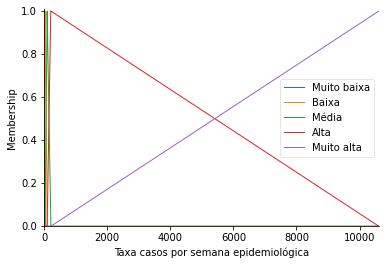

In [326]:
x_taxa_casos = np.arange(df_mobilidade_trabalho_covid_semana_epidemiologica.TAXA_CASOS_NOVOS.min(),
                         df_mobilidade_trabalho_covid_semana_epidemiologica.TAXA_CASOS_NOVOS.max(), 0.1)
antecedent_taxa_casos = ctrl.Antecedent(x_taxa_casos, "Taxa casos por semana epidemiológica")
antecedent_taxa_casos['Muito baixa'] = fuzz.trimf(x_taxa_casos,
    [df_mobilidade_trabalho_covid_semana_epidemiologica.TAXA_CASOS_NOVOS.min(),
     df_mobilidade_trabalho_covid_semana_epidemiologica.TAXA_CASOS_NOVOS.min(),
     df_mobilidade_trabalho_covid_semana_epidemiologica.TAXA_CASOS_NOVOS.quantile(0.25)])
antecedent_taxa_casos['Baixa'] = fuzz.trimf(x_taxa_casos,
    [df_mobilidade_trabalho_covid_semana_epidemiologica.TAXA_CASOS_NOVOS.min(),
     df_mobilidade_trabalho_covid_semana_epidemiologica.TAXA_CASOS_NOVOS.quantile(0.25),
     df_mobilidade_trabalho_covid_semana_epidemiologica.TAXA_CASOS_NOVOS.median()])
antecedent_taxa_casos['Média'] = fuzz.trimf(x_taxa_casos,
    [df_mobilidade_trabalho_covid_semana_epidemiologica.TAXA_CASOS_NOVOS.quantile(0.25),
     df_mobilidade_trabalho_covid_semana_epidemiologica.TAXA_CASOS_NOVOS.median(),
     df_mobilidade_trabalho_covid_semana_epidemiologica.TAXA_CASOS_NOVOS.quantile(0.75)])
antecedent_taxa_casos['Alta'] = fuzz.trimf(x_taxa_casos,
    [df_mobilidade_trabalho_covid_semana_epidemiologica.TAXA_CASOS_NOVOS.median(),
     df_mobilidade_trabalho_covid_semana_epidemiologica.TAXA_CASOS_NOVOS.quantile(0.75),
     df_mobilidade_trabalho_covid_semana_epidemiologica.TAXA_CASOS_NOVOS.max()])
antecedent_taxa_casos['Muito alta'] = fuzz.trimf(x_taxa_casos,
    [df_mobilidade_trabalho_covid_semana_epidemiologica.TAXA_CASOS_NOVOS.quantile(0.75),
     df_mobilidade_trabalho_covid_semana_epidemiologica.TAXA_CASOS_NOVOS.max(),
     df_mobilidade_trabalho_covid_semana_epidemiologica.TAXA_CASOS_NOVOS.max()])
antecedent_taxa_casos.view()

/home/helder/Codigos/Python/scikit-fuzzy/skfuzzy/control/fuzzyvariable.py:125: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


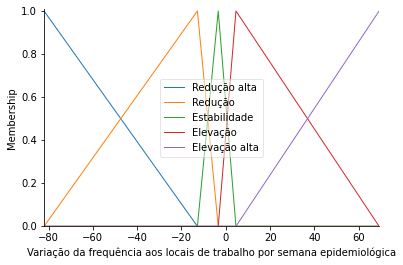

In [327]:
x_variacao_trabalho = np.arange(df_mobilidade_trabalho_covid_semana_epidemiologica.PERCENTUAL_VARIACAO_VISITAS_LOCAIS_TRABALHO.min(),
                         df_mobilidade_trabalho_covid_semana_epidemiologica.PERCENTUAL_VARIACAO_VISITAS_LOCAIS_TRABALHO.max(), 0.1)
antecedent_variacao_trabalho = ctrl.Antecedent(x_variacao_trabalho, "Variação da frequência aos locais de trabalho por semana epidemiológica")
antecedent_variacao_trabalho['Redução alta'] = fuzz.trimf(x_variacao_trabalho,
    [df_mobilidade_trabalho_covid_semana_epidemiologica.PERCENTUAL_VARIACAO_VISITAS_LOCAIS_TRABALHO.min(),
     df_mobilidade_trabalho_covid_semana_epidemiologica.PERCENTUAL_VARIACAO_VISITAS_LOCAIS_TRABALHO.min(),
     df_mobilidade_trabalho_covid_semana_epidemiologica.PERCENTUAL_VARIACAO_VISITAS_LOCAIS_TRABALHO.quantile(0.25)])
antecedent_variacao_trabalho['Redução'] = fuzz.trimf(x_variacao_trabalho,
    [df_mobilidade_trabalho_covid_semana_epidemiologica.PERCENTUAL_VARIACAO_VISITAS_LOCAIS_TRABALHO.min(),
     df_mobilidade_trabalho_covid_semana_epidemiologica.PERCENTUAL_VARIACAO_VISITAS_LOCAIS_TRABALHO.quantile(0.25),
     df_mobilidade_trabalho_covid_semana_epidemiologica.PERCENTUAL_VARIACAO_VISITAS_LOCAIS_TRABALHO.median()])
antecedent_variacao_trabalho['Estabilidade'] = fuzz.trimf(x_variacao_trabalho,
    [df_mobilidade_trabalho_covid_semana_epidemiologica.PERCENTUAL_VARIACAO_VISITAS_LOCAIS_TRABALHO.quantile(0.25),
     df_mobilidade_trabalho_covid_semana_epidemiologica.PERCENTUAL_VARIACAO_VISITAS_LOCAIS_TRABALHO.median(),
     df_mobilidade_trabalho_covid_semana_epidemiologica.PERCENTUAL_VARIACAO_VISITAS_LOCAIS_TRABALHO.quantile(0.75)])
antecedent_variacao_trabalho['Elevação'] = fuzz.trimf(x_variacao_trabalho,
    [df_mobilidade_trabalho_covid_semana_epidemiologica.PERCENTUAL_VARIACAO_VISITAS_LOCAIS_TRABALHO.median(),
     df_mobilidade_trabalho_covid_semana_epidemiologica.PERCENTUAL_VARIACAO_VISITAS_LOCAIS_TRABALHO.quantile(0.75),
     df_mobilidade_trabalho_covid_semana_epidemiologica.PERCENTUAL_VARIACAO_VISITAS_LOCAIS_TRABALHO.max()])
antecedent_variacao_trabalho['Elevação alta'] = fuzz.trimf(x_variacao_trabalho,
    [df_mobilidade_trabalho_covid_semana_epidemiologica.PERCENTUAL_VARIACAO_VISITAS_LOCAIS_TRABALHO.quantile(0.75),
     df_mobilidade_trabalho_covid_semana_epidemiologica.PERCENTUAL_VARIACAO_VISITAS_LOCAIS_TRABALHO.max(),
     df_mobilidade_trabalho_covid_semana_epidemiologica.PERCENTUAL_VARIACAO_VISITAS_LOCAIS_TRABALHO.max()])
antecedent_variacao_trabalho.view()

/home/helder/Codigos/Python/scikit-fuzzy/skfuzzy/control/fuzzyvariable.py:125: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


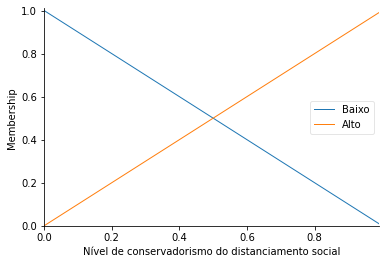

In [328]:
consequent_nivel_conservadorismo_resposta = ctrl.Consequent(np.arange(0, 1, 0.01), "Nível de conservadorismo do distanciamento social")
consequent_nivel_conservadorismo_resposta['Baixo'] = fuzz.trimf(consequent_nivel_conservadorismo_resposta.universe, [0, 0, 1])
consequent_nivel_conservadorismo_resposta['Alto'] = fuzz.trimf(consequent_nivel_conservadorismo_resposta.universe, [0, 1, 1])
consequent_nivel_conservadorismo_resposta.view()

In [329]:
regra_1 = ctrl.Rule(
    (antecedent_taxa_casos['Muito alta'] & antecedent_variacao_trabalho['Redução alta']),
    consequent_nivel_conservadorismo_resposta['Alto'])
regra_2 = ctrl.Rule(
    (antecedent_taxa_casos['Alta'] & (antecedent_variacao_trabalho['Redução'] | antecedent_variacao_trabalho['Redução alta'])),
    consequent_nivel_conservadorismo_resposta['Alto'])
regra_3 = ctrl.Rule(
    (antecedent_taxa_casos['Média'] & (antecedent_variacao_trabalho['Redução'] | antecedent_variacao_trabalho['Redução alta'])),
    consequent_nivel_conservadorismo_resposta['Alto'])
regra_4 = ctrl.Rule(
    (antecedent_taxa_casos['Baixa'] & (antecedent_variacao_trabalho['Redução'] | antecedent_variacao_trabalho['Redução alta'])),
    consequent_nivel_conservadorismo_resposta['Alto'])
regra_5 = ctrl.Rule(
    (antecedent_taxa_casos['Muito baixa'] & (
            antecedent_variacao_trabalho['Elevação'] |
            antecedent_variacao_trabalho['Estabilidade'] |
            antecedent_variacao_trabalho['Redução'] |
            antecedent_variacao_trabalho['Redução alta'])),
    consequent_nivel_conservadorismo_resposta['Alto'])
regra_6 = ctrl.Rule(
    (antecedent_taxa_casos['Muito alta'] & (antecedent_variacao_trabalho['Redução'] |
                                            antecedent_variacao_trabalho['Estabilidade'] |
                                            antecedent_variacao_trabalho['Elevação'] |
                                            antecedent_variacao_trabalho['Elevação alta'])),
    consequent_nivel_conservadorismo_resposta['Baixo'])
regra_7 = ctrl.Rule(
    (antecedent_taxa_casos['Alta'] & (antecedent_variacao_trabalho['Estabilidade'] |
                                            antecedent_variacao_trabalho['Elevação'] |
                                            antecedent_variacao_trabalho['Elevação alta'])),
    consequent_nivel_conservadorismo_resposta['Baixo'])
regra_8 = ctrl.Rule(
    (antecedent_taxa_casos['Média'] & (antecedent_variacao_trabalho['Estabilidade'] |
                                       antecedent_variacao_trabalho['Elevação'] |
                                       antecedent_variacao_trabalho['Elevação alta'])),
    consequent_nivel_conservadorismo_resposta['Baixo'])
regra_9 = ctrl.Rule(
    (antecedent_taxa_casos['Baixa'] & (antecedent_variacao_trabalho['Estabilidade'] |
                                       antecedent_variacao_trabalho['Elevação'] |
                                       antecedent_variacao_trabalho['Elevação alta'])),
    consequent_nivel_conservadorismo_resposta['Baixo'])
regra_10 = ctrl.Rule(
    (antecedent_taxa_casos['Muito baixa'] & antecedent_variacao_trabalho['Elevação alta']),
    consequent_nivel_conservadorismo_resposta['Alto'])

control_system = ctrl.ControlSystem(
    rules = [regra_1, regra_2, regra_3, regra_4, regra_5, regra_6, regra_7, regra_8, regra_9, regra_10])
simulation = ctrl.ControlSystemSimulation(control_system)

In [330]:
# df_mobilidade_trabalho_covid_semana_epidemiologica['INDICE_NIVEL_CONSERVADORISMO_VARIACAO_TRABALHO'] = None
# for index, row in df_mobilidade_trabalho_covid_semana_epidemiologica.iterrows():
#     simulation.input["Taxa casos por semana epidemiológica"] = row['TAXA_CASOS_NOVOS']
#     simulation.input["Variação da frequência aos locais de trabalho por semana epidemiológica"] = row['PERCENTUAL_VARIACAO_VISITAS_LOCAIS_TRABALHO']
#     simulation.compute()
#     df_mobilidade_trabalho_covid_semana_epidemiologica.loc[index, 'INDICE_NIVEL_CONSERVADORISMO_VARIACAO_TRABALHO'] = \
#         simulation.output['Nível de conservadorismo do distanciamento social']
#
# df_mobilidade_trabalho_covid_semana_epidemiologica['INDICE_NIVEL_CONSERVADORISMO_VARIACAO_TRABALHO'] = \
#     df_mobilidade_trabalho_covid_semana_epidemiologica.INDICE_NIVEL_CONSERVADORISMO_VARIACAO_TRABALHO.astype(float)
#
# df_mobilidade_trabalho_covid_semana_epidemiologica.to_csv('dados/df_mobilidade_trabalho_covid_semana_epidemiologica.csv', index=False)

In [331]:
df_mobilidade_trabalho_covid_semana_epidemiologica = pd.read_csv('dados/df_mobilidade_trabalho_covid_semana_epidemiologica.csv')
df_mobilidade_trabalho_covid_semana_epidemiologica.CODIGO_MUNICIPIO_6 = \
    df_mobilidade_trabalho_covid_semana_epidemiologica.CODIGO_MUNICIPIO_6.astype(int).astype(str)

In [332]:
df_mobilidade_trabalho_covid_media = df_mobilidade_trabalho_covid_semana_epidemiologica.groupby('CODIGO_MUNICIPIO_6').mean()[
    ['INDICE_NIVEL_CONSERVADORISMO_VARIACAO_TRABALHO']]
df_mobilidade_trabalho_covid_media = df_mobilidade_trabalho_covid_media.reset_index()
df_mobilidade_trabalho_covid_media.columns = ['CODIGO_MUNICIPIO_6', 'MEDIA_INDICE_NIVEL_CONSERVADORISMO_VARIACAO_TRABALHO']
df_base = pd.merge(df_base, df_mobilidade_trabalho_covid_media, how='left', on='CODIGO_MUNICIPIO_6')

df_mobilidade_trabalho_covid_mediana = df_mobilidade_trabalho_covid_semana_epidemiologica.groupby('CODIGO_MUNICIPIO_6').median()[
    ['INDICE_NIVEL_CONSERVADORISMO_VARIACAO_TRABALHO']]
df_mobilidade_trabalho_covid_mediana = df_mobilidade_trabalho_covid_mediana.reset_index()
df_mobilidade_trabalho_covid_mediana.columns = ['CODIGO_MUNICIPIO_6', 'MEDIANA_INDICE_NIVEL_CONSERVADORISMO_VARIACAO_TRABALHO']
df_base = pd.merge(df_base, df_mobilidade_trabalho_covid_mediana, how='left', on='CODIGO_MUNICIPIO_6')

df_mobilidade_trabalho_covid_3_quartile = df_mobilidade_trabalho_covid_semana_epidemiologica.groupby('CODIGO_MUNICIPIO_6').quantile(0.75)[
    ['INDICE_NIVEL_CONSERVADORISMO_VARIACAO_TRABALHO']]
df_mobilidade_trabalho_covid_3_quartile = df_mobilidade_trabalho_covid_3_quartile.reset_index()
df_mobilidade_trabalho_covid_3_quartile.columns = ['CODIGO_MUNICIPIO_6', 'QUARTILE_3_INDICE_NIVEL_CONSERVADORISMO_VARIACAO_TRABALHO']
df_base = pd.merge(df_base, df_mobilidade_trabalho_covid_3_quartile, how='left', on='CODIGO_MUNICIPIO_6')

#### Creating new attributes

In [333]:
df_base['TAXA_CASOS'] = df_base.CASOS / df_base.POPULACAO_ESTIMADA * 100000
df_base['TAXA_OBITOS'] = df_base.OBITOS / df_base.POPULACAO_ESTIMADA * 100000
df_base['TAXA_LETALIDADE'] = df_base.OBITOS / df_base.CASOS * 100
df_base['RAZAO_POPULACAO_MASCULINA_FEMININA'] = df_base.POPULACAO_MASCULINA / df_base.POPULACAO_FEMININA
df_base['RAZAO_POPULACAO_RURAL_URBANA'] = df_base.POPULACAO_RURAL / df_base.POPULACAO_URBANA
df_base['PERCENTUAL_POPULACAO_URBANA'] = df_base.POPULACAO_URBANA / df_base.POPULACAO_TOTAL * 100
df_base['PERCENTUAL_POPULACAO_SEDE_MUNICIPAL'] = df_base.POPULACAO_SEDE_MUNICIPAL / df_base.POPULACAO_TOTAL * 100
df_base['PERCENTUAL_POPULACAO_17_ANOS_OU_MENOS'] = \
    (df_base.POPULACAO_ATE_1_ANO + df_base.POPULACAO_1_A_3_ANOS + df_base.POPULACAO_4_ANOS + df_base.POPULACAO_5_ANOS +
     df_base.POPULACAO_6_A_10_ANOS + df_base.POPULACAO_11_A_14_ANOS + df_base.POPULACAO_15_A_17_ANOS) / df_base.POPULACAO_TOTAL * 100
df_base['PERCENTUAL_POPULACAO_18_ATE_39_ANOS'] = (df_base.POPULACAO_18_ANOS_OU_MAIS / df_base.POPULACAO_TOTAL * 100) - df_base.PERCENTUAL_POPULACAO_40_A_59_ANOS - df_base.PERCENTUAL_POPULACAO_60_ANOS_OU_MAIS
df_base['DENSIDADE_DOMICILIOS'] = df_base.DOMICILIOS_PARTICULARES_OCUPADOS / df_base.AREA
df_base['PERCENTUAL_DOMICILIOS_AGLOMERADOS'] = df_base.DOMICILIOS_PARTICULARES_OCUPADOS_AGLOMERADOS / df_base.DOMICILIOS_PARTICULARES_OCUPADOS * 100
df_base['PERCENTUAL_POPULACAO_AGLOMERADOS'] = df_base.POPULACAO_AGLOMERADOS / df_base.POPULACAO_TOTAL * 100
df_base['DENSIDADE_DOMICILIOS_ESTIMADA'] = df_base.DOMICILIOS_PARTICULARES_OCUPADOS_ESTIMADO / df_base.AREA
df_base['TOTAL_VOTOS'] = df_base.VOTOS_BOLSONARO + df_base.VOTOS_HADDAD + df_base.VOTOS_NULO + df_base.VOTOS_BRANCO
df_base['PERCENTUAL_VOTOS_BOLSONARO'] = df_base.VOTOS_BOLSONARO / df_base.TOTAL_VOTOS * 100
df_base['PERCENTUAL_VOTOS_HADDAD'] = df_base.VOTOS_HADDAD / df_base.TOTAL_VOTOS * 100
df_base['TAXA_LEITOS_INTERNACAO_TOTAL_2019_12'] = df_base.LEITOS_INTERNACAO_TOTAL_2019_12 / df_base.POPULACAO_ESTIMADA * 100000
df_base['TAXA_LEITOS_UTI_TOTAL_2019_12'] = df_base.LEITOS_UTI_TOTAL_2019_12 / df_base.POPULACAO_ESTIMADA * 100000
df_base['TAXA_MEDICOS_TOTAL_2019_12'] = df_base.MEDICOS_TOTAL_2019_12 / df_base.POPULACAO_ESTIMADA * 100000
df_base['TAXA_ENFERMEIROS_TOTAL_2019_12'] = df_base.ENFERMEIROS_TOTAL_2019_12 / df_base.POPULACAO_ESTIMADA * 100000
df_base['TAXA_VENTILADORES_REPIRADORES_EM_USO_2019_12'] = df_base.VENTILADORES_RESPIRADORES_EM_USO_2019_12 / df_base.POPULACAO_ESTIMADA * 100000
df_base['TAXA_LEITOS_INTERNACAO_TOTAL_2019_12_REGIAO_IMEDIATA'] = df_base.LEITOS_INTERNACAO_TOTAL_2019_12_REGIAO_IMEDIATA / df_base.POPULACAO_ESTIMADA_REGIAO_IMEDIATA * 100000
df_base['TAXA_LEITOS_UTI_TOTAL_2019_12_REGIAO_IMEDIATA'] = df_base.LEITOS_UTI_TOTAL_2019_12_REGIAO_IMEDIATA / df_base.POPULACAO_ESTIMADA_REGIAO_IMEDIATA * 100000
df_base['TAXA_MEDICOS_TOTAL_2019_12_REGIAO_IMEDIATA'] = df_base.MEDICOS_TOTAL_2019_12_REGIAO_IMEDIATA / df_base.POPULACAO_ESTIMADA_REGIAO_IMEDIATA * 100000
df_base['TAXA_ENFERMEIROS_TOTAL_2019_12_REGIAO_IMEDIATA'] = df_base.ENFERMEIROS_TOTAL_2019_12_REGIAO_IMEDIATA / df_base.POPULACAO_ESTIMADA_REGIAO_IMEDIATA * 100000
df_base['TAXA_VENTILADORES_REPIRADORES_EM_USO_2019_12_REGIAO_IMEDIATA'] = df_base.VENTILADORES_RESPIRADORES_EM_USO_2019_12_REGIAO_IMEDIATA / df_base.POPULACAO_ESTIMADA_REGIAO_IMEDIATA * 100000
df_base['TAXA_LEITOS_INTERNACAO_TOTAL_2019_12_REGIAO_INTERMEDIARIA'] = df_base.LEITOS_INTERNACAO_TOTAL_2019_12_REGIAO_INTERMEDIARIA / df_base.POPULACAO_ESTIMADA_REGIAO_INTERMEDIARIA * 100000
df_base['TAXA_LEITOS_UTI_TOTAL_2019_12_REGIAO_INTERMEDIARIA'] = df_base.LEITOS_UTI_TOTAL_2019_12_REGIAO_INTERMEDIARIA / df_base.POPULACAO_ESTIMADA_REGIAO_INTERMEDIARIA * 100000
df_base['TAXA_MEDICOS_TOTAL_2019_12_REGIAO_INTERMEDIARIA'] = df_base.MEDICOS_TOTAL_2019_12_REGIAO_INTERMEDIARIA / df_base.POPULACAO_ESTIMADA_REGIAO_INTERMEDIARIA * 100000
df_base['TAXA_ENFERMEIROS_TOTAL_2019_12_REGIAO_INTERMEDIARIA'] = df_base.ENFERMEIROS_TOTAL_2019_12_REGIAO_INTERMEDIARIA / df_base.POPULACAO_ESTIMADA_REGIAO_INTERMEDIARIA * 100000
df_base['TAXA_VENTILADORES_RESPIRADORES_EM_USO_2019_12_REGIAO_INTERMEDIARIA'] = df_base.VENTILADORES_RESPIRADORES_EM_USO_2019_12_REGIAO_INTERMEDIARIA / df_base.POPULACAO_ESTIMADA_REGIAO_INTERMEDIARIA * 100000

#### Analizing the attributes

In [334]:
taxa_obitos_brasil = df_base.OBITOS.sum() / df_base.POPULACAO_ESTIMADA.sum() * 100000
print('Taxa de óbitos no Brasil: '+ str(taxa_obitos_brasil))

df_regioes_brasil = df_base.groupby('REGIAO').sum()[['OBITOS','POPULACAO_ESTIMADA']]
df_regioes_brasil['TAXA_OBITOS'] = df_regioes_brasil.OBITOS / df_regioes_brasil.POPULACAO_ESTIMADA * 100000
print(df_regioes_brasil)

df_estados_brasil = df_base.groupby('ESTADO').sum()[['OBITOS','POPULACAO_ESTIMADA']]
df_estados_brasil['TAXA_OBITOS'] = df_estados_brasil.OBITOS / df_estados_brasil.POPULACAO_ESTIMADA * 100000
print(df_estados_brasil)

Taxa de óbitos no Brasil: 271.0110833065168
              OBITOS  POPULACAO_ESTIMADA  TAXA_OBITOS
REGIAO                                               
Centro-Oeste   53883            16297074   330.629903
Nordeste      113969            57071654   199.694580
Norte          45644            18430980   247.648253
Sudeste       267433            88371433   302.623813
Sul            88593            29975984   295.546595
                     OBITOS  POPULACAO_ESTIMADA  TAXA_OBITOS
ESTADO                                                      
Acre                   1808              881935   205.003770
Alagoas                5974             3337357   179.003924
Amapá                  1941              845731   229.505599
Amazonas              13639             4144597   329.079040
Bahia                 25894            14873064   174.099970
Ceará                 23859             9132078   261.265837
Distrito Federal       9849             3015268   326.637632
Espírito Santo        11873  

array([[<AxesSubplot:title={'center':'TAXA_LEITOS_UTI_COVID_TOTAL_2020_06_REGIAO_INTERMEDIARIA'}, xlabel='[REGIAO]'>,
        <AxesSubplot:title={'center':'TAXA_LEITOS_UTI_COVID_TOTAL_2020_12_REGIAO_INTERMEDIARIA'}, xlabel='[REGIAO]'>],
       [<AxesSubplot:title={'center':'TAXA_LEITOS_UTI_COVID_TOTAL_2021_06_REGIAO_INTERMEDIARIA'}, xlabel='[REGIAO]'>,
        <AxesSubplot:>]], dtype=object)

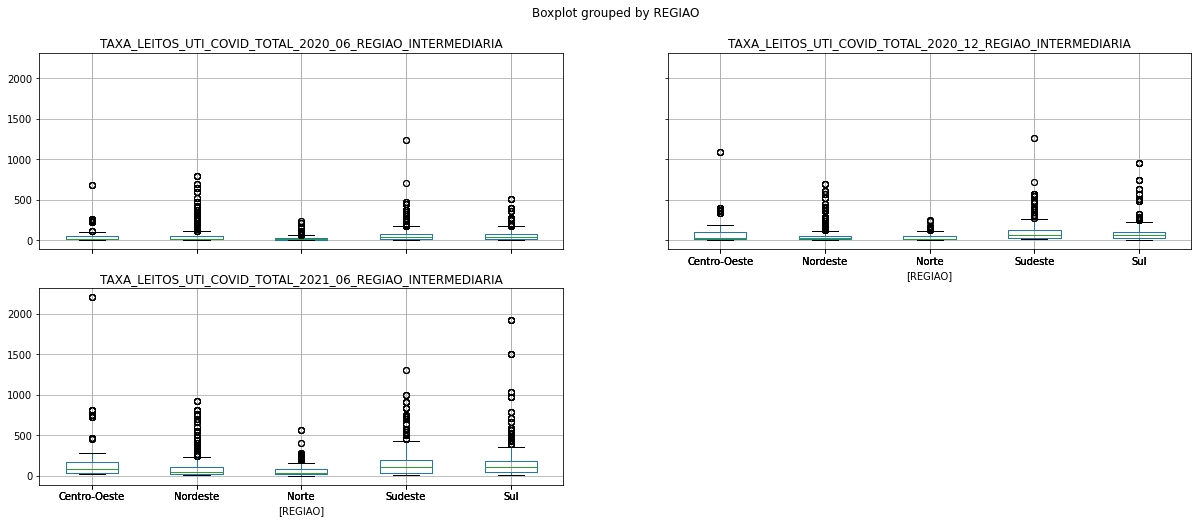

In [335]:
df_base[["TAXA_LEITOS_UTI_COVID_TOTAL_2020_06_REGIAO_INTERMEDIARIA",
         "TAXA_LEITOS_UTI_COVID_TOTAL_2020_12_REGIAO_INTERMEDIARIA",
         "TAXA_LEITOS_UTI_COVID_TOTAL_2021_06_REGIAO_INTERMEDIARIA", 'REGIAO']].boxplot(by='REGIAO', figsize=(20,8))

In [336]:
from IPython.display import display

def show_analisys_attribute(df, attribute):
    display(df)
    display(df.describe())

    df[attribute].hist(legend=True)
    plt.show()
    df.boxplot(column=[attribute])
    plt.show()
    df[attribute].hist(by=df_base.REGIAO)
    plt.show()
    df[[attribute,'REGIAO']].boxplot(by='REGIAO')
    plt.show()
    ax = plt.figure(figsize = (15,20)).gca()
    df[attribute].hist(by=df_base.ESTADO, ax=ax)
    plt.show()
    df[[attribute,'SIGLA_ESTADO']].boxplot(by='SIGLA_ESTADO', figsize=(20,8))
    plt.show()
    df_mg = df[df['SIGLA_ESTADO'] == 'MG']
    ax = plt.figure(figsize = (15,20)).gca()
    df_mg[attribute].hist(by=df_mg.REGIAO_INTERMEDIARIA, ax=ax)
    plt.show()
    df_mg[[attribute,'REGIAO_INTERMEDIARIA']].boxplot(by='REGIAO_INTERMEDIARIA', figsize=(20,8))
    plt.show()
    df_regiao_moc = df[df.REGIAO_INTERMEDIARIA == 'Montes Claros']
    ax = plt.figure(figsize = (15,20)).gca()
    df_regiao_moc[attribute].hist(by=df_regiao_moc.REGIAO_IMEDIATA, ax=ax)
    plt.show()
    df_regiao_moc[[attribute,'REGIAO_IMEDIATA']].boxplot(by='REGIAO_IMEDIATA', figsize=(20,8))
    plt.show()

,MUNICIPIO,CODIGO_MUNICIPIO_6,SIGLA_ESTADO,CODIGO_ESTADO,REGIAO,REGIAO_SAUDE,CODIGO_REGIAO_SAUDE,REGIAO_METROPOLITANA,CASOS,OBITOS,...,TAXA_LEITOS_INTERNACAO_TOTAL_2019_12_REGIAO_IMEDIATA,TAXA_LEITOS_UTI_TOTAL_2019_12_REGIAO_IMEDIATA,TAXA_MEDICOS_TOTAL_2019_12_REGIAO_IMEDIATA,TAXA_ENFERMEIROS_TOTAL_2019_12_REGIAO_IMEDIATA,TAXA_VENTILADORES_REPIRADORES_EM_USO_2019_12_REGIAO_IMEDIATA,TAXA_LEITOS_INTERNACAO_TOTAL_2019_12_REGIAO_INTERMEDIARIA,TAXA_LEITOS_UTI_TOTAL_2019_12_REGIAO_INTERMEDIARIA,TAXA_MEDICOS_TOTAL_2019_12_REGIAO_INTERMEDIARIA,TAXA_ENFERMEIROS_TOTAL_2019_12_REGIAO_INTERMEDIARIA,TAXA_VENTILADORES_RESPIRADORES_EM_USO_2019_12_REGIAO_INTERMEDIARIA
0,Alta Floresta D'Oeste,110001,RO,11,Norte,ZONA DA MATA,11005.0,0.0,4040.0,65,...,40.589951,3.247196,157.813728,120.146254,12.988784,36.482895,2.183835,127.561671,99.171813,11.433020
1,Ariquemes,110002,RO,11,Norte,VALE DO JAMARI,11001.0,0.0,22424.0,493,...,54.239894,11.958402,85.417156,71.323325,20.927203,60.373777,12.615416,153.988174,115.040580,28.634992
2,Cabixi,110003,RO,11,Norte,CONE SUL,11006.0,0.0,886.0,21,...,12.016722,0.000000,130.286567,111.312795,10.119345,36.482895,2.183835,127.561671,99.171813,11.433020
3,Cacoal,110004,RO,11,Norte,CAFE,11002.0,0.0,14386.0,302,...,40.589951,3.247196,157.813728,120.146254,12.988784,36.482895,2.183835,127.561671,99.171813,11.433020
4,Cerejeiras,110005,RO,11,Norte,CONE SUL,11006.0,0.0,2514.0,61,...,12.016722,0.000000,130.286567,111.312795,10.119345,36.482895,2.183835,127.561671,99.171813,11.433020
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5565,Vianópolis,522200,GO,52,Centro-Oeste,CENTRO SUL,52002.0,0.0,901.0,33,...,86.453458,7.637806,173.719449,101.404056,13.488040,131.938404,17.916559,234.593248,118.243874,28.200988
5566,Vicentinópolis,522205,GO,52,Centro-Oeste,CENTRO SUL,52002.0,0.0,1349.0,23,...,56.862393,0.000000,65.840666,94.271862,5.985515,74.278132,11.778733,127.162239,85.335718,15.865232
5567,Vila Boa,522220,GO,52,Centro-Oeste,ENTORNO NORTE,52003.0,0.0,197.0,4,...,0.000000,0.000000,63.498111,71.435375,0.000000,30.847536,0.936958,78.632387,64.866314,2.810874
5568,Vila Propício,522230,GO,52,Centro-Oeste,SAO PATRICIO II,52018.0,0.0,388.0,7,...,123.333996,8.752735,140.043764,126.118958,18.699025,111.454539,4.404561,103.794433,104.560444,12.256169


,CODIGO_ESTADO,CODIGO_REGIAO_SAUDE,REGIAO_METROPOLITANA,CASOS,OBITOS,POPULACAO_ESTIMADA,DOMICILIOS_PARTICULARES_OCUPADOS_ESTIMADO,DOMICILIOS_PARTICULARES_OCUPADOS_AGLOMERADOS_ESTIMADO,PERCENTUAL_DOMICILIOS_PARTICULARES_OCUPADOS_AGLOMERADOS_ESTIMADO,CODIGO_REGIAO_IMEDIATA,...,TAXA_LEITOS_INTERNACAO_TOTAL_2019_12_REGIAO_IMEDIATA,TAXA_LEITOS_UTI_TOTAL_2019_12_REGIAO_IMEDIATA,TAXA_MEDICOS_TOTAL_2019_12_REGIAO_IMEDIATA,TAXA_ENFERMEIROS_TOTAL_2019_12_REGIAO_IMEDIATA,TAXA_VENTILADORES_REPIRADORES_EM_USO_2019_12_REGIAO_IMEDIATA,TAXA_LEITOS_INTERNACAO_TOTAL_2019_12_REGIAO_INTERMEDIARIA,TAXA_LEITOS_UTI_TOTAL_2019_12_REGIAO_INTERMEDIARIA,TAXA_MEDICOS_TOTAL_2019_12_REGIAO_INTERMEDIARIA,TAXA_ENFERMEIROS_TOTAL_2019_12_REGIAO_INTERMEDIARIA,TAXA_VENTILADORES_RESPIRADORES_EM_USO_2019_12_REGIAO_INTERMEDIARIA
count,5570.000000,5570.000000,5570.000000,5570.000000,5570.000000,5.570000e+03,5.570000e+03,5570.000000,5570.000000,5570.000000,...,5570.000000,5570.000000,5570.000000,5570.000000,5570.000000,5570.000000,5570.000000,5570.000000,5570.000000,5570.000000
mean,32.377738,32403.123698,0.069300,3658.075943,102.248115,3.772839e+04,1.176968e+04,920.600898,1.043896,323793.462657,...,50.343383,6.197581,141.237603,113.414440,15.886186,57.550806,8.066071,160.989005,120.728879,19.166481
std,9.833862,9837.224401,0.253986,18748.097492,751.917652,2.214581e+05,7.378126e+04,12945.799490,4.509078,98340.639166,...,39.156400,7.144393,79.544378,33.585401,12.407539,31.545535,5.968023,69.462012,25.410903,9.676284
min,11.000000,11001.000000,0.000000,10.000000,0.000000,7.810000e+02,3.190000e+02,0.000000,0.000000,110001.000000,...,0.000000,0.000000,22.013312,35.609769,0.000000,0.000000,0.000000,26.054637,42.183698,0.000000
25%,25.000000,25010.000000,0.000000,444.000000,9.000000,5.446500e+03,1.698500e+03,0.000000,0.000000,250009.000000,...,18.515090,0.000000,75.856192,88.704539,5.544774,29.584962,3.673233,101.476569,102.276793,11.460727
50%,31.000000,31059.000000,0.000000,947.000000,20.000000,1.163100e+04,3.432500e+03,0.000000,0.000000,310039.000000,...,45.158062,3.764139,123.168115,106.120886,14.219747,57.716365,6.780069,165.082655,120.012020,19.725571
75%,41.000000,41015.000000,0.000000,2334.500000,51.000000,2.549050e+04,7.373000e+03,0.000000,0.000000,410019.000000,...,74.347123,9.364962,186.799997,133.714235,23.591634,79.503122,11.428339,203.706986,134.778301,25.414597
max,53.000000,53001.000000,1.000000,924543.000000,36452.000000,1.225202e+07,4.104611e+06,529921.000000,73.993700,530001.000000,...,257.652879,39.664799,490.043880,293.034134,79.658955,136.260269,39.664799,338.145730,226.665023,55.252137


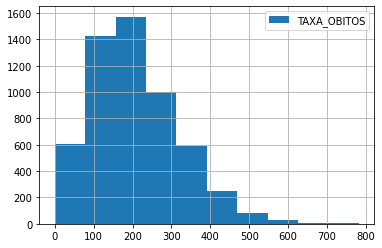

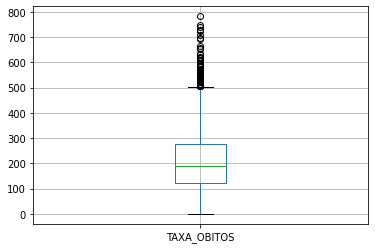

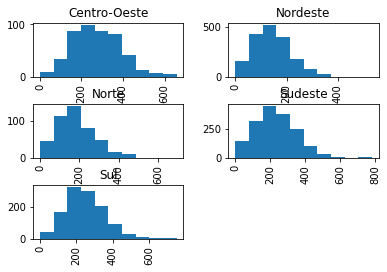

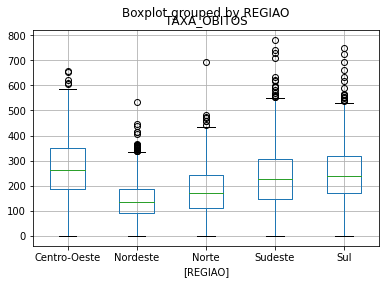

/home/helder/anaconda3/lib/python3.8/site-packages/pandas/plotting/_matplotlib/hist.py:345: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  axes = _grouped_hist(


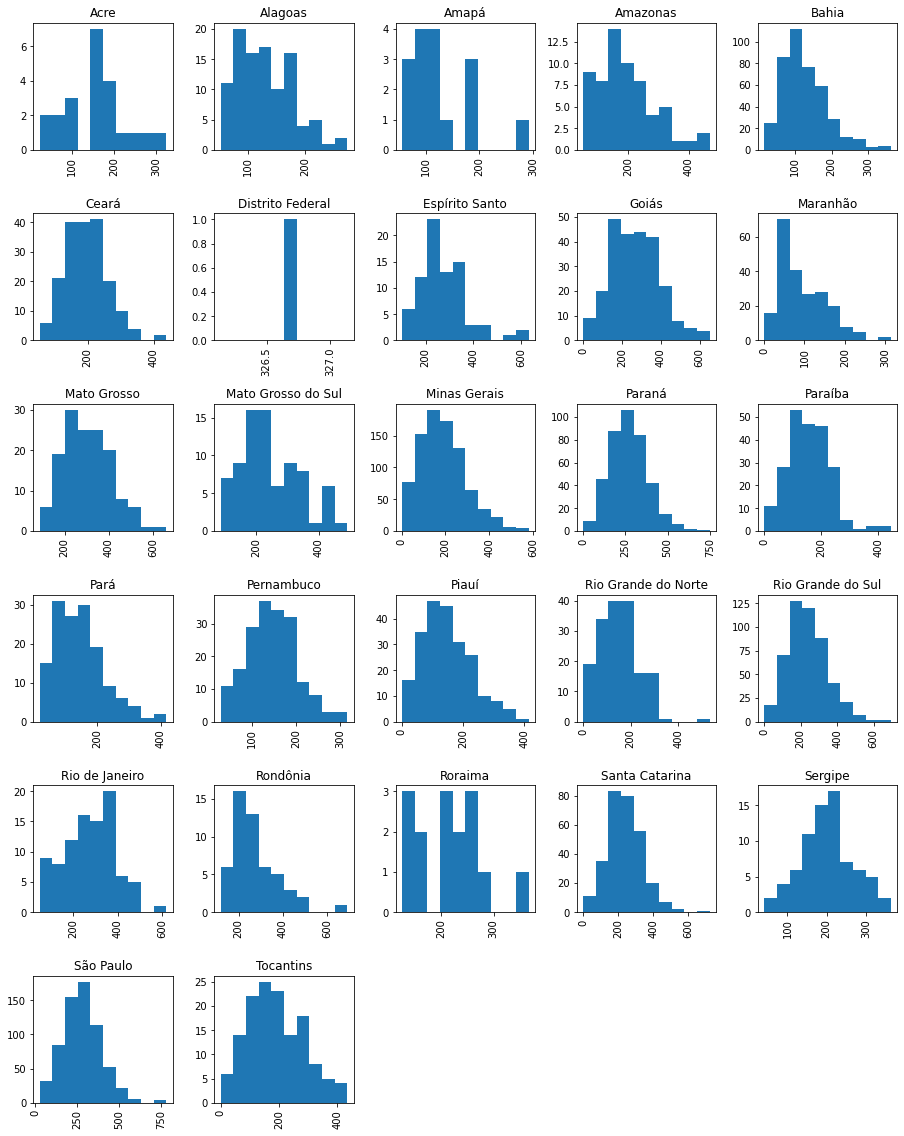

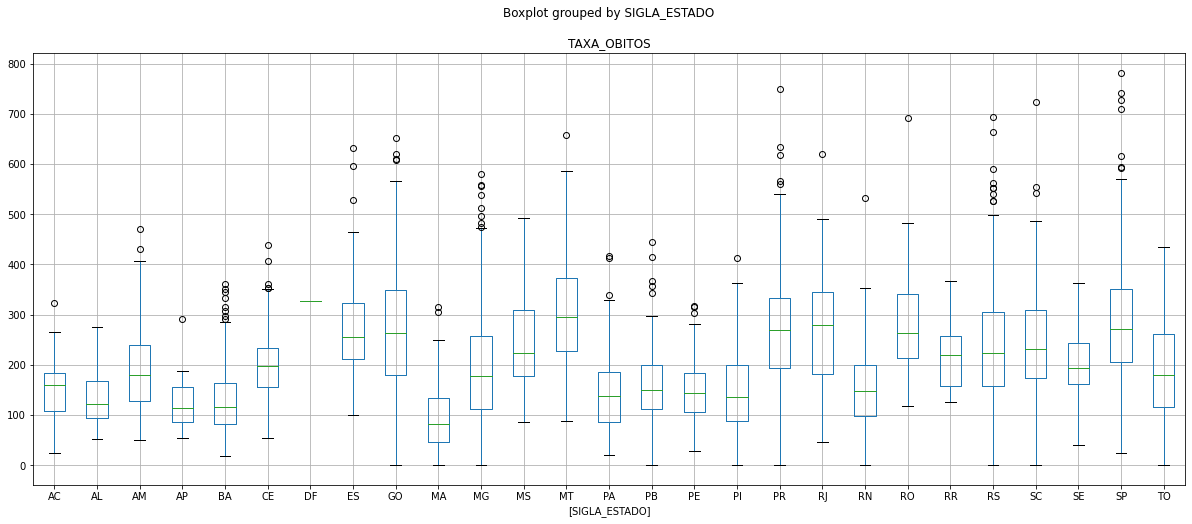

/home/helder/anaconda3/lib/python3.8/site-packages/pandas/plotting/_matplotlib/hist.py:345: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  axes = _grouped_hist(


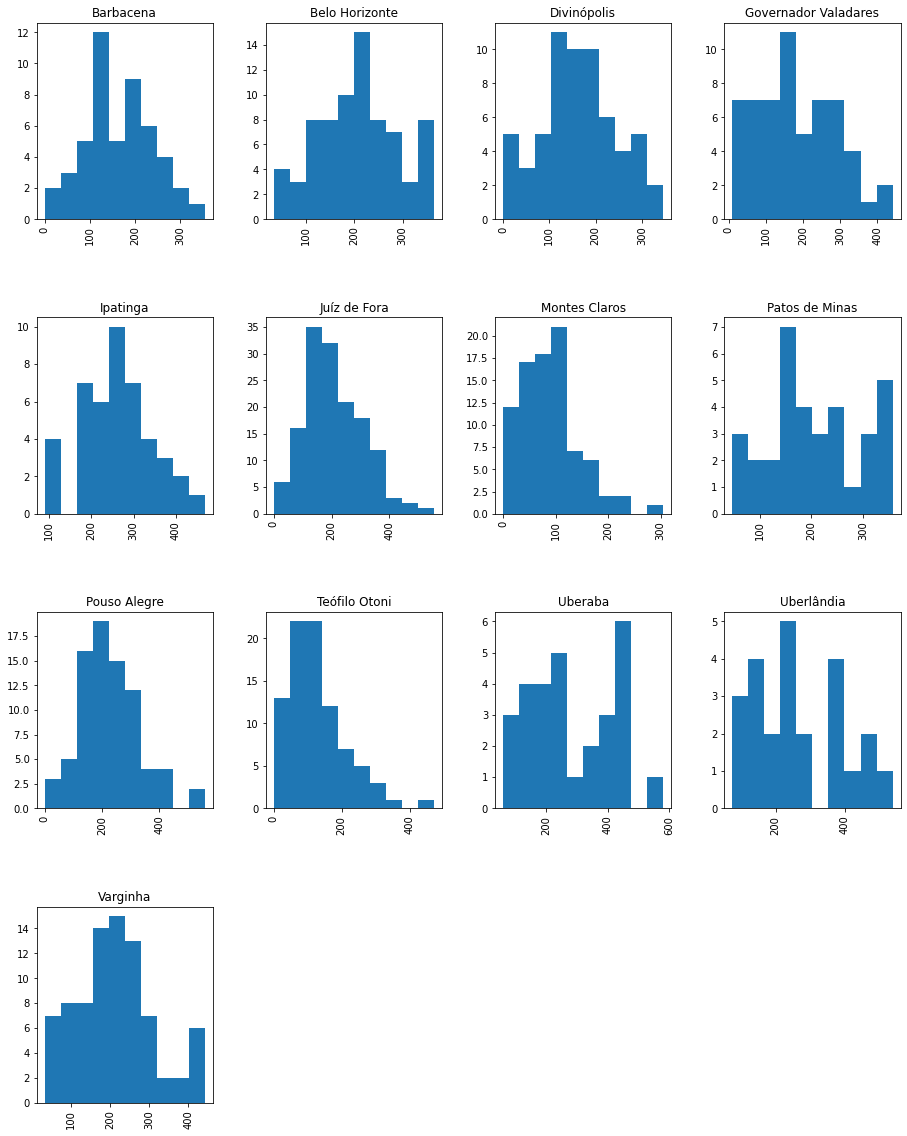

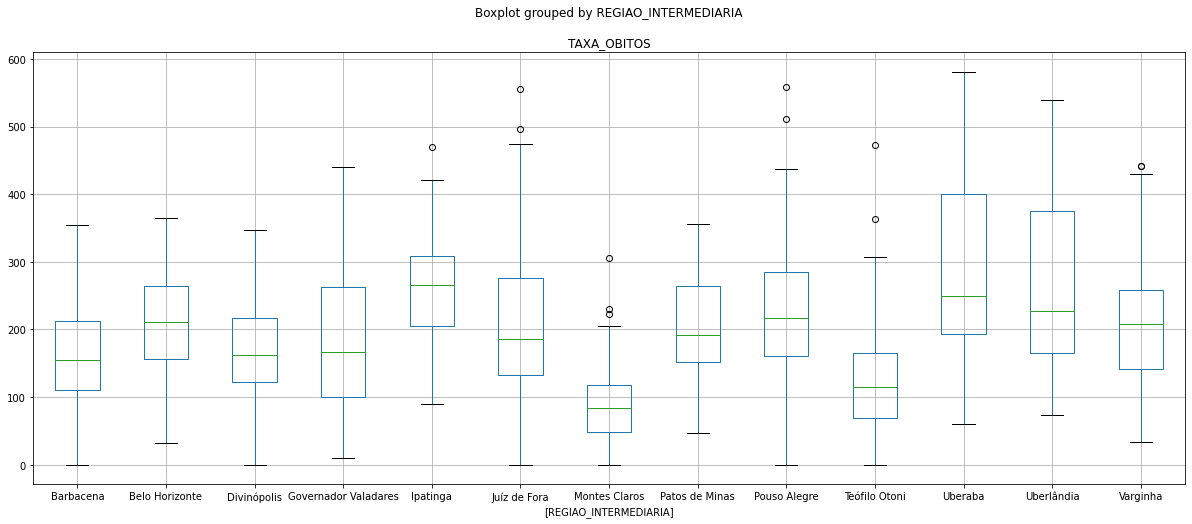

/home/helder/anaconda3/lib/python3.8/site-packages/pandas/plotting/_matplotlib/hist.py:345: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  axes = _grouped_hist(


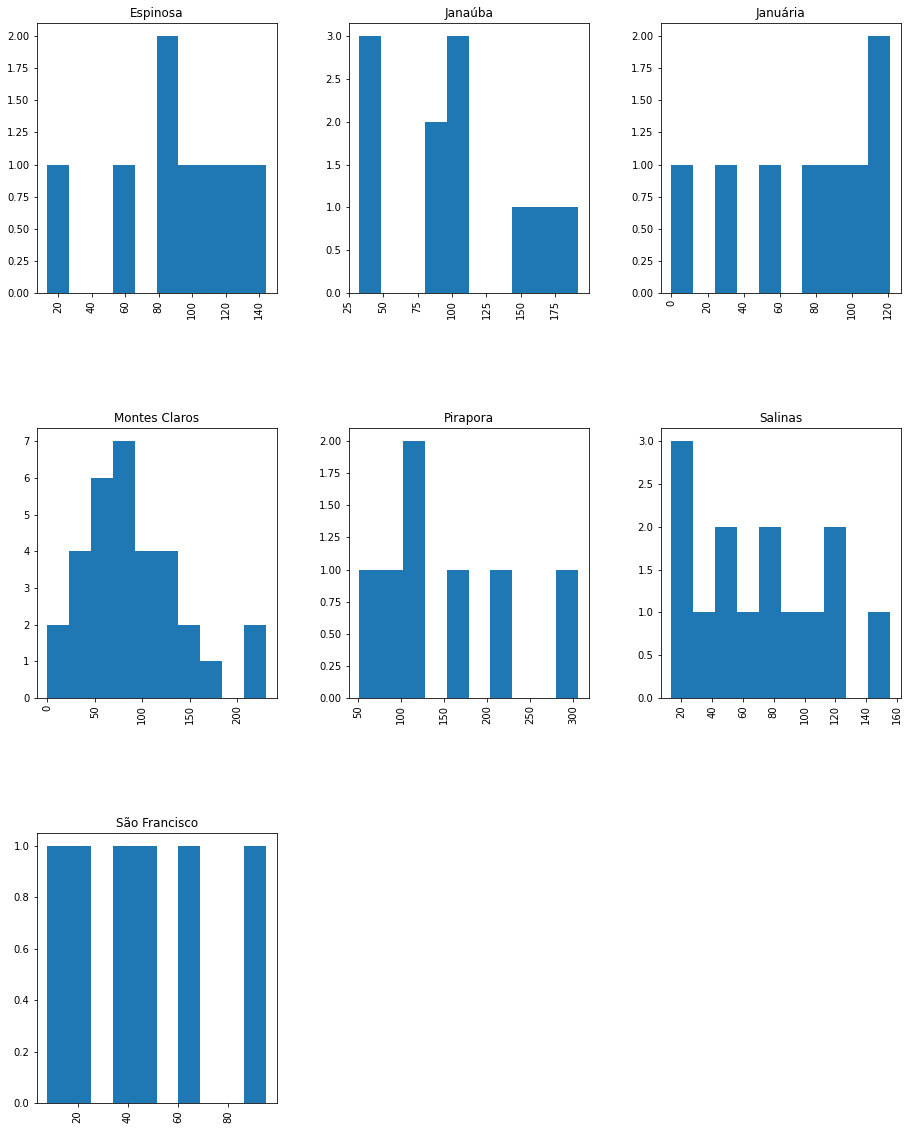

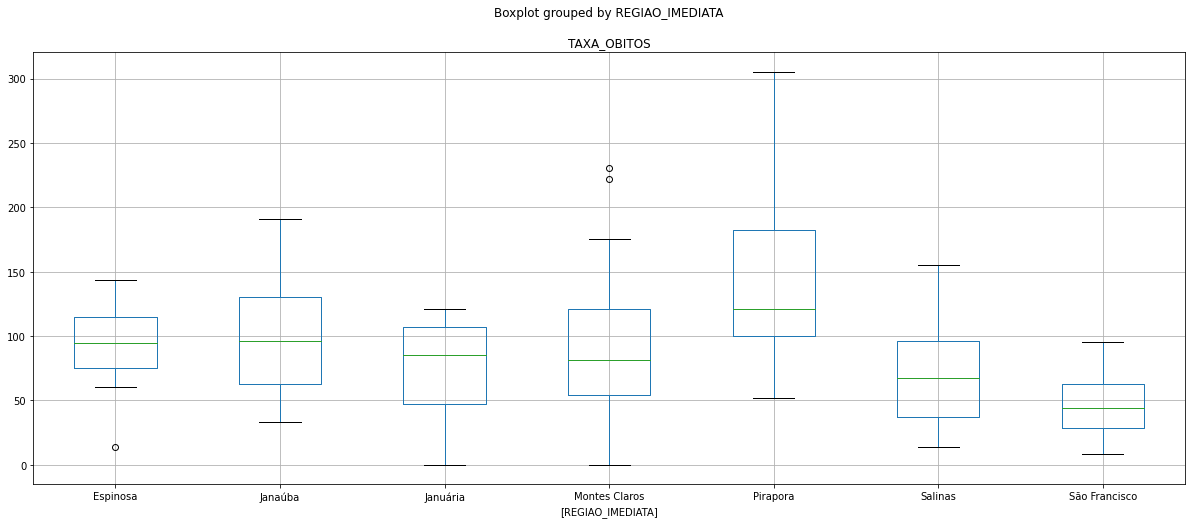

,CODIGO_MUNICIPIO_6,MEDIA_PERCENTUAL_VARIACAO_VISITAS_ESTACAO_TRANSPORTE,MEDIA_PERCENTUAL_VARIACAO_VISITAS_LOCAIS_TRABALHO,MEDIA_PERCENTUAL_VARIACAO_PERMANENCIA_RESIDENCIAS,REGIAO,SIGLA_ESTADO,REGIAO_INTERMEDIARIA,REGIAO_IMEDIATA
0,110001,NaN,10.168254,NaN,Norte,RO,Ji-Paraná,Cacoal
1,110002,NaN,7.459155,9.250704,Norte,RO,Porto Velho,Ariquemes
2,110004,NaN,4.138028,6.405634,Norte,RO,Ji-Paraná,Cacoal
3,110005,NaN,2.174103,NaN,Norte,RO,Ji-Paraná,Vilhena
4,110006,NaN,3.291803,NaN,Norte,RO,Ji-Paraná,Vilhena
...,...,...,...,...,...,...,...,...
2303,522140,-2.374648,-5.839437,12.022535,Centro-Oeste,GO,Goiânia,Goiânia
2304,522160,-44.336992,1.697059,6.772857,Centro-Oeste,GO,Porangatu - Uruaçu,Uruaçu - Niquelândia
2305,522185,13.214706,-8.064789,13.419718,Centro-Oeste,GO,Luziânia - Águas Lindas de Goiás,Luziânia
2306,522200,NaN,-1.069853,NaN,Centro-Oeste,GO,Goiânia,Anápolis


,MEDIA_PERCENTUAL_VARIACAO_VISITAS_ESTACAO_TRANSPORTE,MEDIA_PERCENTUAL_VARIACAO_VISITAS_LOCAIS_TRABALHO,MEDIA_PERCENTUAL_VARIACAO_PERMANENCIA_RESIDENCIAS
count,711.000000,2285.000000,1089.000000
mean,-30.075041,-4.970975,7.864772
std,24.516058,7.271079,4.161562
min,-99.892958,-56.000000,-71.000000
25%,-47.269790,-9.281690,5.989437
50%,-34.432353,-4.738235,8.200000
75%,-18.049296,-0.406557,10.225185
max,102.108578,20.747368,16.885915


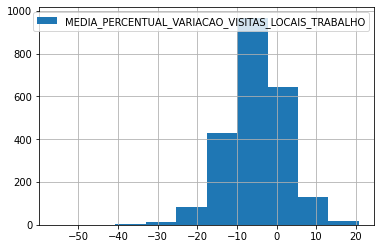

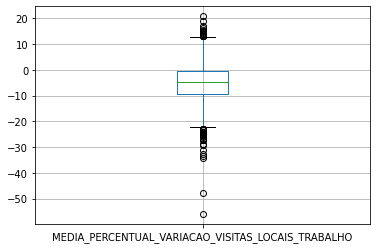

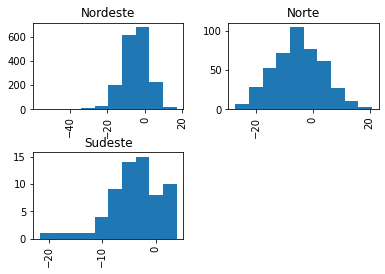

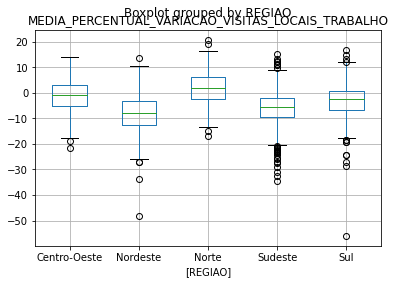

/home/helder/anaconda3/lib/python3.8/site-packages/pandas/plotting/_matplotlib/hist.py:345: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  axes = _grouped_hist(


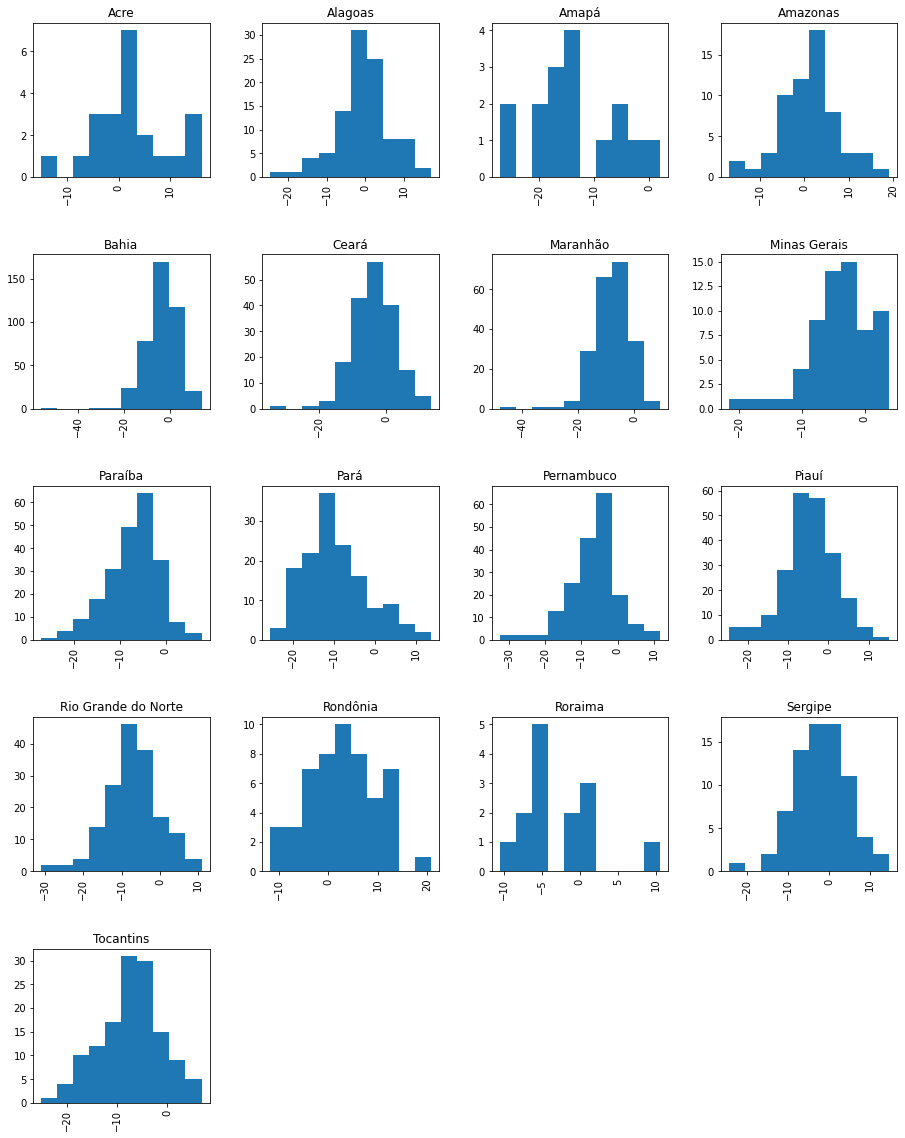

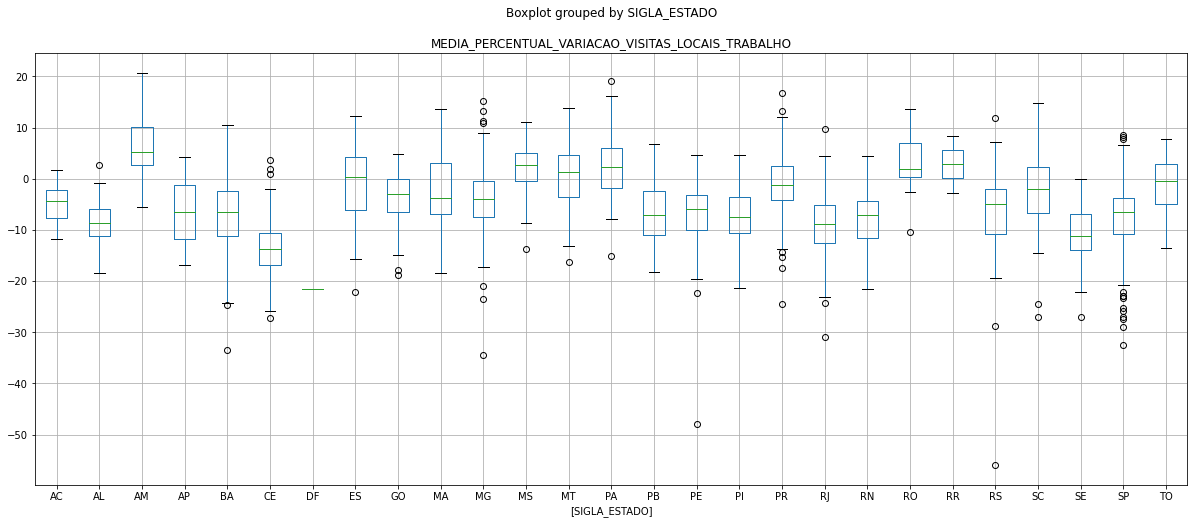

/home/helder/anaconda3/lib/python3.8/site-packages/pandas/plotting/_matplotlib/hist.py:345: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  axes = _grouped_hist(


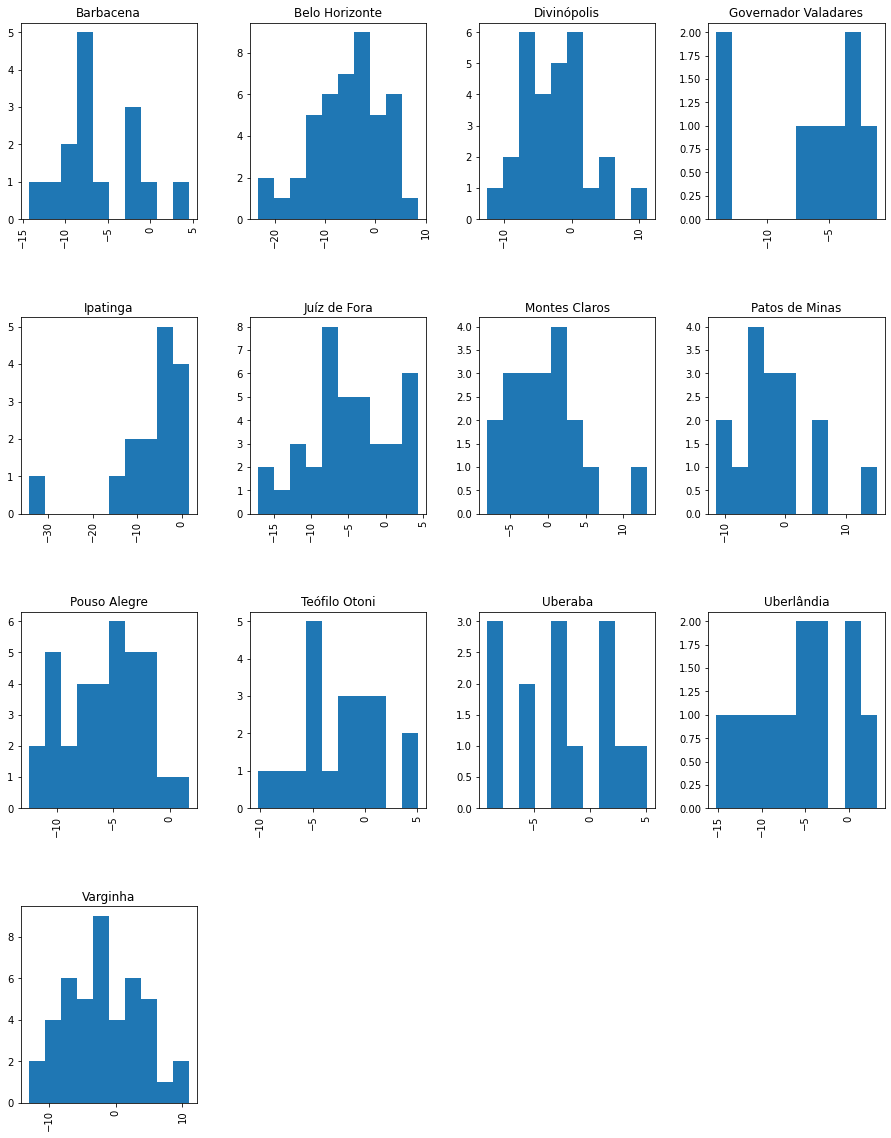

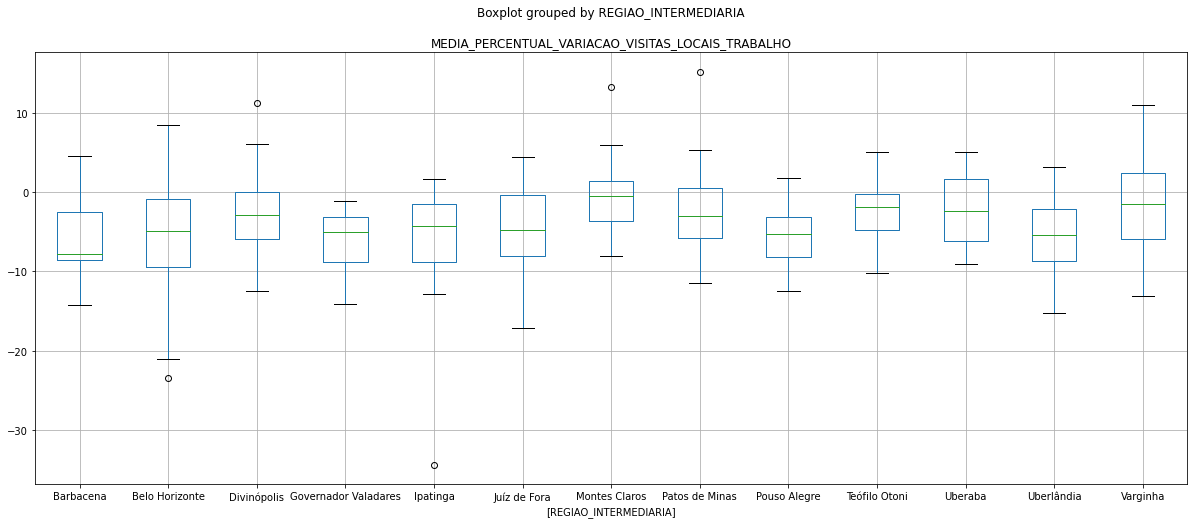

/home/helder/anaconda3/lib/python3.8/site-packages/pandas/plotting/_matplotlib/hist.py:345: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  axes = _grouped_hist(


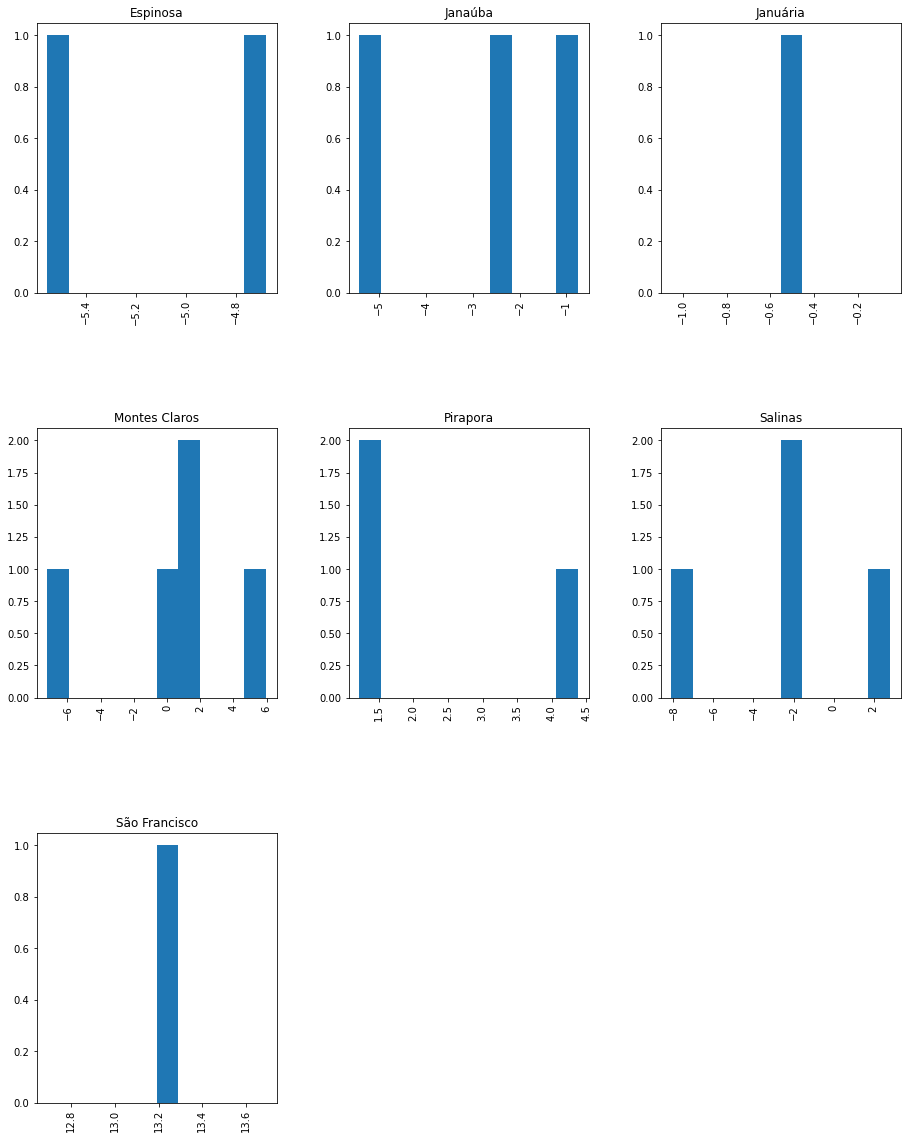

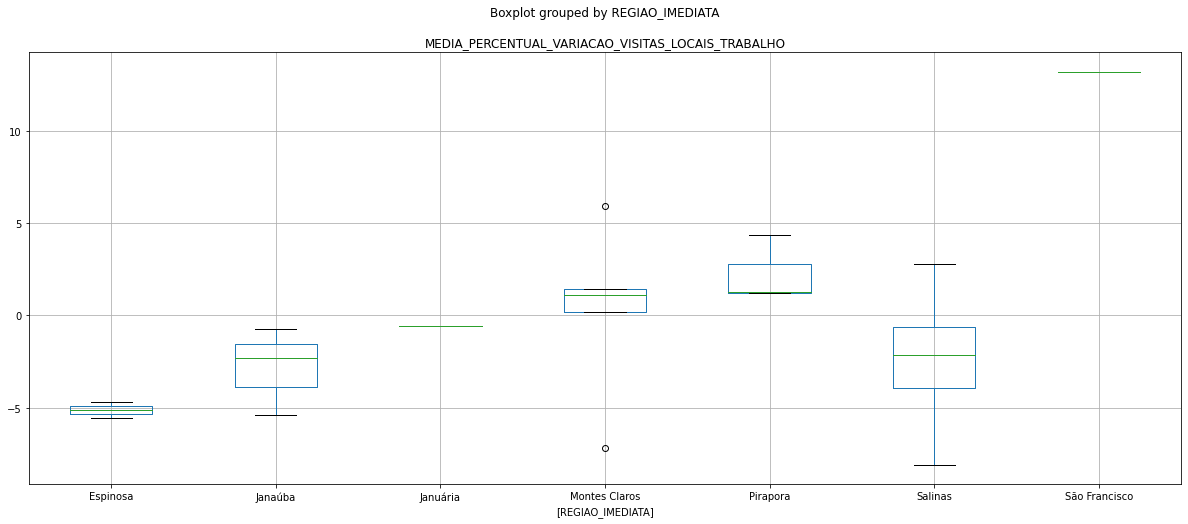

,CODIGO_MUNICIPIO_6,MEDIANA_PERCENTUAL_VARIACAO_VISITAS_ESTACAO_TRANSPORTE,MEDIANA_PERCENTUAL_VARIACAO_VISITAS_LOCAIS_TRABALHO,MEDIANA_PERCENTUAL_VARIACAO_PERMANENCIA_RESIDENCIAS,REGIAO,SIGLA_ESTADO,REGIAO_INTERMEDIARIA,REGIAO_IMEDIATA
0,110001,NaN,12.6,NaN,Norte,RO,Ji-Paraná,Cacoal
1,110002,NaN,10.6,9.0,Norte,RO,Porto Velho,Ariquemes
2,110004,NaN,5.6,6.0,Norte,RO,Ji-Paraná,Cacoal
3,110005,NaN,5.8,NaN,Norte,RO,Ji-Paraná,Vilhena
4,110006,NaN,6.2,NaN,Norte,RO,Ji-Paraná,Vilhena
...,...,...,...,...,...,...,...,...
2303,522140,-2.800000,-5.2,11.6,Centro-Oeste,GO,Goiânia,Goiânia
2304,522160,-44.666667,3.3,5.9,Centro-Oeste,GO,Porangatu - Uruaçu,Uruaçu - Niquelândia
2305,522185,16.300000,-4.8,12.0,Centro-Oeste,GO,Luziânia - Águas Lindas de Goiás,Luziânia
2306,522200,NaN,2.2,NaN,Centro-Oeste,GO,Goiânia,Anápolis


,MEDIANA_PERCENTUAL_VARIACAO_VISITAS_ESTACAO_TRANSPORTE,MEDIANA_PERCENTUAL_VARIACAO_VISITAS_LOCAIS_TRABALHO,MEDIANA_PERCENTUAL_VARIACAO_PERMANENCIA_RESIDENCIAS
count,711.000000,2285.000000,1089.000000
mean,-28.417839,-2.984274,7.042371
std,27.369491,6.999317,3.896884
min,-100.000000,-56.000000,-71.000000
25%,-47.250000,-7.000000,5.400000
50%,-31.800000,-2.700000,7.400000
75%,-15.200000,1.400000,9.000000
max,137.300000,22.000000,16.400000


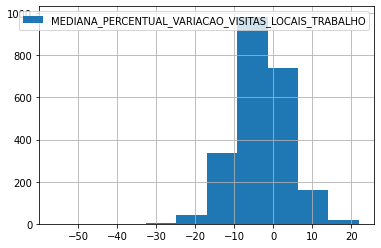

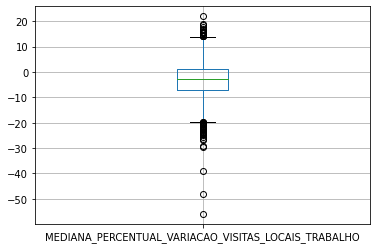

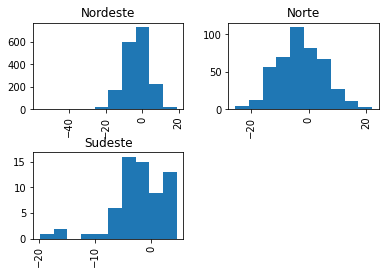

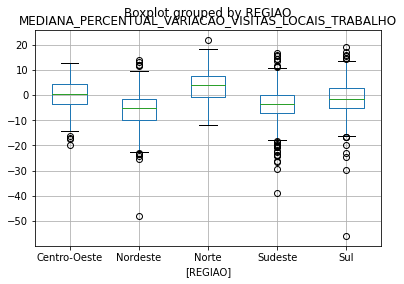

/home/helder/anaconda3/lib/python3.8/site-packages/pandas/plotting/_matplotlib/hist.py:345: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  axes = _grouped_hist(


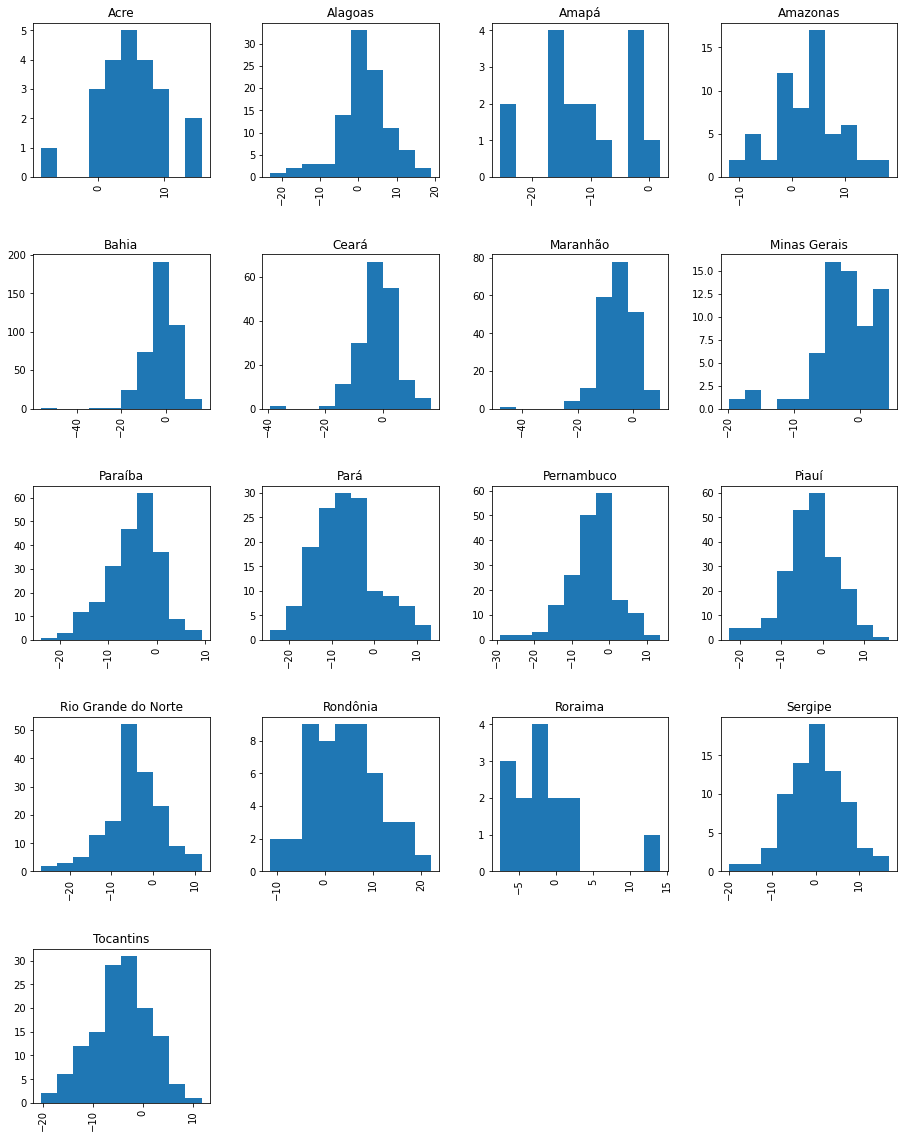

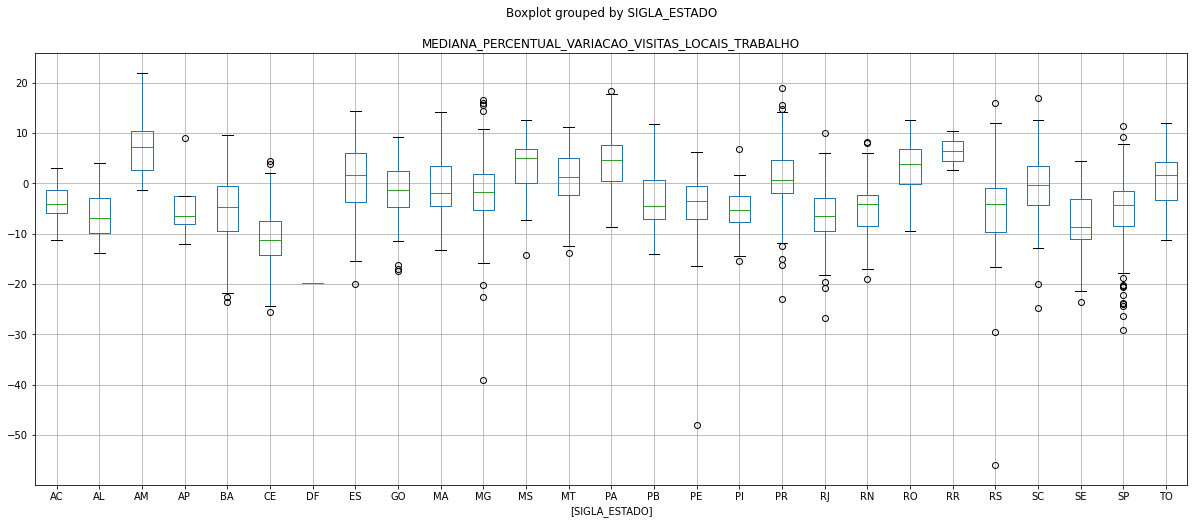

/home/helder/anaconda3/lib/python3.8/site-packages/pandas/plotting/_matplotlib/hist.py:345: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  axes = _grouped_hist(


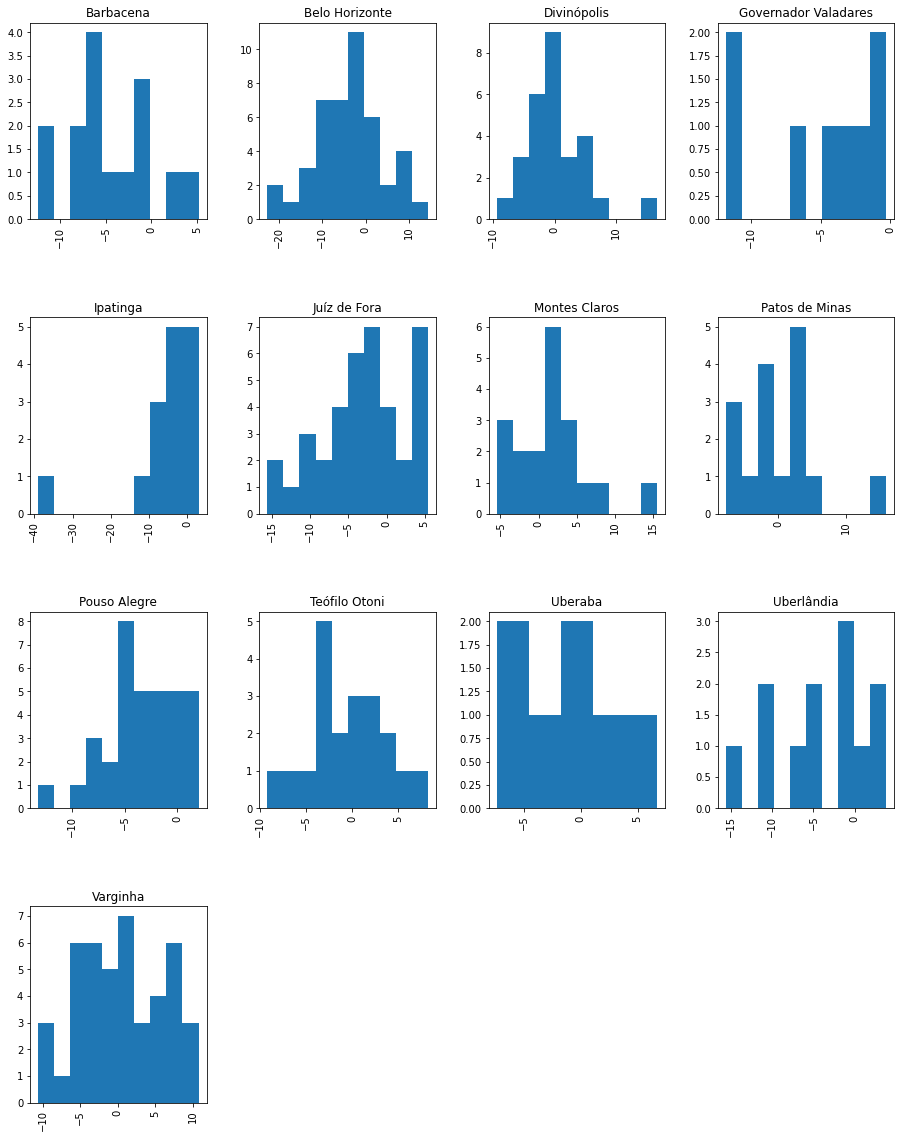

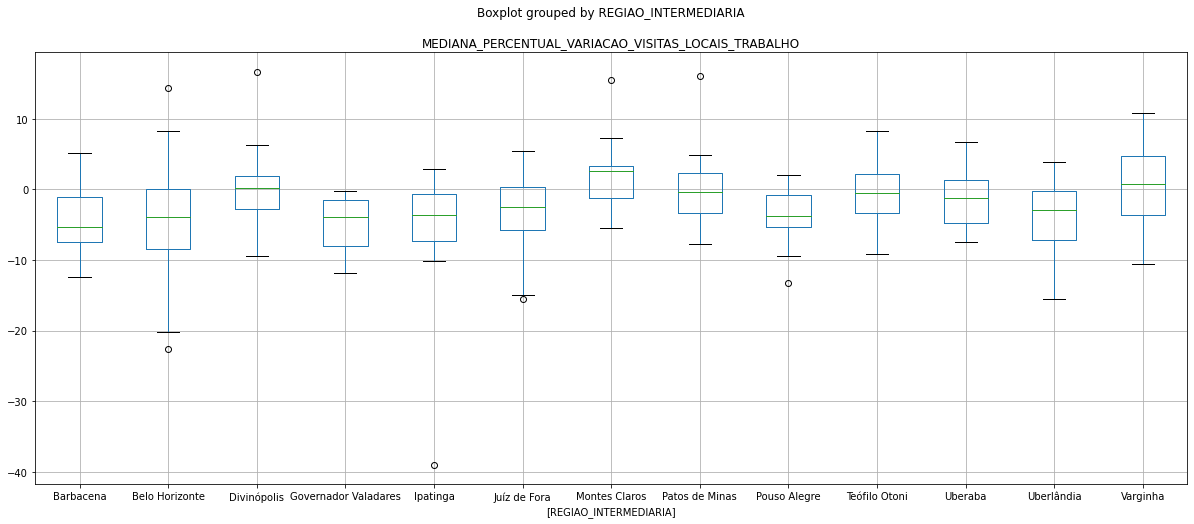

/home/helder/anaconda3/lib/python3.8/site-packages/pandas/plotting/_matplotlib/hist.py:345: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  axes = _grouped_hist(


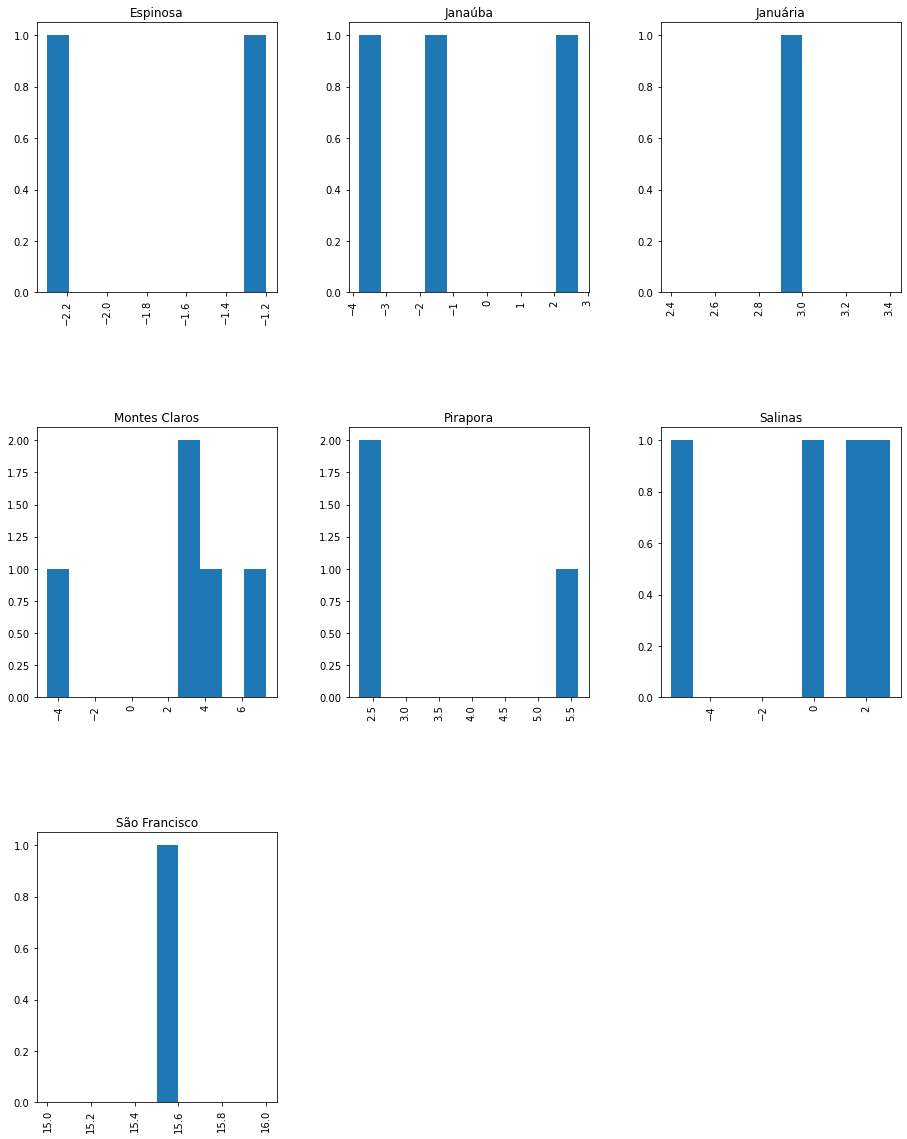

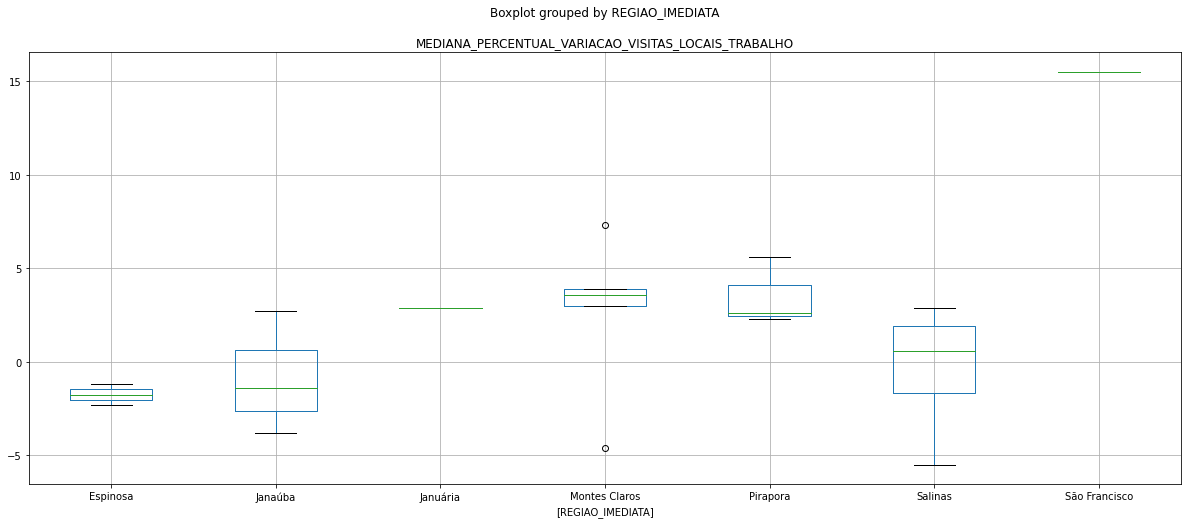

,CODIGO_MUNICIPIO_6,QUARTILE_3_PERCENTUAL_VARIACAO_VISITAS_ESTACAO_TRANSPORTE,QUARTILE_3_PERCENTUAL_VARIACAO_VISITAS_LOCAIS_TRABALHO,QUARTILE_3_PERCENTUAL_VARIACAO_PERMANENCIA_RESIDENCIAS,REGIAO,SIGLA_ESTADO,REGIAO_INTERMEDIARIA,REGIAO_IMEDIATA
0,110001,NaN,22.00,NaN,Norte,RO,Ji-Paraná,Cacoal
1,110002,NaN,20.10,10.90,Norte,RO,Porto Velho,Ariquemes
2,110004,NaN,15.70,9.20,Norte,RO,Ji-Paraná,Cacoal
3,110005,NaN,10.40,NaN,Norte,RO,Ji-Paraná,Vilhena
4,110006,NaN,11.20,NaN,Norte,RO,Ji-Paraná,Vilhena
...,...,...,...,...,...,...,...,...
2303,522140,6.40,6.00,14.60,Centro-Oeste,GO,Goiânia,Goiânia
2304,522160,-35.00,11.25,11.15,Centro-Oeste,GO,Porangatu - Uruaçu,Uruaçu - Niquelândia
2305,522185,32.85,2.40,16.70,Centro-Oeste,GO,Luziânia - Águas Lindas de Goiás,Luziânia
2306,522200,NaN,5.40,NaN,Centro-Oeste,GO,Goiânia,Anápolis


,QUARTILE_3_PERCENTUAL_VARIACAO_VISITAS_ESTACAO_TRANSPORTE,QUARTILE_3_PERCENTUAL_VARIACAO_VISITAS_LOCAIS_TRABALHO,QUARTILE_3_PERCENTUAL_VARIACAO_PERMANENCIA_RESIDENCIAS
count,711.000000,2285.000000,1089.000000
mean,-18.772545,3.588558,10.058414
std,30.852417,7.297386,4.584290
min,-100.000000,-55.000000,-71.000000
25%,-38.968750,-0.650000,8.000000
50%,-23.050000,3.700000,10.500000
75%,-5.200000,8.000000,12.700000
max,170.012500,31.800000,20.500000


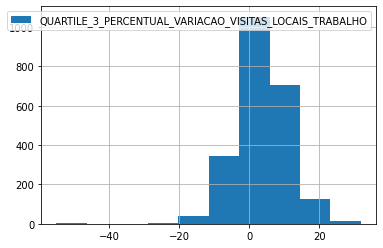

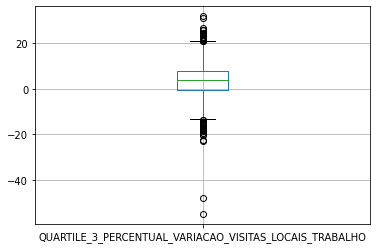

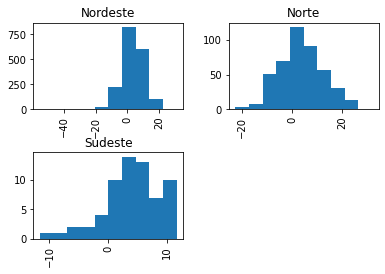

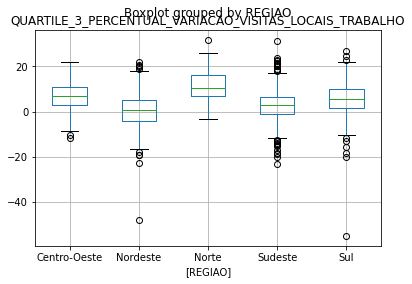

/home/helder/anaconda3/lib/python3.8/site-packages/pandas/plotting/_matplotlib/hist.py:345: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  axes = _grouped_hist(


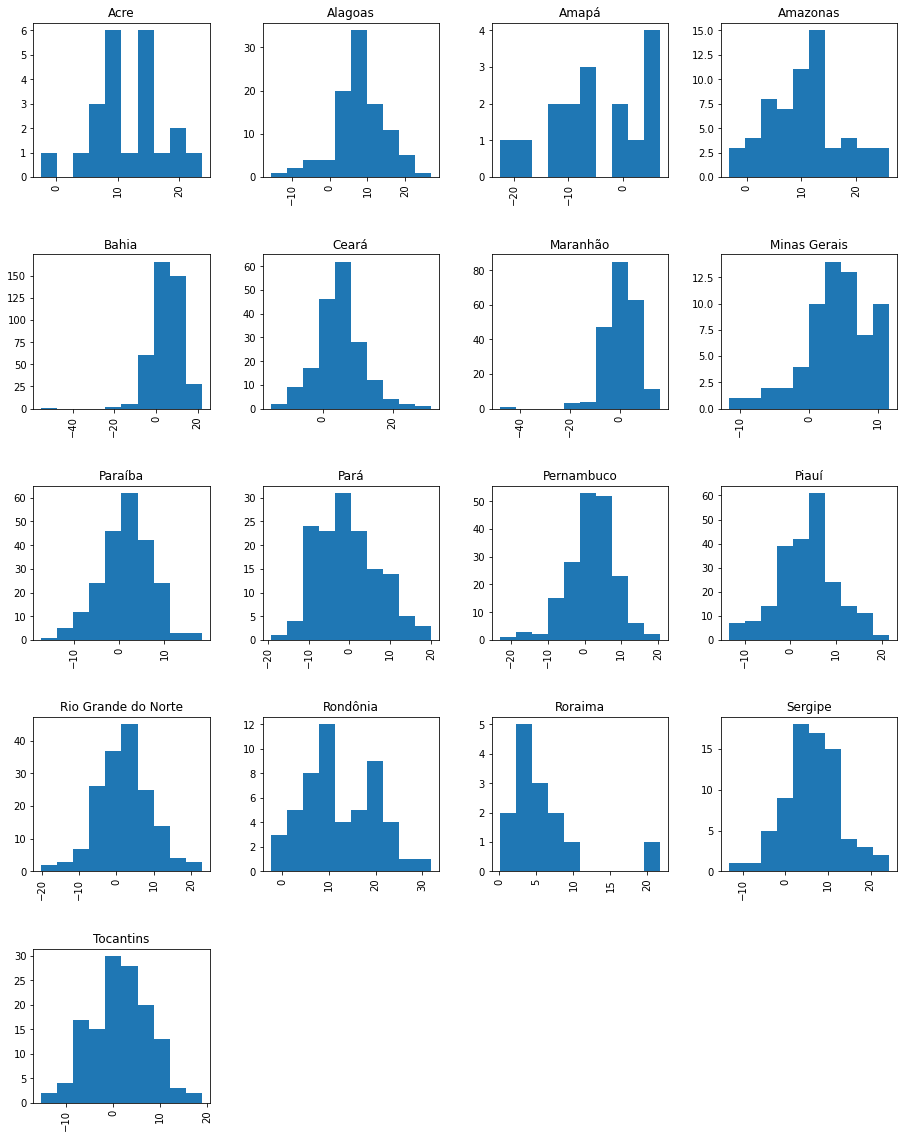

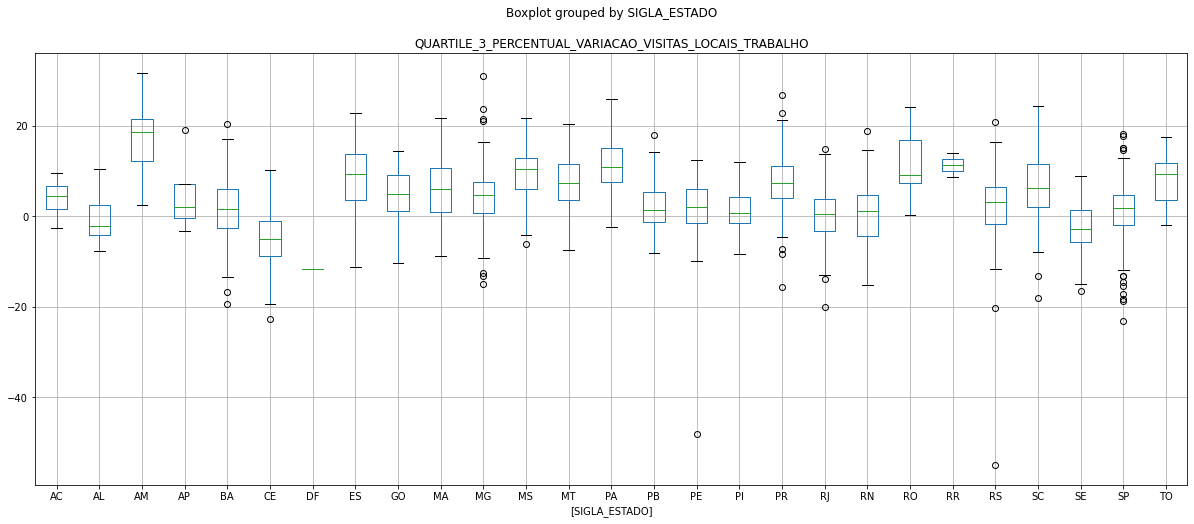

/home/helder/anaconda3/lib/python3.8/site-packages/pandas/plotting/_matplotlib/hist.py:345: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  axes = _grouped_hist(


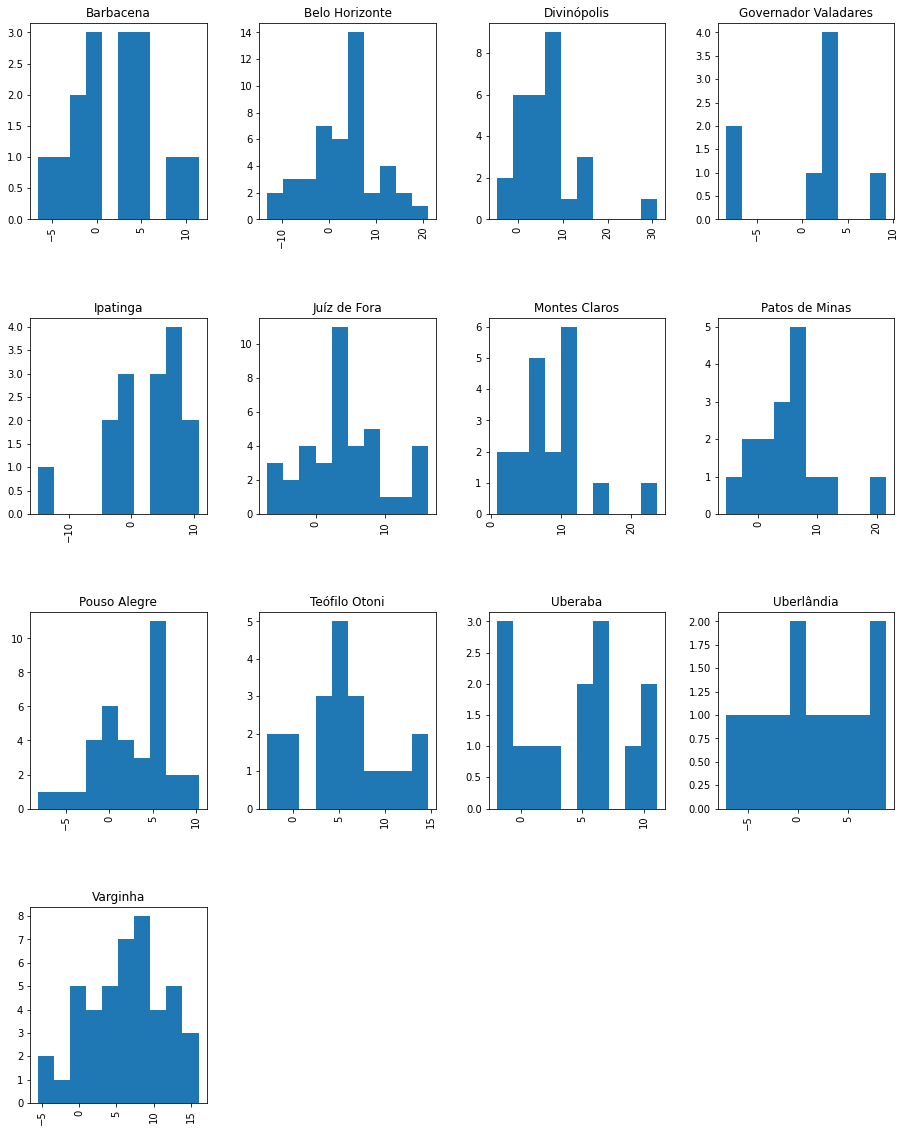

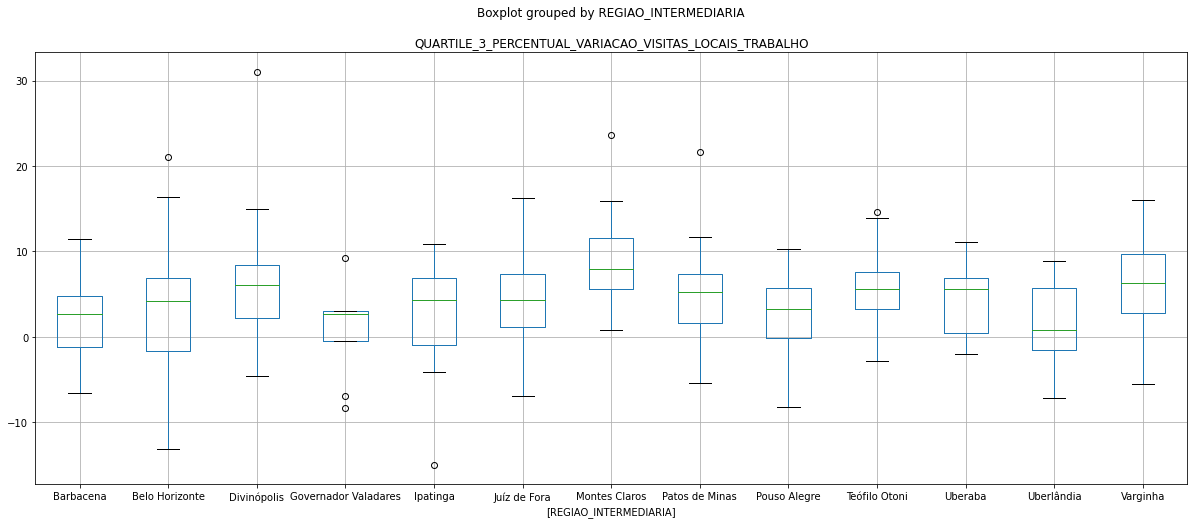

/home/helder/anaconda3/lib/python3.8/site-packages/pandas/plotting/_matplotlib/hist.py:345: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  axes = _grouped_hist(


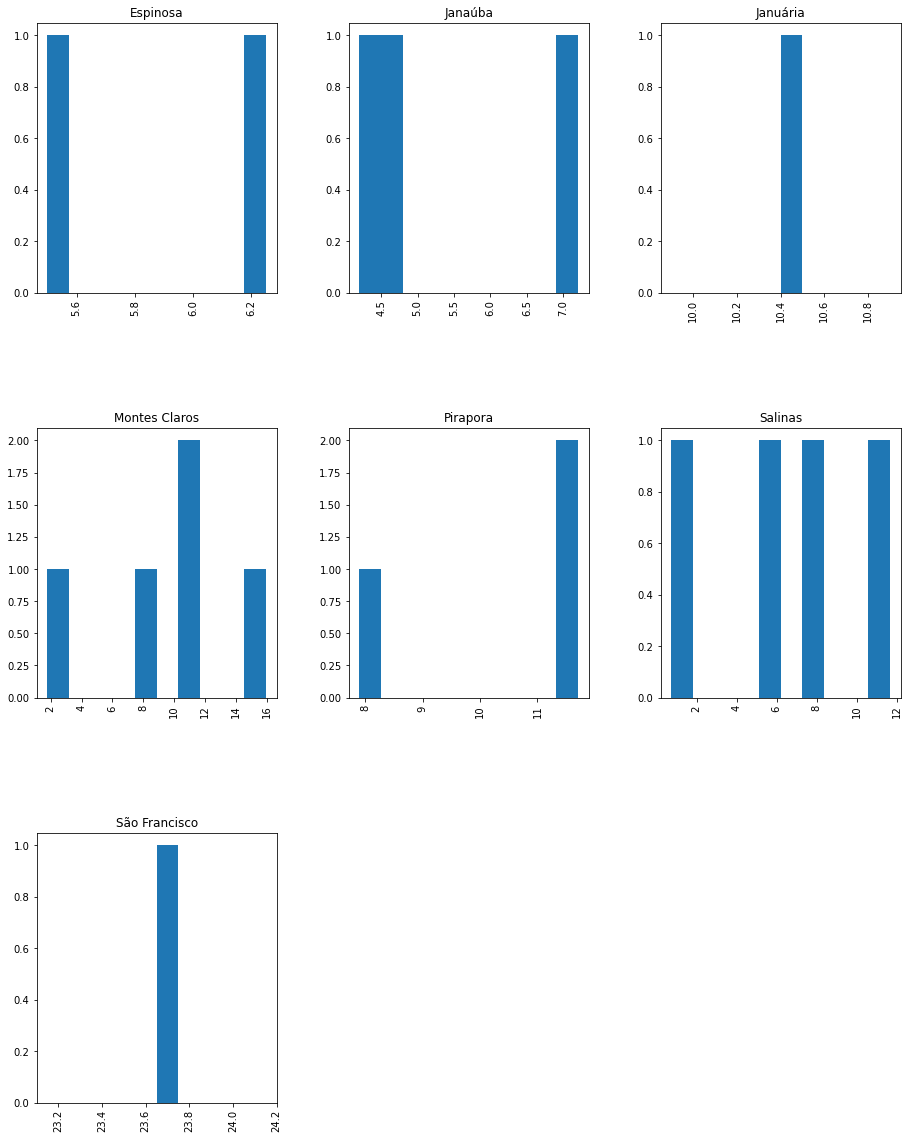

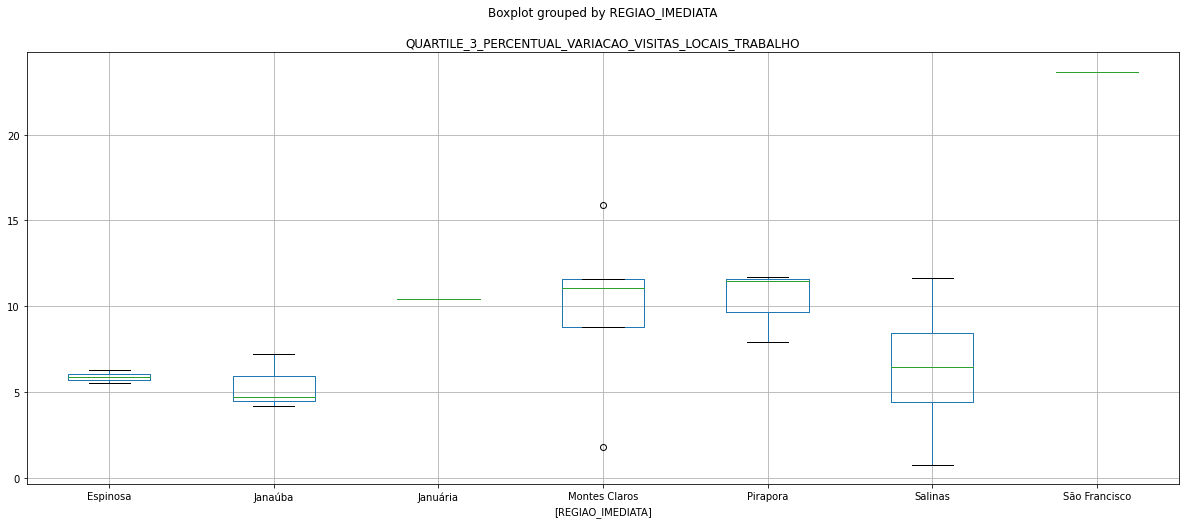

In [337]:
show_analisys_attribute(df_base, 'TAXA_OBITOS')

df_municipio = df_base[['CODIGO_MUNICIPIO_6', 'REGIAO', 'SIGLA_ESTADO', 'REGIAO_INTERMEDIARIA', 'REGIAO_IMEDIATA']]

df_mobilidade_media_visualizacao = pd.merge(df_mobilidade_media, df_municipio, how='left', on='CODIGO_MUNICIPIO_6')
show_analisys_attribute(df_mobilidade_media_visualizacao, 'MEDIA_PERCENTUAL_VARIACAO_VISITAS_LOCAIS_TRABALHO')

df_mobilidade_mediana_visualizacao = pd.merge(df_mobilidade_mediana, df_municipio, how='left', on='CODIGO_MUNICIPIO_6')
show_analisys_attribute(df_mobilidade_mediana_visualizacao, 'MEDIANA_PERCENTUAL_VARIACAO_VISITAS_LOCAIS_TRABALHO')

df_mobilidade_3_quartile_visualizacao = pd.merge(df_mobilidade_3_quartile, df_municipio, how='left', on='CODIGO_MUNICIPIO_6')
show_analisys_attribute(df_mobilidade_3_quartile_visualizacao, 'QUARTILE_3_PERCENTUAL_VARIACAO_VISITAS_LOCAIS_TRABALHO')

,MUNICIPIO,CODIGO_MUNICIPIO_6,SIGLA_ESTADO,CODIGO_ESTADO,REGIAO,REGIAO_SAUDE,CODIGO_REGIAO_SAUDE,REGIAO_METROPOLITANA,CASOS,OBITOS,...,TAXA_LEITOS_INTERNACAO_TOTAL_2019_12_REGIAO_IMEDIATA,TAXA_LEITOS_UTI_TOTAL_2019_12_REGIAO_IMEDIATA,TAXA_MEDICOS_TOTAL_2019_12_REGIAO_IMEDIATA,TAXA_ENFERMEIROS_TOTAL_2019_12_REGIAO_IMEDIATA,TAXA_VENTILADORES_REPIRADORES_EM_USO_2019_12_REGIAO_IMEDIATA,TAXA_LEITOS_INTERNACAO_TOTAL_2019_12_REGIAO_INTERMEDIARIA,TAXA_LEITOS_UTI_TOTAL_2019_12_REGIAO_INTERMEDIARIA,TAXA_MEDICOS_TOTAL_2019_12_REGIAO_INTERMEDIARIA,TAXA_ENFERMEIROS_TOTAL_2019_12_REGIAO_INTERMEDIARIA,TAXA_VENTILADORES_RESPIRADORES_EM_USO_2019_12_REGIAO_INTERMEDIARIA
0,Alta Floresta D'Oeste,110001,RO,11,Norte,ZONA DA MATA,11005.0,0.0,4040.0,65,...,40.589951,3.247196,157.813728,120.146254,12.988784,36.482895,2.183835,127.561671,99.171813,11.433020
1,Ariquemes,110002,RO,11,Norte,VALE DO JAMARI,11001.0,0.0,22424.0,493,...,54.239894,11.958402,85.417156,71.323325,20.927203,60.373777,12.615416,153.988174,115.040580,28.634992
2,Cabixi,110003,RO,11,Norte,CONE SUL,11006.0,0.0,886.0,21,...,12.016722,0.000000,130.286567,111.312795,10.119345,36.482895,2.183835,127.561671,99.171813,11.433020
3,Cacoal,110004,RO,11,Norte,CAFE,11002.0,0.0,14386.0,302,...,40.589951,3.247196,157.813728,120.146254,12.988784,36.482895,2.183835,127.561671,99.171813,11.433020
4,Cerejeiras,110005,RO,11,Norte,CONE SUL,11006.0,0.0,2514.0,61,...,12.016722,0.000000,130.286567,111.312795,10.119345,36.482895,2.183835,127.561671,99.171813,11.433020
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5565,Vianópolis,522200,GO,52,Centro-Oeste,CENTRO SUL,52002.0,0.0,901.0,33,...,86.453458,7.637806,173.719449,101.404056,13.488040,131.938404,17.916559,234.593248,118.243874,28.200988
5566,Vicentinópolis,522205,GO,52,Centro-Oeste,CENTRO SUL,52002.0,0.0,1349.0,23,...,56.862393,0.000000,65.840666,94.271862,5.985515,74.278132,11.778733,127.162239,85.335718,15.865232
5567,Vila Boa,522220,GO,52,Centro-Oeste,ENTORNO NORTE,52003.0,0.0,197.0,4,...,0.000000,0.000000,63.498111,71.435375,0.000000,30.847536,0.936958,78.632387,64.866314,2.810874
5568,Vila Propício,522230,GO,52,Centro-Oeste,SAO PATRICIO II,52018.0,0.0,388.0,7,...,123.333996,8.752735,140.043764,126.118958,18.699025,111.454539,4.404561,103.794433,104.560444,12.256169


,CODIGO_ESTADO,CODIGO_REGIAO_SAUDE,REGIAO_METROPOLITANA,CASOS,OBITOS,POPULACAO_ESTIMADA,DOMICILIOS_PARTICULARES_OCUPADOS_ESTIMADO,DOMICILIOS_PARTICULARES_OCUPADOS_AGLOMERADOS_ESTIMADO,PERCENTUAL_DOMICILIOS_PARTICULARES_OCUPADOS_AGLOMERADOS_ESTIMADO,CODIGO_REGIAO_IMEDIATA,...,TAXA_LEITOS_INTERNACAO_TOTAL_2019_12_REGIAO_IMEDIATA,TAXA_LEITOS_UTI_TOTAL_2019_12_REGIAO_IMEDIATA,TAXA_MEDICOS_TOTAL_2019_12_REGIAO_IMEDIATA,TAXA_ENFERMEIROS_TOTAL_2019_12_REGIAO_IMEDIATA,TAXA_VENTILADORES_REPIRADORES_EM_USO_2019_12_REGIAO_IMEDIATA,TAXA_LEITOS_INTERNACAO_TOTAL_2019_12_REGIAO_INTERMEDIARIA,TAXA_LEITOS_UTI_TOTAL_2019_12_REGIAO_INTERMEDIARIA,TAXA_MEDICOS_TOTAL_2019_12_REGIAO_INTERMEDIARIA,TAXA_ENFERMEIROS_TOTAL_2019_12_REGIAO_INTERMEDIARIA,TAXA_VENTILADORES_RESPIRADORES_EM_USO_2019_12_REGIAO_INTERMEDIARIA
count,5570.000000,5570.000000,5570.000000,5570.000000,5570.000000,5.570000e+03,5.570000e+03,5570.000000,5570.000000,5570.000000,...,5570.000000,5570.000000,5570.000000,5570.000000,5570.000000,5570.000000,5570.000000,5570.000000,5570.000000,5570.000000
mean,32.377738,32403.123698,0.069300,3658.075943,102.248115,3.772839e+04,1.176968e+04,920.600898,1.043896,323793.462657,...,50.343383,6.197581,141.237603,113.414440,15.886186,57.550806,8.066071,160.989005,120.728879,19.166481
std,9.833862,9837.224401,0.253986,18748.097492,751.917652,2.214581e+05,7.378126e+04,12945.799490,4.509078,98340.639166,...,39.156400,7.144393,79.544378,33.585401,12.407539,31.545535,5.968023,69.462012,25.410903,9.676284
min,11.000000,11001.000000,0.000000,10.000000,0.000000,7.810000e+02,3.190000e+02,0.000000,0.000000,110001.000000,...,0.000000,0.000000,22.013312,35.609769,0.000000,0.000000,0.000000,26.054637,42.183698,0.000000
25%,25.000000,25010.000000,0.000000,444.000000,9.000000,5.446500e+03,1.698500e+03,0.000000,0.000000,250009.000000,...,18.515090,0.000000,75.856192,88.704539,5.544774,29.584962,3.673233,101.476569,102.276793,11.460727
50%,31.000000,31059.000000,0.000000,947.000000,20.000000,1.163100e+04,3.432500e+03,0.000000,0.000000,310039.000000,...,45.158062,3.764139,123.168115,106.120886,14.219747,57.716365,6.780069,165.082655,120.012020,19.725571
75%,41.000000,41015.000000,0.000000,2334.500000,51.000000,2.549050e+04,7.373000e+03,0.000000,0.000000,410019.000000,...,74.347123,9.364962,186.799997,133.714235,23.591634,79.503122,11.428339,203.706986,134.778301,25.414597
max,53.000000,53001.000000,1.000000,924543.000000,36452.000000,1.225202e+07,4.104611e+06,529921.000000,73.993700,530001.000000,...,257.652879,39.664799,490.043880,293.034134,79.658955,136.260269,39.664799,338.145730,226.665023,55.252137


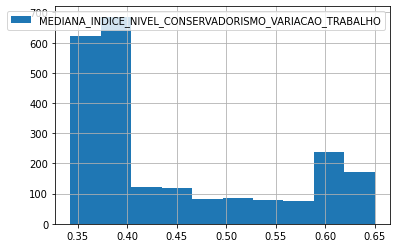

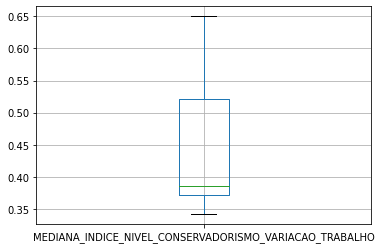

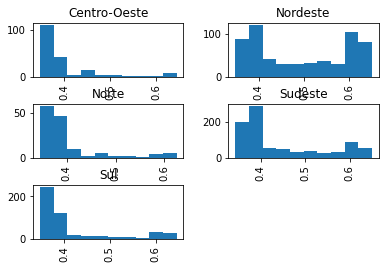

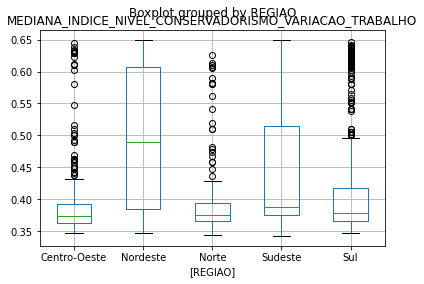

/home/helder/anaconda3/lib/python3.8/site-packages/pandas/plotting/_matplotlib/hist.py:345: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  axes = _grouped_hist(


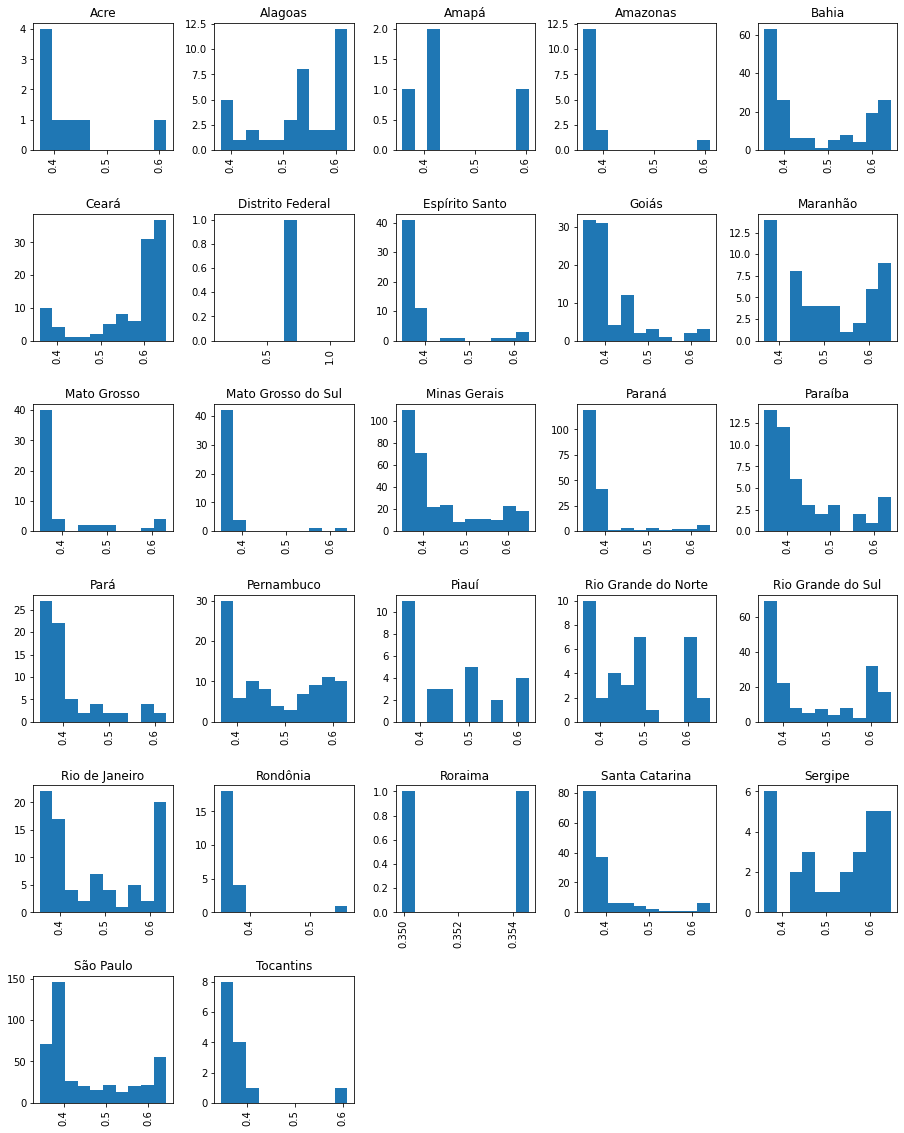

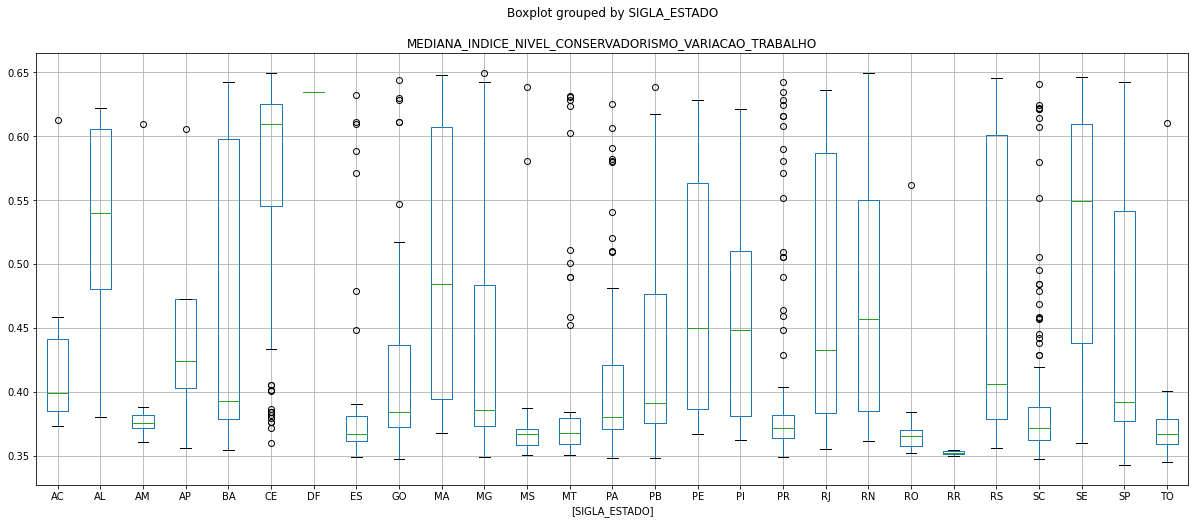

/home/helder/anaconda3/lib/python3.8/site-packages/pandas/plotting/_matplotlib/hist.py:345: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  axes = _grouped_hist(


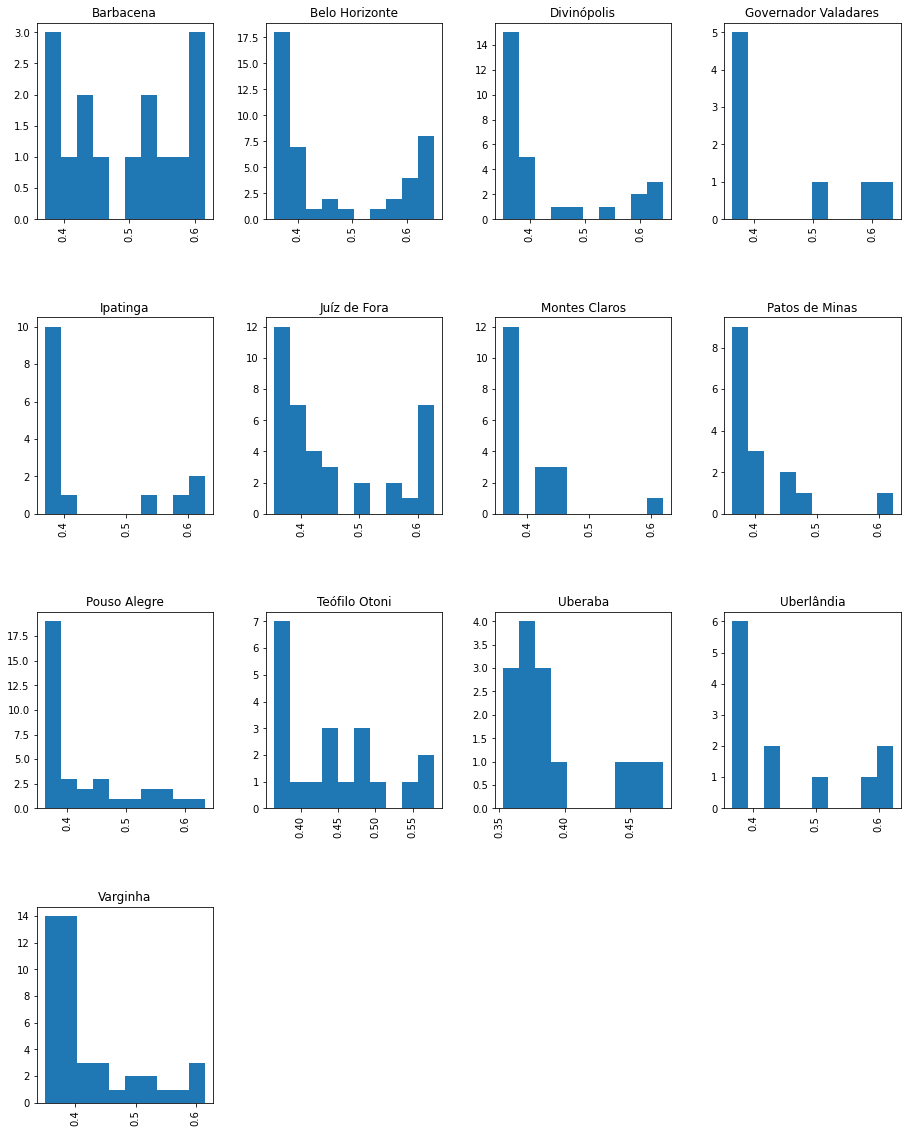

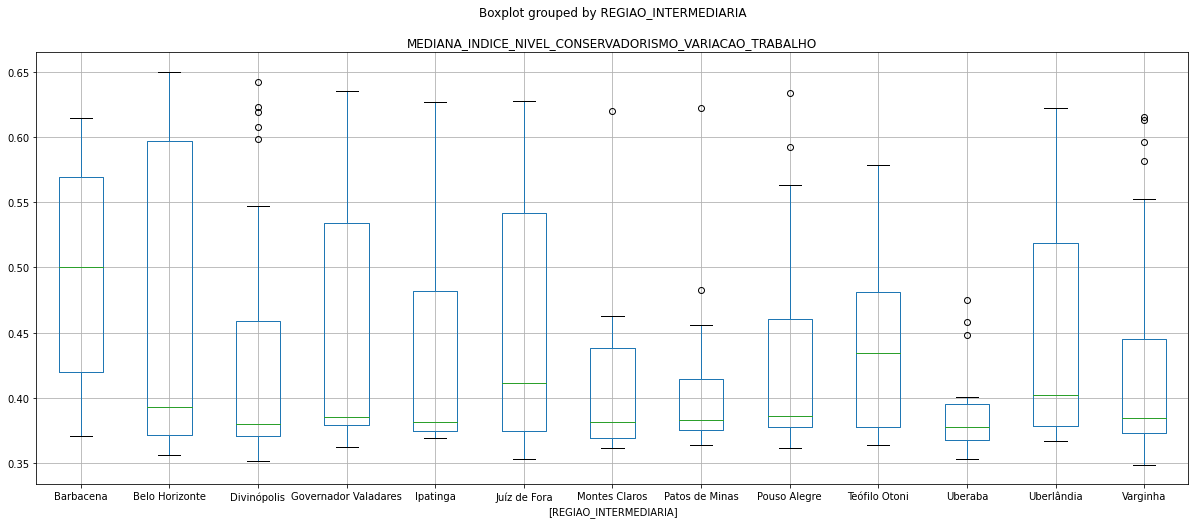

/home/helder/anaconda3/lib/python3.8/site-packages/pandas/plotting/_matplotlib/hist.py:345: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  axes = _grouped_hist(


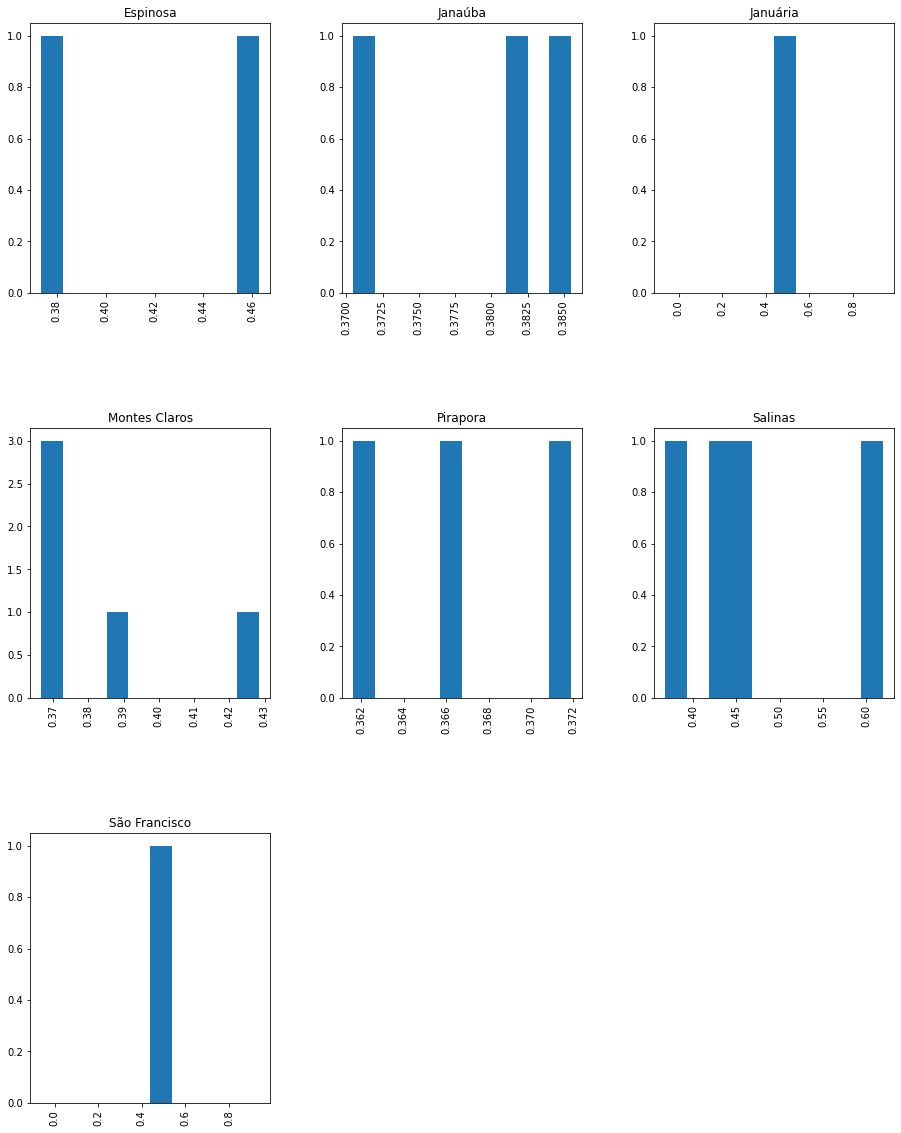

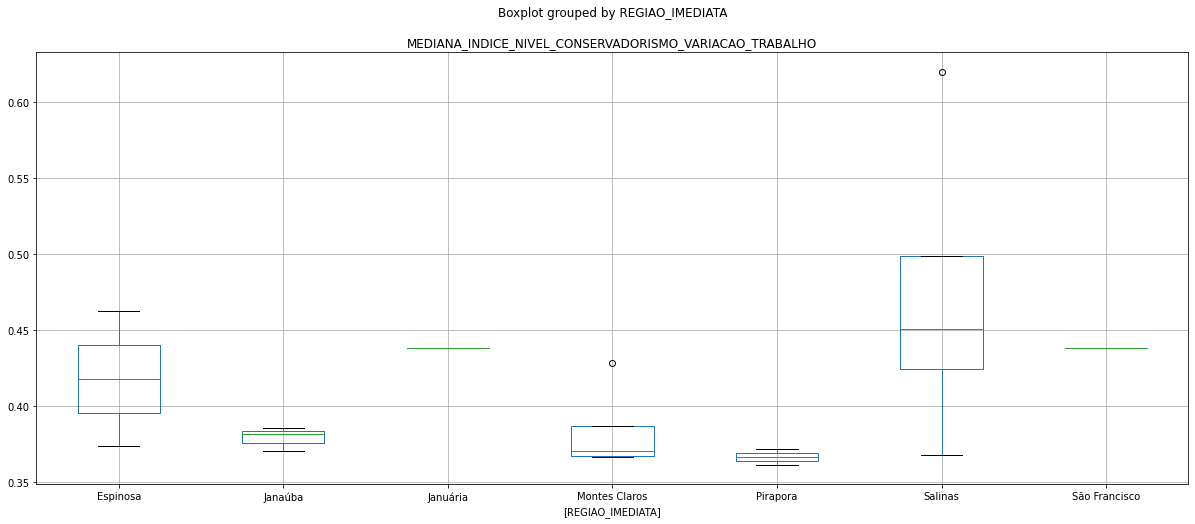

In [378]:
show_analisys_attribute(df_base, 'MEDIANA_INDICE_NIVEL_CONSERVADORISMO_VARIACAO_TRABALHO')

<__array_function__ internals>:5: UserWarning: Warning: converting a masked element to nan.
/home/helder/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/home/helder/.local/lib/python3.8/site-packages/matplotlib/ticker.py:652: UserWarning: Warning: converting a masked element to nan.
  s = self.format % xp


Text(0, 0.5, 'Taxa óbitos')

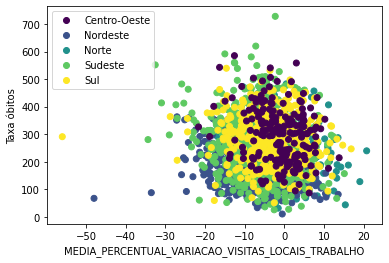

In [338]:
labels, index = np.unique(df_base.REGIAO, return_inverse=True)
grafico = plt.scatter(x=df_base.MEDIA_PERCENTUAL_VARIACAO_VISITAS_LOCAIS_TRABALHO, y=df_base.TAXA_OBITOS, c=index)
plt.legend(grafico.legend_elements()[0], labels)
plt.xlabel('MEDIA_PERCENTUAL_VARIACAO_VISITAS_LOCAIS_TRABALHO')
plt.ylabel('Taxa óbitos')

Text(0, 0.5, 'Taxa óbitos')

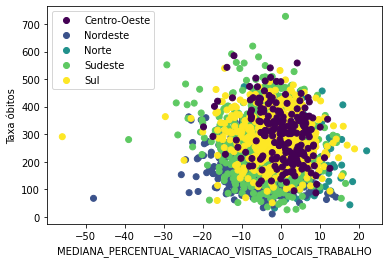

In [339]:
labels, index = np.unique(df_base.REGIAO, return_inverse=True)
grafico = plt.scatter(x=df_base.MEDIANA_PERCENTUAL_VARIACAO_VISITAS_LOCAIS_TRABALHO, y=df_base.TAXA_OBITOS, c=index)
plt.legend(grafico.legend_elements()[0], labels)
plt.xlabel('MEDIANA_PERCENTUAL_VARIACAO_VISITAS_LOCAIS_TRABALHO')
plt.ylabel('Taxa óbitos')

Text(0, 0.5, 'Taxa óbitos')

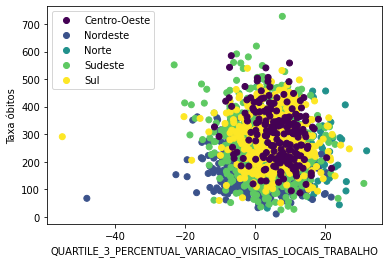

In [340]:
labels, index = np.unique(df_base.REGIAO, return_inverse=True)
grafico = plt.scatter(x=df_base['QUARTILE_3_PERCENTUAL_VARIACAO_VISITAS_LOCAIS_TRABALHO'], y=df_base.TAXA_OBITOS, c=index)
plt.legend(grafico.legend_elements()[0], labels)
plt.xlabel('QUARTILE_3_PERCENTUAL_VARIACAO_VISITAS_LOCAIS_TRABALHO')
plt.ylabel('Taxa óbitos')

Text(0, 0.5, 'Taxa óbitos')

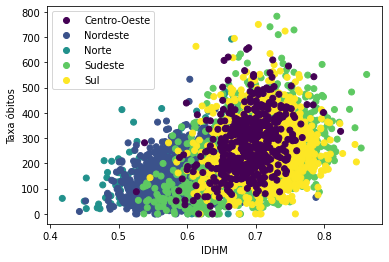

In [341]:
labels, index = np.unique(df_base.REGIAO, return_inverse=True)
grafico = plt.scatter(x=df_base.IDHM, y=df_base.TAXA_OBITOS, c=index)
plt.legend(grafico.legend_elements()[0], labels)
plt.xlabel('IDHM')
plt.ylabel('Taxa óbitos')


Text(0, 0.5, 'Taxa óbitos')

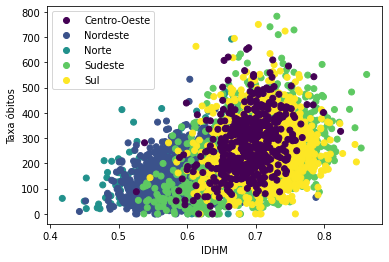

In [342]:
labels, index = np.unique(df_base.REGIAO, return_inverse=True)
grafico = plt.scatter(x=df_base.IDHM, y=df_base.TAXA_OBITOS, c=index)
plt.legend(grafico.legend_elements()[0], labels)
plt.xlabel('IDHM')
plt.ylabel('Taxa óbitos')

Text(0, 0.5, 'Taxa óbitos')

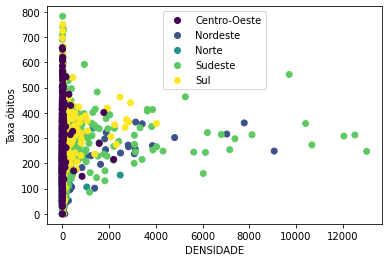

In [343]:
labels, index = np.unique(df_base.REGIAO, return_inverse=True)
grafico = plt.scatter(x=df_base.DENSIDADE, y=df_base.TAXA_OBITOS, c=index)
plt.legend(grafico.legend_elements()[0], labels)
plt.xlabel('DENSIDADE')
plt.ylabel('Taxa óbitos')

Text(0, 0.5, 'Taxa óbitos')

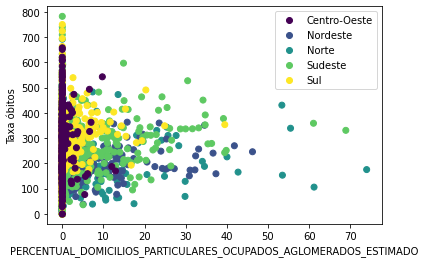

In [344]:
labels, index = np.unique(df_base.REGIAO, return_inverse=True)
grafico = plt.scatter(x=df_base.PERCENTUAL_DOMICILIOS_PARTICULARES_OCUPADOS_AGLOMERADOS_ESTIMADO, y=df_base.TAXA_OBITOS, c=index)
plt.legend(grafico.legend_elements()[0], labels)
plt.xlabel('PERCENTUAL_DOMICILIOS_PARTICULARES_OCUPADOS_AGLOMERADOS_ESTIMADO')
plt.ylabel('Taxa óbitos')

Text(0, 0.5, 'Taxa óbitos')

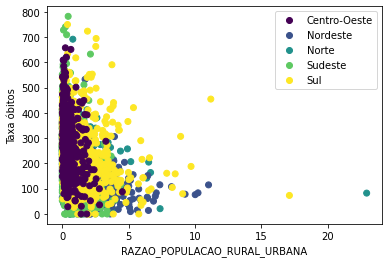

In [345]:
labels, index = np.unique(df_base.REGIAO, return_inverse=True)
grafico = plt.scatter(x=df_base.RAZAO_POPULACAO_RURAL_URBANA, y=df_base.TAXA_OBITOS, c=index)
plt.legend(grafico.legend_elements()[0], labels)
plt.xlabel('RAZAO_POPULACAO_RURAL_URBANA')
plt.ylabel('Taxa óbitos')

Text(0, 0.5, 'Taxa óbitos')

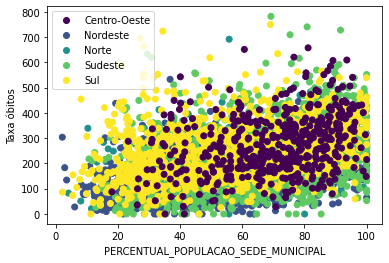

In [346]:
labels, index = np.unique(df_base.REGIAO, return_inverse=True)
grafico = plt.scatter(x=df_base.PERCENTUAL_POPULACAO_SEDE_MUNICIPAL, y=df_base.TAXA_OBITOS, c=index)
plt.legend(grafico.legend_elements()[0], labels)
plt.xlabel('PERCENTUAL_POPULACAO_SEDE_MUNICIPAL')
plt.ylabel('Taxa óbitos')

Text(0, 0.5, 'Taxa óbitos')

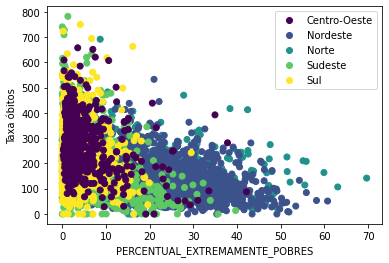

In [347]:
labels, index = np.unique(df_base.REGIAO, return_inverse=True)
grafico = plt.scatter(x=df_base.PERCENTUAL_EXTREMAMENTE_POBRES, y=df_base.TAXA_OBITOS, c=index)
plt.legend(grafico.legend_elements()[0], labels)
plt.xlabel('PERCENTUAL_EXTREMAMENTE_POBRES')
plt.ylabel('Taxa óbitos')

Text(0, 0.5, 'Taxa óbitos')

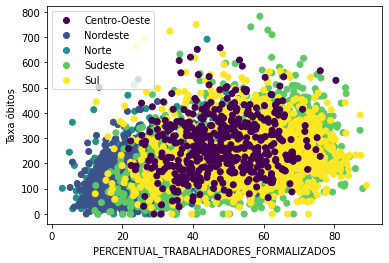

In [348]:
labels, index = np.unique(df_base.REGIAO, return_inverse=True)
grafico = plt.scatter(x=df_base.PERCENTUAL_TRABALHADORES_FORMALIZADOS, y=df_base.TAXA_OBITOS, c=index)
plt.legend(grafico.legend_elements()[0], labels)
plt.xlabel('PERCENTUAL_TRABALHADORES_FORMALIZADOS')
plt.ylabel('Taxa óbitos')

Text(0, 0.5, 'Taxa óbitos')

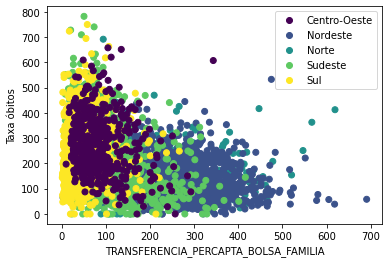

In [349]:
labels, index = np.unique(df_base.REGIAO, return_inverse=True)
grafico = plt.scatter(x=df_base.TRANSFERENCIA_PERCAPTA_BOLSA_FAMILIA, y=df_base.TAXA_OBITOS, c=index)
plt.legend(grafico.legend_elements()[0], labels)
plt.xlabel('TRANSFERENCIA_PERCAPTA_BOLSA_FAMILIA')
plt.ylabel('Taxa óbitos')

Text(0, 0.5, 'Taxa óbitos')

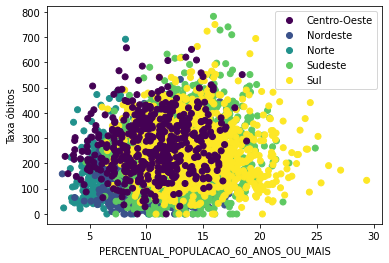

In [350]:
labels, index = np.unique(df_base.REGIAO, return_inverse=True)
grafico = plt.scatter(x=df_base.PERCENTUAL_POPULACAO_60_ANOS_OU_MAIS, y=df_base.TAXA_OBITOS, c=index)
plt.legend(grafico.legend_elements()[0], labels)
plt.xlabel('PERCENTUAL_POPULACAO_60_ANOS_OU_MAIS')
plt.ylabel('Taxa óbitos')

Text(0, 0.5, 'Taxa óbitos')

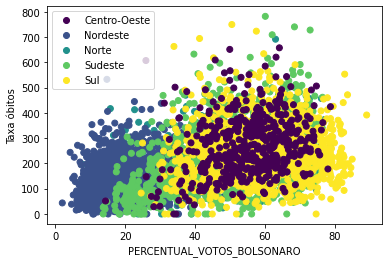

In [351]:
labels, index = np.unique(df_base.REGIAO, return_inverse=True)
grafico = plt.scatter(x=df_base.PERCENTUAL_VOTOS_BOLSONARO, y=df_base.TAXA_OBITOS, c=index)
plt.legend(grafico.legend_elements()[0], labels)
plt.xlabel('PERCENTUAL_VOTOS_BOLSONARO')
plt.ylabel('Taxa óbitos')

Text(0, 0.5, 'Taxa óbitos')

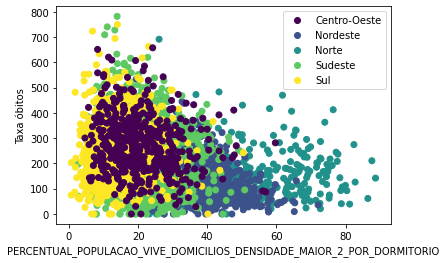

In [352]:
labels, index = np.unique(df_base.REGIAO, return_inverse=True)
grafico = plt.scatter(x=df_base.PERCENTUAL_POPULACAO_VIVE_DOMICILIOS_DENSIDADE_MAIOR_2_POR_DORMITORIO, y=df_base.TAXA_OBITOS, c=index)
plt.legend(grafico.legend_elements()[0], labels)
plt.xlabel('PERCENTUAL_POPULACAO_VIVE_DOMICILIOS_DENSIDADE_MAIOR_2_POR_DORMITORIO')
plt.ylabel('Taxa óbitos')

Text(0, 0.5, 'Taxa óbitos')

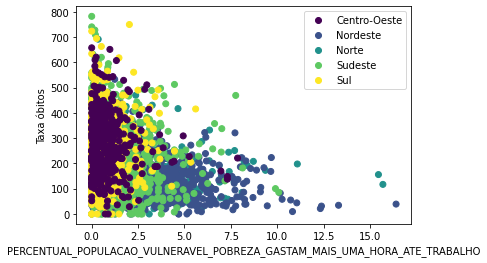

In [353]:
labels, index = np.unique(df_base.REGIAO, return_inverse=True)
grafico = plt.scatter(x=df_base.PERCENTUAL_POPULACAO_VULNERAVEL_POBREZA_GASTAM_MAIS_UMA_HORA_ATE_TRABALHO, y=df_base.TAXA_OBITOS, c=index)
plt.legend(grafico.legend_elements()[0], labels)
plt.xlabel('PERCENTUAL_POPULACAO_VULNERAVEL_POBREZA_GASTAM_MAIS_UMA_HORA_ATE_TRABALHO')
plt.ylabel('Taxa óbitos')

Text(0, 0.5, 'Taxa óbitos')

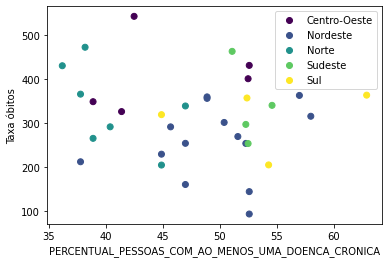

In [354]:
labels, index = np.unique(df_base.REGIAO, return_inverse=True)
grafico = plt.scatter(x=df_base.PERCENTUAL_PESSOAS_COM_AO_MENOS_UMA_DOENCA_CRONICA, y=df_base.TAXA_OBITOS, c=index)
plt.legend(grafico.legend_elements()[0], labels)
plt.xlabel('PERCENTUAL_PESSOAS_COM_AO_MENOS_UMA_DOENCA_CRONICA')
plt.ylabel('Taxa óbitos')

Text(0, 0.5, 'Taxa óbitos')

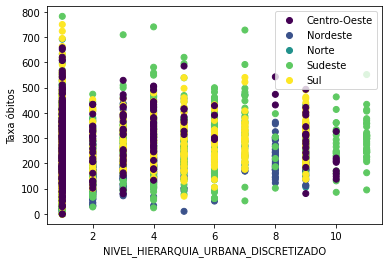

In [355]:
labels, index = np.unique(df_base.REGIAO, return_inverse=True)
grafico = plt.scatter(x=df_base.NIVEL_HIERARQUIA_URBANA_DISCRETIZADO, y=df_base.TAXA_OBITOS, c=index)
plt.legend(grafico.legend_elements()[0], labels)
plt.xlabel('NIVEL_HIERARQUIA_URBANA_DISCRETIZADO')
plt.ylabel('Taxa óbitos')

Text(0, 0.5, 'Taxa óbitos')

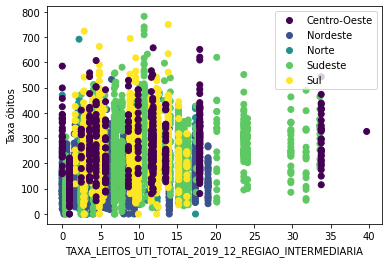

In [356]:
labels, index = np.unique(df_base.REGIAO, return_inverse=True)
grafico = plt.scatter(x=df_base.TAXA_LEITOS_UTI_TOTAL_2019_12_REGIAO_INTERMEDIARIA, y=df_base.TAXA_OBITOS, c=index)
plt.legend(grafico.legend_elements()[0], labels)
plt.xlabel('TAXA_LEITOS_UTI_TOTAL_2019_12_REGIAO_INTERMEDIARIA')
plt.ylabel('Taxa óbitos')

Text(0, 0.5, 'Taxa óbitos')

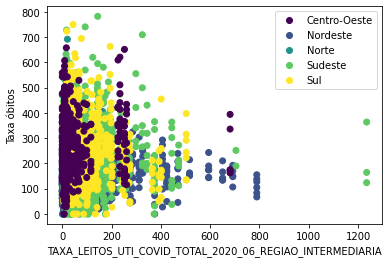

In [357]:
labels, index = np.unique(df_base.REGIAO, return_inverse=True)
grafico = plt.scatter(x=df_base.TAXA_LEITOS_UTI_COVID_TOTAL_2020_06_REGIAO_INTERMEDIARIA, y=df_base.TAXA_OBITOS, c=index)
plt.legend(grafico.legend_elements()[0], labels)
plt.xlabel('TAXA_LEITOS_UTI_COVID_TOTAL_2020_06_REGIAO_INTERMEDIARIA')
plt.ylabel('Taxa óbitos')

Text(0, 0.5, 'Taxa óbitos')

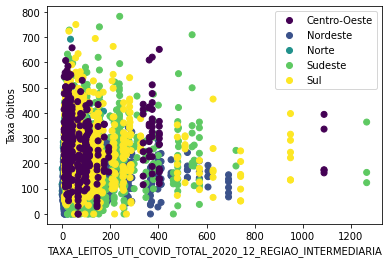

In [358]:
labels, index = np.unique(df_base.REGIAO, return_inverse=True)
grafico = plt.scatter(x=df_base.TAXA_LEITOS_UTI_COVID_TOTAL_2020_12_REGIAO_INTERMEDIARIA, y=df_base.TAXA_OBITOS, c=index)
plt.legend(grafico.legend_elements()[0], labels)
plt.xlabel('TAXA_LEITOS_UTI_COVID_TOTAL_2020_12_REGIAO_INTERMEDIARIA')
plt.ylabel('Taxa óbitos')

Text(0, 0.5, 'Taxa óbitos')

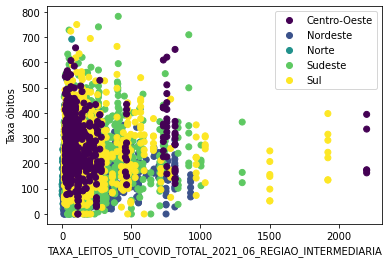

In [359]:
labels, index = np.unique(df_base.REGIAO, return_inverse=True)
grafico = plt.scatter(x=df_base.TAXA_LEITOS_UTI_COVID_TOTAL_2021_06_REGIAO_INTERMEDIARIA, y=df_base.TAXA_OBITOS, c=index)
plt.legend(grafico.legend_elements()[0], labels)
plt.xlabel('TAXA_LEITOS_UTI_COVID_TOTAL_2021_06_REGIAO_INTERMEDIARIA')
plt.ylabel('Taxa óbitos')

/home/helder/anaconda3/lib/python3.8/site-packages/pandas/plotting/_matplotlib/hist.py:345: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  axes = _grouped_hist(


array([[<AxesSubplot:title={'center':'Capital Regional A'}>,
        <AxesSubplot:title={'center':'Capital Regional B'}>,
        <AxesSubplot:title={'center':'Capital Regional C'}>],
       [<AxesSubplot:title={'center':'Centro Local'}>,
        <AxesSubplot:title={'center':'Centro Sub-Regional A'}>,
        <AxesSubplot:title={'center':'Centro Sub-Regional B'}>],
       [<AxesSubplot:title={'center':'Centro de Zona A'}>,
        <AxesSubplot:title={'center':'Centro de Zona B'}>,
        <AxesSubplot:title={'center':'Grande Metrópole Nacional'}>],
       [<AxesSubplot:title={'center':'Metrópole'}>,
        <AxesSubplot:title={'center':'Metrópole Nacional'}>,
        <AxesSubplot:>]], dtype=object)

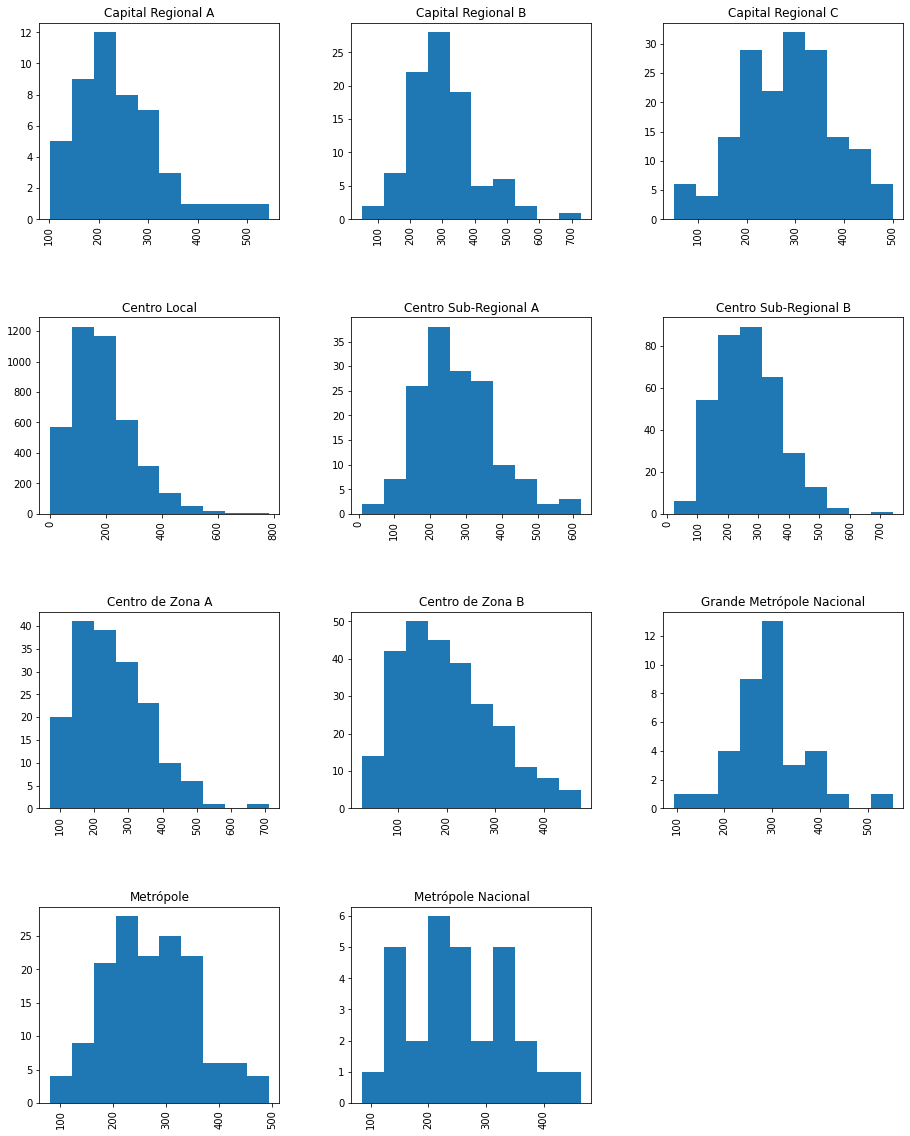

In [360]:
fig = plt.figure(figsize = (15,20))
ax = fig.gca()
df_base.TAXA_OBITOS.hist(by=df_base.HIERARQUIA_URBANA, ax=ax)

<AxesSubplot:title={'center':'TAXA_OBITOS'}, xlabel='[HIERARQUIA_URBANA]'>

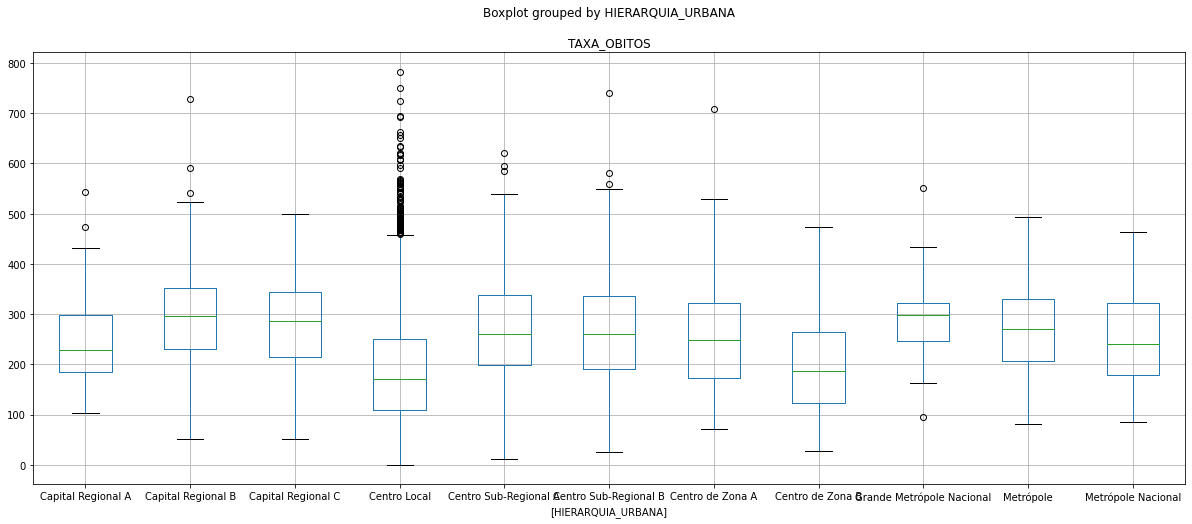

In [361]:
df_base[["TAXA_OBITOS",'HIERARQUIA_URBANA']].boxplot(by='HIERARQUIA_URBANA', figsize=(20,8))

<AxesSubplot:title={'center':'TAXA_OBITOS'}, xlabel='[NIVEL_HIERARQUIA_URBANA_DISCRETIZADO]'>

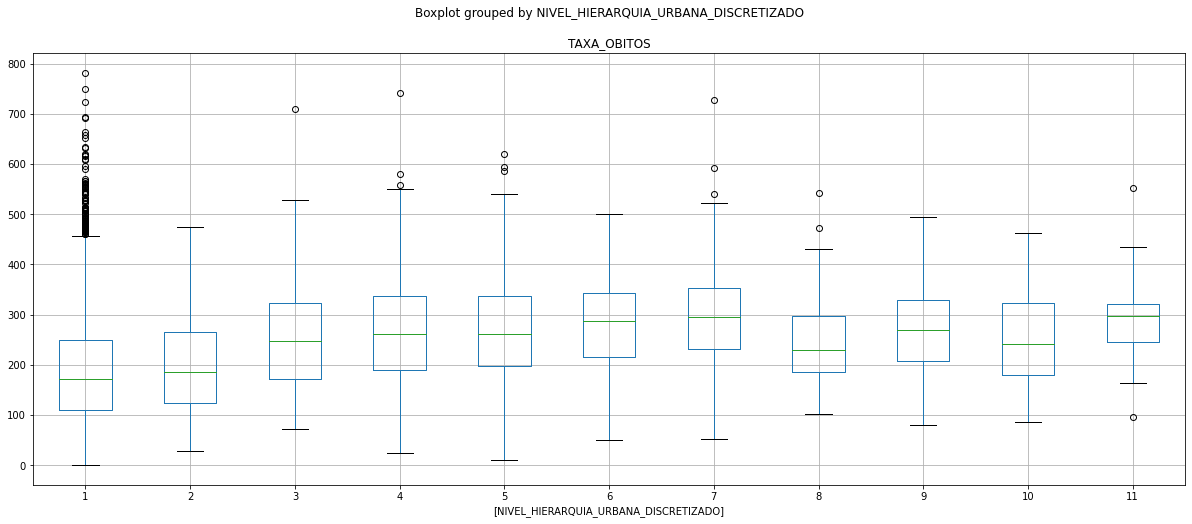

In [362]:
df_base[["TAXA_OBITOS",'NIVEL_HIERARQUIA_URBANA_DISCRETIZADO']].boxplot(by='NIVEL_HIERARQUIA_URBANA_DISCRETIZADO', figsize=(20,8))

In [363]:
df_base[df_base.NIVEL_HIERARQUIA_URBANA_DISCRETIZADO >= 4].sum().POPULACAO_ESTIMADA / df_base.sum().POPULACAO_ESTIMADA * 100

69.86338690096284

In [364]:
df_base.groupby('HIERARQUIA_URBANA').count().POPULACAO_ESTIMADA

HIERARQUIA_URBANA
Capital Regional A             48
Capital Regional B             92
Capital Regional C            168
Centro Local                 4115
Centro Sub-Regional A         151
Centro Sub-Regional B         345
Centro de Zona A              173
Centro de Zona B              264
Grande Metrópole Nacional      37
Metrópole                     147
Metrópole Nacional             30
Name: POPULACAO_ESTIMADA, dtype: int64

In [365]:
df_hierarquia_urbana_brasil = df_base.groupby('HIERARQUIA_URBANA').sum()[['OBITOS','POPULACAO_ESTIMADA']]
df_hierarquia_urbana_brasil['TAXA_OBITOS'] = df_hierarquia_urbana_brasil.OBITOS / df_hierarquia_urbana_brasil.POPULACAO_ESTIMADA * 100000
print(df_hierarquia_urbana_brasil)

                           OBITOS  POPULACAO_ESTIMADA  TAXA_OBITOS
HIERARQUIA_URBANA                                                 
Capital Regional A          31596             9918266   318.563749
Capital Regional B          39534            12955894   305.142972
Capital Regional C          60421            19542042   309.184680
Centro Local                92698            51038490   181.623712
Centro Sub-Regional A       32670            11555268   282.728189
Centro Sub-Regional B       49136            18260630   269.081625
Centro de Zona A            15014             6150831   244.097098
Centro de Zona B            11864             6141905   193.164824
Grande Metrópole Nacional   67091            21673440   309.553998
Metrópole                  111637            36142341   308.881486
Metrópole Nacional          57861            16768018   345.067616


In [366]:
df_hierarquia_urbana_brasil_mean = df_base.groupby('HIERARQUIA_URBANA').mean()[['TAXA_OBITOS']]
df_hierarquia_urbana_brasil_mean.columns = ['TAXA_OBITOS_MEDIA']
df_hierarquia_urbana_brasil_std = df_base.groupby('HIERARQUIA_URBANA').std()[['TAXA_OBITOS']]
df_hierarquia_urbana_brasil_std.columns = ['TAXA_OBITOS_DESVIO_PADRAO']
df_hierarquia_urbana_brasil = pd.merge(df_hierarquia_urbana_brasil_mean, df_hierarquia_urbana_brasil_std, left_index=True, right_index=True)
print(df_hierarquia_urbana_brasil)

                           TAXA_OBITOS_MEDIA  TAXA_OBITOS_DESVIO_PADRAO
HIERARQUIA_URBANA                                                      
Capital Regional A                246.586650                  90.016821
Capital Regional B                304.597776                 105.665804
Capital Regional C                282.395222                  94.791949
Centro Local                      189.227399                 109.314497
Centro Sub-Regional A             272.797287                 108.388198
Centro Sub-Regional B             268.670968                 106.138583
Centro de Zona A                  252.918736                 106.581659
Centro de Zona B                  201.426013                  96.871084
Grande Metrópole Nacional         296.337538                  80.792886
Metrópole                         272.339099                  84.304371
Metrópole Nacional                250.588465                  88.746599


In [367]:
df_base.groupby('HIERARQUIA_URBANA').count()[['TAXA_OBITOS', 'MEDIANA_PERCENTUAL_VARIACAO_VISITAS_LOCAIS_TRABALHO', 'QUARTILE_3_PERCENTUAL_VARIACAO_VISITAS_ESTACAO_TRANSPORTE', 'MEDIANA_PERCENTUAL_VARIACAO_PERMANENCIA_RESIDENCIAS']]

,TAXA_OBITOS,MEDIANA_PERCENTUAL_VARIACAO_VISITAS_LOCAIS_TRABALHO,QUARTILE_3_PERCENTUAL_VARIACAO_VISITAS_ESTACAO_TRANSPORTE,MEDIANA_PERCENTUAL_VARIACAO_PERMANENCIA_RESIDENCIAS
HIERARQUIA_URBANA,,,,
Capital Regional A,48,39,19,31
Capital Regional B,92,77,46,58
Capital Regional C,168,138,85,110
Centro Local,4115,1038,113,184
Centro Sub-Regional A,151,130,85,107
Centro Sub-Regional B,345,301,148,266
Centro de Zona A,173,156,43,122
Centro de Zona B,264,197,18,32
Grande Metrópole Nacional,37,37,36,35


In [368]:
df_base.groupby('CAPITAL').count()[['TAXA_OBITOS', 'MEDIANA_PERCENTUAL_VARIACAO_VISITAS_LOCAIS_TRABALHO', 'QUARTILE_3_PERCENTUAL_VARIACAO_VISITAS_ESTACAO_TRANSPORTE', 'MEDIANA_PERCENTUAL_VARIACAO_PERMANENCIA_RESIDENCIAS']]

,TAXA_OBITOS,MEDIANA_PERCENTUAL_VARIACAO_VISITAS_LOCAIS_TRABALHO,QUARTILE_3_PERCENTUAL_VARIACAO_VISITAS_ESTACAO_TRANSPORTE,MEDIANA_PERCENTUAL_VARIACAO_PERMANENCIA_RESIDENCIAS
CAPITAL,,,,
0,5543,2258,684,1062
1,27,27,27,27


In [369]:
df_base.groupby('HIERARQUIA_URBANA').mean()[['TAXA_OBITOS', 'POPULACAO_ESTIMADA', 'IDHM']]

,TAXA_OBITOS,POPULACAO_ESTIMADA,IDHM
HIERARQUIA_URBANA,,,
Capital Regional A,246.586650,206630.541667,0.678125
Capital Regional B,304.597776,140824.934783,0.746152
Capital Regional C,282.395222,116321.678571,0.735500
Centro Local,189.227399,12403.035237,0.641924
Centro Sub-Regional A,272.797287,76524.953642,0.729106
Centro Sub-Regional B,268.670968,52929.362319,0.709928
Centro de Zona A,252.918736,35553.936416,0.701902
Centro de Zona B,201.426013,23264.791667,0.656098
Grande Metrópole Nacional,296.337538,585768.648649,0.762000


In [381]:
#Será considerado a mobilidade apenas de municípios de maior centralidade (Hierarquia urbana >= Centro Sub-regionais)
df_base.loc[df_base.NIVEL_HIERARQUIA_URBANA_DISCRETIZADO <= 3,
            ['MEDIA_PERCENTUAL_VARIACAO_VISITAS_LOCAIS_TRABALHO',
             'MEDIANA_PERCENTUAL_VARIACAO_VISITAS_LOCAIS_TRABALHO',
             'QUARTILE_3_PERCENTUAL_VARIACAO_VISITAS_LOCAIS_TRABALHO',
             'MEDIA_PERCENTUAL_VARIACAO_VISITAS_ESTACAO_TRANSPORTE',
             'MEDIANA_PERCENTUAL_VARIACAO_VISITAS_ESTACAO_TRANSPORTE',
             'QUARTILE_3_PERCENTUAL_VARIACAO_VISITAS_ESTACAO_TRANSPORTE',
             'MEDIA_PERCENTUAL_VARIACAO_PERMANENCIA_RESIDENCIAS',
             'MEDIANA_PERCENTUAL_VARIACAO_PERMANENCIA_RESIDENCIAS',
             'QUARTILE_3_PERCENTUAL_VARIACAO_PERMANENCIA_RESIDENCIAS',
             'MEDIA_INDICE_NIVEL_CONSERVADORISMO_VARIACAO_TRABALHO',
             'MEDIANA_INDICE_NIVEL_CONSERVADORISMO_VARIACAO_TRABALHO',
             'QUARTILE_3_INDICE_NIVEL_CONSERVADORISMO_VARIACAO_TRABALHO']] = None

In [371]:
# df_base = df_base_general

In [384]:
df = df_base[
    [ 'NIVEL_HIERARQUIA_URBANA_DISCRETIZADO', 'REGIAO_METROPOLITANA', 'CAPITAL', 'POPULACAO_ESTIMADA',
      'PERCENTUAL_DOMICILIOS_PARTICULARES_OCUPADOS_AGLOMERADOS_ESTIMADO', 'PERCENTUAL_POPULACAO_0_A_5_ANOS',
      'PERCENTUAL_POPULACAO_6_A_14_ANOS', 'PERCENTUAL_POPULACAO_15_A_24_ANOS', 'PERCENTUAL_POPULACAO_25_A_39_ANOS',
      'PERCENTUAL_POPULACAO_40_A_59_ANOS', 'PERCENTUAL_POPULACAO_60_ANOS_OU_MAIS', 'DENSIDADE',
      'DENSIDADE_DEMOGRAFICA_AGLOMERADOS', 'DENSIDADE_DOMICILIOS_AGLOMERADOS','TAXA_FECUNDIDADE',
      'PERCENTUAL_POPULACAO_VIVE_DOMICILIOS_BANHEIRO_AGUA',
      'PERCENTUAL_POPULACAO_VIVE_DOMICILIOS_DENSIDADE_MAIOR_2_POR_DORMITORIO','RAZAO_POPULACAO_MASCULINA_FEMININA',
     'RAZAO_POPULACAO_RURAL_URBANA', 'PERCENTUAL_POPULACAO_URBANA', 'PERCENTUAL_POPULACAO_SEDE_MUNICIPAL',
     'DENSIDADE_DOMICILIOS', 'PERCENTUAL_DOMICILIOS_AGLOMERADOS', 'PERCENTUAL_POPULACAO_AGLOMERADOS',
     'DENSIDADE_DOMICILIOS_ESTIMADA', 'IDHM', 'IDHM_EDUCACAO', 'IDHM_LONGEVIDADE', 'IDHM_RENDA', 'GINI',
     'PERCENTUAL_EXTREMAMENTE_POBRES', 'PERCENTUAL_POBRES',
     'PERCENTUAL_VULNERAVEIS_POBREZA', 'RAZAO_10_PORCENTO_MAIS_RICOS_POR_40_PORCENTO_MAIS_POBRES',
     'RAZAO_20_PORCENTO_MAIS_RICOS_POR_40_PORCENTO_MAIS_POBRES', 'RENDA_PER_CAPTA_MEDIA_EXTREMAMENTE_POBRES',
     'RENDA_PER_CAPTA_MEDIA_POBRES', 'RENDA_PER_CAPTA_MEDIA_VULNERAVEIS_POBREZA', 'THEIL', 'RAZAO_DEPENDENCIA',
     'TRANSFERENCIA_PERCAPTA_BOLSA_FAMILIA', 'PERCENTUAL_TRABALHADORES_CONTA_PROPRIA', 'PERCENTUAL_OCUPADOS_AGROPECUARIA', 'PERCENTUAL_OCUPADOS_COMERCIO',
     'PERCENTUAL_OCUPADOS_CONSTRUCAO', 'PERCENTUAL_OCUPADOS_MINERACAO', 'PERCENTUAL_OCUPADOS_SERVICO',
     'PERCENTUAL_OCUPADOS_SERVICOS_INDUSTRIAIS_UTILIDADE_PUBLICA', 'PERCENTUAL_OCUPADOS_INDUSTRIA',
     'PERCENTUAL_TRABALHADORES_FORMALIZADOS', 'PERCENTUAL_OCUPADOS_SEM_RENDA', 'TAXA_ATIVIDADE', 'TAXA_DESOCUPACAO',
     'PERCENTUAL_TRABALHADORES_PUBLICOS', 'PERCENTUAL_POPULACAO_VULNERAVEL_POBREZA_GASTAM_MAIS_UMA_HORA_ATE_TRABALHO',
     'PERCENTUAL_INTERNACAOES_DOENCAS_SANEAMENTO_INADEQUADO', 'PERCENTUAL_POPULACAO_COBERTA_PLANO_SAUDE',
     'PERCENTUAL_COBERTURA_ESTRATEGIA_SAUDE_FAMILIA', 'PERCENTUAL_COBERTURA_AGENTES_COMUNITARIOS_SAUDE', 'PERCENTUAL_AVC', 'PERCENTUAL_COLESTEROL_ALTO',
     'PERCENTUAL_DOENCA_CORACAO', 'PERCENTUAL_PESSOAS_COM_AO_MENOS_UMA_DOENCA_CRONICA', 'PERCENTUAL_HIPERTENSAO',
     'PERCENTUAL_AUTO_AVALIACAO_POSITIVA_SAUDE', 'PERCENTUAL_ASMA', 'PERCENTUAL_CANCER',
     'PERCENTUAL_INSUFICIENCIA_RENAL_CRONICA', 'PERCENTUAL_DIABETES',  'TAXA_LEITOS_INTERNACAO_TOTAL_2019_12_REGIAO_INTERMEDIARIA',
      'TAXA_LEITOS_INTERNACAO_TOTAL_2020_06_REGIAO_INTERMEDIARIA',  'TAXA_LEITOS_INTERNACAO_TOTAL_2020_12_REGIAO_INTERMEDIARIA',
      'TAXA_LEITOS_INTERNACAO_TOTAL_2021_06_REGIAO_INTERMEDIARIA', 'TAXA_LEITOS_UTI_TOTAL_2019_12_REGIAO_INTERMEDIARIA', 'TAXA_LEITOS_UTI_TOTAL_2020_06_REGIAO_INTERMEDIARIA',
      'TAXA_LEITOS_UTI_TOTAL_2020_12_REGIAO_INTERMEDIARIA', 'TAXA_LEITOS_UTI_TOTAL_2021_06_REGIAO_INTERMEDIARIA', 'TAXA_MEDICOS_TOTAL_2019_12_REGIAO_INTERMEDIARIA',
      'TAXA_MEDICOS_TOTAL_2020_06_REGIAO_INTERMEDIARIA', 'TAXA_MEDICOS_TOTAL_2020_12_REGIAO_INTERMEDIARIA', 'TAXA_MEDICOS_TOTAL_2021_06_REGIAO_INTERMEDIARIA',
      'TAXA_ENFERMEIROS_TOTAL_2019_12_REGIAO_INTERMEDIARIA', 'TAXA_ENFERMEIROS_TOTAL_2020_06_REGIAO_INTERMEDIARIA', 'TAXA_ENFERMEIROS_TOTAL_2020_12_REGIAO_INTERMEDIARIA',
       'TAXA_ENFERMEIROS_TOTAL_2021_06_REGIAO_INTERMEDIARIA', 'TAXA_VENTILADORES_RESPIRADORES_EM_USO_2019_12_REGIAO_INTERMEDIARIA',
      'TAXA_VENTILADORES_RESPIRADORES_EM_USO_2020_06_REGIAO_INTERMEDIARIA', 'TAXA_VENTILADORES_RESPIRADORES_EM_USO_2020_12_REGIAO_INTERMEDIARIA',
      'TAXA_VENTILADORES_RESPIRADORES_EM_USO_2021_06_REGIAO_INTERMEDIARIA', 'TAXA_LEITOS_UTI_COVID_TOTAL_2020_06_REGIAO_INTERMEDIARIA',
      'TAXA_LEITOS_UTI_COVID_TOTAL_2020_12_REGIAO_INTERMEDIARIA', 'TAXA_LEITOS_UTI_COVID_TOTAL_2021_06_REGIAO_INTERMEDIARIA',
      'MEDIA_INDICE_NIVEL_CONSERVADORISMO_VARIACAO_TRABALHO', 'MEDIANA_INDICE_NIVEL_CONSERVADORISMO_VARIACAO_TRABALHO',
      'QUARTILE_3_INDICE_NIVEL_CONSERVADORISMO_VARIACAO_TRABALHO', 'TAXA_CASOS', 'TAXA_LETALIDADE', 'TAXA_OBITOS']]

In [385]:
df_correlation = df.corr(method="spearman")

df_correlation_pvalue = pd.DataFrame(columns=['correlation_pearson', 'pvalue_pearson', 'correlation_spearman', 'pvalue_spearman'])
for column in df:
    if pd.api.types.is_numeric_dtype(df[column]) and column != 'TAXA_OBITOS':
        has_null_values = np.logical_or(df.TAXA_OBITOS.isnull(), df[column].isnull())
        correlation_pearson, pvalue_pearson = stats.pearsonr(df[~has_null_values].TAXA_OBITOS, df[~has_null_values][column])
        correlation_spearman, pvalue_spearman = stats.spearmanr(df[~has_null_values].TAXA_OBITOS, df[~has_null_values][column])
        df_correlation_pvalue.loc[column] = [round(correlation_pearson, 4), round(pvalue_pearson, 4),
                                             round(correlation_spearman, 4), round(pvalue_spearman, 4)]

In [392]:
# Cenário 1: considerando todos os municípios ignorando dados sobre mobilidade e saúde
df_geral = df_base[
    [ 'NIVEL_HIERARQUIA_URBANA_DISCRETIZADO',
      'PERCENTUAL_DOMICILIOS_PARTICULARES_OCUPADOS_AGLOMERADOS_ESTIMADO', 'PERCENTUAL_POPULACAO_0_A_5_ANOS',
      'PERCENTUAL_POPULACAO_6_A_14_ANOS', 'PERCENTUAL_POPULACAO_15_A_24_ANOS', 'PERCENTUAL_POPULACAO_25_A_39_ANOS',
      'PERCENTUAL_POPULACAO_40_A_59_ANOS', 'PERCENTUAL_POPULACAO_60_ANOS_OU_MAIS',
      'TAXA_FECUNDIDADE',
      'PERCENTUAL_POPULACAO_VIVE_DOMICILIOS_BANHEIRO_AGUA',
      'PERCENTUAL_POPULACAO_VIVE_DOMICILIOS_DENSIDADE_MAIOR_2_POR_DORMITORIO',
     'PERCENTUAL_POPULACAO_URBANA',
     'IDHM_RENDA', 'GINI',
     'PERCENTUAL_EXTREMAMENTE_POBRES', 'PERCENTUAL_POBRES',
     'PERCENTUAL_VULNERAVEIS_POBREZA',
     'RAZAO_20_PORCENTO_MAIS_RICOS_POR_40_PORCENTO_MAIS_POBRES', 'RENDA_PER_CAPTA_MEDIA_EXTREMAMENTE_POBRES',
     'RENDA_PER_CAPTA_MEDIA_POBRES', 'RENDA_PER_CAPTA_MEDIA_VULNERAVEIS_POBREZA', 'RAZAO_DEPENDENCIA',
     'TRANSFERENCIA_PERCAPTA_BOLSA_FAMILIA', 'PERCENTUAL_TRABALHADORES_CONTA_PROPRIA', 'PERCENTUAL_OCUPADOS_AGROPECUARIA', 'PERCENTUAL_OCUPADOS_COMERCIO',
     'PERCENTUAL_OCUPADOS_SERVICO',
     'PERCENTUAL_OCUPADOS_INDUSTRIA',
     'PERCENTUAL_TRABALHADORES_FORMALIZADOS', 'PERCENTUAL_OCUPADOS_SEM_RENDA', 'TAXA_ATIVIDADE',
     'PERCENTUAL_POPULACAO_VULNERAVEL_POBREZA_GASTAM_MAIS_UMA_HORA_ATE_TRABALHO',
     'PERCENTUAL_INTERNACAOES_DOENCAS_SANEAMENTO_INADEQUADO', 'PERCENTUAL_POPULACAO_COBERTA_PLANO_SAUDE',
     'PERCENTUAL_COBERTURA_ESTRATEGIA_SAUDE_FAMILIA', 'PERCENTUAL_COBERTURA_AGENTES_COMUNITARIOS_SAUDE',
      'PERCENTUAL_VOTOS_BOLSONARO','TAXA_CASOS', 'TAXA_LETALIDADE', 'TAXA_OBITOS']]

df_correlation = df_geral.corr(method="spearman")

df_correlation_pvalue = pd.DataFrame(columns=['correlation_pearson', 'pvalue_pearson', 'correlation_spearman', 'pvalue_spearman'])
for column in df_geral:
    if pd.api.types.is_numeric_dtype(df_geral[column]) and column != 'TAXA_OBITOS':
        has_null_values = np.logical_or(df_geral.TAXA_OBITOS.isnull(), df_geral[column].isnull())
        correlation_pearson, pvalue_pearson = stats.pearsonr(df_geral[~has_null_values].TAXA_OBITOS, df_geral[~has_null_values][column])
        correlation_spearman, pvalue_spearman = stats.spearmanr(df_geral[~has_null_values].TAXA_OBITOS, df_geral[~has_null_values][column])
        df_correlation_pvalue.loc[column] = [round(correlation_pearson, 4), round(pvalue_pearson, 4),
                                             round(correlation_spearman, 4), round(pvalue_spearman, 4)]


In [393]:
df_base_geral = df_base.copy()
df_null = df_geral.isnull().any(axis=1)
df_base_geral = df_base_geral[df_null == False]
df_geral = df_geral[df_null == False]

#### Removing outliers

In [376]:
def remove_outlier(df_in, col_name):
    q1 = df_in[col_name].quantile(0.25)
    q3 = df_in[col_name].quantile(0.75)
    iqr = q3-q1 #Interquartile range
    fence_low  = q1-1.5*iqr
    fence_high = q3+1.5*iqr
    df_out = df_in.loc[(df_in[col_name] > fence_low) & (df_in[col_name] < fence_high)]
    return df_out




SyntaxError: invalid syntax (<ipython-input-376-8ea0b4c09665>, line 1)

#### Normalizing data

In [394]:
scaler_antecedents = preprocessing.MinMaxScaler()
antecedents_normalized = scaler_antecedents.fit_transform(df_geral.values)
df_antecedents = pd.DataFrame(antecedents_normalized, columns=df_geral.columns)

df_consequents_not_normalized = df_base_geral[['TAXA_CASOS', 'TAXA_OBITOS', 'TAXA_LETALIDADE']]
scaler_concequents = preprocessing.MinMaxScaler()
concequents_normalized = scaler_concequents.fit_transform(df_consequents_not_normalized.values)
df_concequents = pd.DataFrame(concequents_normalized, columns=df_consequents_not_normalized.columns)

In [ ]:
df_antecedents.IDHM_R.hist(legend=True)
df_antecedents.IDHM_E.hist(legend=True)
df_antecedents.IDHM_L.hist(legend=True)
df_antecedents.POPULACAO_ESTIMADA.hist(legend=True)

In [ ]:
df_concequents.TAXA_CASOS_100_MIL.hist(legend=True)

In [ ]:
df_concequents.TAXA_OBITOS_100_MIL.hist(legend=True)

In [ ]:
df_concequents.TAXA_LETALIDADE.hist(legend=True)

#### Executing fcmenas

In [401]:
from random import randrange


def plot_clusters(centers, u, x_not_normalized, y_not_normalized, df_not_normalized, scaler):
    cluster_membership = np.argmax(u, axis=0)  # Hardening for visualization
    fig, ax = plt.subplots()

    for j in range(len(centers)):
        ax.plot(x_not_normalized.values[cluster_membership == j],
                y_not_normalized.values[cluster_membership == j], '.', label="Cluster " + str(j))
        ax.set_xlabel(x_not_normalized.name)
        ax.set_ylabel(y_not_normalized.name)
    ax.legend()

    centers_not_normalized = scaler.inverse_transform(centers)
    xi = df_not_normalized.columns.get_loc(x_not_normalized.name)
    yi = df_not_normalized.columns.get_loc(y_not_normalized.name)
    for pt in centers_not_normalized:
        ax.plot(pt[xi], pt[yi], 'rs')

    plt.show()


def describe_clusters(centers, u, df_not_normalized):
    cluster_membership = np.argmax(u, axis=0)
    for j in range(len(centers)):
        print("===================Cluster {0}==================".format(j))
        for column  in df_not_normalized.columns:
            print(df_not_normalized[cluster_membership == j][column].describe())
            print("\n")


def show_results(ra, centers, u, fpc, df_not_normalized, scaler, df_analysis):
    if ra is not None:
        print('RA = {0} - Subtractive Centers = {1}; FPC = {2:.2f}'.format(ra, len(centers), fpc))
    else:
        print('Centers = {0}; FPC = {1:.2f}'.format(len(centers), fpc))
    attributes = df_not_normalized.columns

    # for i in range(len(attributes) - 1):
    #     for j in range(i + 1, len(attributes)):
    #         plot_clusters(centers, u, df_not_normalized[attributes[i]], df_not_normalized[attributes[j]],
    #                       df_not_normalized, scaler)
    i = randrange(len(attributes))
    j = randrange(len(attributes))
    plot_clusters(centers, u, df_not_normalized[attributes[i]], df_not_normalized[attributes[j]], df_not_normalized,
                  scaler)

    print("Describing clusters")
    describe_clusters(centers, u, df_not_normalized)

    print("Describing results")
    describe_clusters(centers, u, df_analysis)

In [395]:
m = 2
epsilon = 10 ** (-4)


In [ ]:
# ra_25=0.25
# centers_25, u_25, u0, d, jm, p, fpc_25 = cluster.cmeans(
#     df_antecedents.values.T, c=None, m=m, error=epsilon, maxiter=1000, init=None,
#     subtractive_clustering_influence_range=ra_25)

In [ ]:
# centers_25_c, u_25_c, u0, d, jm, p, fpc_25_c = cluster.cmeans(
#     df_concequents.values.T, c=None, m=m, error=epsilon, maxiter=1000, init=None,
#     subtractive_clustering_influence_range=ra_25)

In [ ]:
# show_results(ra_25, centers_25, u_25, fpc_25, df_antecedents_not_normalized, scaler_antecedents)
# show_results(ra_25, centers_25_c, u_25_c, fpc_25_c, df_consequents_not_normalized, scaler_concequents)

In [ ]:
# ra_19=0.19
# centers_19, u_19, u0, d, jm, p, fpc_19 = cluster.cmeans(
#     df_antecedents.values.T, c=None, m=m, error=epsilon, maxiter=1000, init=None,
#     subtractive_clustering_influence_range=ra_19)

In [ ]:
# centers_19_c, u_19_c, u0, d, jm, p, fpc_19_c = cluster.cmeans(
#     df_concequents.values.T, c=None, m=m, error=epsilon, maxiter=1000, init=None,
#     subtractive_clustering_influence_range=ra_19)

In [ ]:
# show_results(ra_19, centers_19, u_19, fpc_19, df_antecedents_not_normalized, scaler_antecedents)
# show_results(ra_19, centers_19_c, u_19_c, fpc_19_c, df_consequents_not_normalized, scaler_concequents)
#

In [398]:
centers_2, u_2, u0, d, jm, p, fpc_2 = cluster.cmeans(
    df_antecedents.values.T, c=2, m=m, error=epsilon, maxiter=1000, init=None)

In [399]:
centers_2_c, u_2_c, u0, d, jm, p, fpc_2_c = cluster.cmeans(
    df_concequents.values.T, c=2, m=m, error=epsilon, maxiter=1000, init=None)

Centers = 2; FPC = 0.68


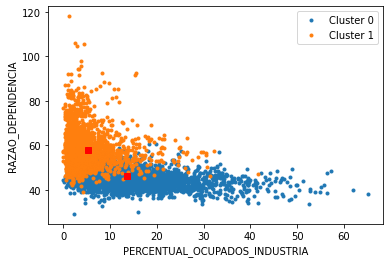

Describing clusters
===================Cluster 0==================
count    3095.000000
mean        2.661712
std         2.606045
min         1.000000
25%         1.000000
50%         1.000000
75%         4.000000
max        11.000000
Name: NIVEL_HIERARQUIA_URBANA_DISCRETIZADO, dtype: float64


count    3095.000000
mean        1.394860
std         5.245927
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max        68.926850
Name: PERCENTUAL_DOMICILIOS_PARTICULARES_OCUPADOS_AGLOMERADOS_ESTIMADO, dtype: float64


count    3095.000000
mean        7.907208
std         1.346385
min         2.810000
25%         7.050000
50%         7.810000
75%         8.720000
max        12.970000
Name: PERCENTUAL_POPULACAO_0_A_5_ANOS, dtype: float64


count    3095.000000
mean       14.419292
std         1.894904
min         4.590000
25%        13.200000
50%        14.350000
75%        15.610000
max        20.820000
Name: PERCENTUAL_POPULACAO_6_A_14_ANOS, dtype: float64


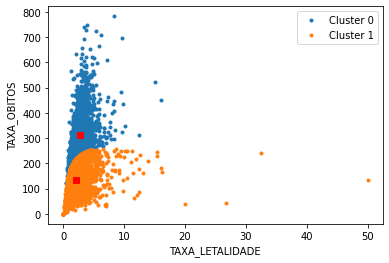

Describing clusters
===================Cluster 0==================
count     2271.000000
mean     12752.030983
std       4118.303193
min       2523.309844
25%      10099.370828
50%      12333.887043
75%      15105.491207
max      47204.328781
Name: TAXA_CASOS, dtype: float64


count    2271.000000
mean      313.501498
std        85.425054
min       122.473974
25%       252.596147
50%       296.645291
75%       356.285357
max       782.064651
Name: TAXA_OBITOS, dtype: float64


count    2271.000000
mean        2.732243
std         1.249356
min         0.486224
25%         1.915108
50%         2.540157
75%         3.266560
max        16.037736
Name: TAXA_LETALIDADE, dtype: float64


===================Cluster 1==================
count     3294.000000
mean      7460.124583
std       3416.164861
min        161.516098
25%       5014.322357
50%       7140.812547
75%       9584.860767
max      24198.628868
Name: TAXA_CASOS, dtype: float64


count    3294.000000
mean      134.199390
std       

In [402]:
show_results(None, centers_2, u_2, fpc_2, df_geral, scaler_antecedents, df_antecedents)
show_results(None, centers_2_c, u_2_c, fpc_2_c, df_consequents_not_normalized, scaler_concequents, df_concequents)

In [ ]:
centers_3, u_3, u0, d, jm, p, fpc_3 = cluster.cmeans(
    df_antecedents.values.T, c=3, m=m, error=epsilon, maxiter=1000, init=None)

In [ ]:
centers_3_c, u_3_c, u0, d, jm, p, fpc_3_c = cluster.cmeans(
    df_concequents.values.T, c=3, m=m, error=epsilon, maxiter=1000, init=None)

In [ ]:
show_results(None, centers_3, u_3, fpc_3, df_antecedents_not_normalized, scaler_antecedents, df_consequents_not_normalized)
show_results(None, centers_3_c, u_3_c, fpc_3_c, df_consequents_not_normalized, scaler_concequents, df_antecedents_not_normalized)

In [ ]:
centers_4, u_4, u0, d, jm, p, fpc_4 = cluster.cmeans(
    df_antecedents.values.T, c=4, m=m, error=epsilon, maxiter=1000, init=None)

In [ ]:
centers_4_c, u_4_c, u0, d, jm, p, fpc_4_c = cluster.cmeans(
    df_concequents.values.T, c=4, m=m, error=epsilon, maxiter=1000, init=None)

In [ ]:
show_results(None, centers_4, u_4, fpc_4, df_antecedents_not_normalized, scaler_antecedents, df_consequents_not_normalized)
show_results(None, centers_4_c, u_4_c, fpc_4_c, df_consequents_not_normalized, scaler_concequents, df_antecedents_not_normalized)